In [1]:
import sys
sys.path.append('/sanssauvegarde/homes/s17ouala/Codes/Boundedness/Boundedness_paper/Bounded_Neural_Embedding/generate_data')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
#from utils import Compute_Lyapunov_spectrum, compute_largest_Lyapunov
seed = 4

In [2]:
# Generate Lorenz 63 simulations
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 60.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

xt.values = catalog.analogs[catalog.analogs.shape[0]-2000:,:]
catalog.analogs= catalog.analogs[:catalog.analogs.shape[0]-2000,:]

X_train  = catalog.analogs[:,:1]#[:-1,:1]
Grad_t   = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
Batch_size = X_train.shape[0]

In [3]:
params = {}
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=1
params['dim_output']=3
params['dim_latent']=2
params['dim_observations'] = 3
params['dim_hidden']=3
pretrained = False
path = ''
file_name = 'Model_RINN_Bounded_seed'+str(seed)+'.pt'
params['dt_integration'] = GD.dt_integration

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            y_aug = np.random.uniform(size=(Batch_size,params['dim_latent']))
            self.y_aug = torch.nn.Parameter(data=torch.from_numpy(y_aug).float(), requires_grad=True)
            self.m = torch.nn.Parameter(torch.Tensor(params['dim_observations']))
            torch.nn.init.uniform_(self.m)
            self.linearCell     = torch.nn.Linear(params['dim_input']+params['dim_latent'], params['dim_output']) 
            self.BilinearCell   = torch.nn.Bilinear(params['dim_input']+params['dim_latent'], params['dim_input']+params['dim_latent'], params['dim_output'], bias = False)
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                aug_inp = torch.cat((inp, self.y_aug), dim=1)# - self.m
            else:
                aug_inp = inp
            L_outp   = self.linearCell(aug_inp)
            BP       = self.BilinearCell(aug_inp,aug_inp)
            grad = L_outp + BP
            As = (self.linearCell.weight + torch.transpose(self.linearCell.weight,1,0))/2
            eig_vals = (torch.symeig(As,eigenvectors=True)[0])
            return grad, aug_inp, eig_vals
model  = FC_net(params)# init LQM model (\dot(x) = LQM(x))


class FC_net_shifted(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_shifted, self).__init__()
            self.Dyn_net_init = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                aug_inp = torch.cat((inp, self.Dyn_net_init.y_aug), dim=1) - self.Dyn_net_init.m
            else:
                aug_inp = inp
            d = self.Dyn_net_init.linearCell.bias + torch.nn.functional.bilinear(self.Dyn_net_init.m,self.Dyn_net_init.m,self.Dyn_net_init.BilinearCell.weight) + torch.nn.functional.linear(self.Dyn_net_init.m,self.Dyn_net_init.linearCell.weight)
            A = torch.matmul(self.Dyn_net_init.m,self.Dyn_net_init.BilinearCell.weight + self.Dyn_net_init.BilinearCell.weight.transpose(2,1)) + self.Dyn_net_init.linearCell.weight
            L_outp   = torch.nn.functional.linear(aug_inp,A,d)
            BP       = self.Dyn_net_init.BilinearCell(aug_inp,aug_inp)
            grad = L_outp + BP
            As = (A + torch.transpose(A,1,0))/2
            eig_vals = (torch.symeig(As,eigenvectors=True)[0])
            return grad, aug_inp, eig_vals, A, d
model_shifted  = FC_net_shifted(params)# shifted LQM model 

class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model_shifted.Dyn_net_init
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """

        
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = aug_inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = aug_inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = aug_inp + params['dt_integration']*k3[:,:]            
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else : 
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp, eig_vals
        
class INT_net_shifted(torch.nn.Module):
        def __init__(self, params):
            super(INT_net_shifted, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model_shifted
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """

            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp, eig_vals, A, d  = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = aug_inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp, tmpp, A, d   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = aug_inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp, tmpp, A, d   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = aug_inp + params['dt_integration']*k3[:,:]            
                k4, tmp, tmpp, A, d   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else :
                k1, aug_inp, eig_vals, A, d   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp, tmpp, A, d   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp, tmpp, A, d   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp, tmpp, A, d   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp, eig_vals, A, d

In [5]:
x = (torch.from_numpy(X_train).float())
z = (torch.from_numpy(Grad_t).float())
modelRINN = INT_net(params)
modelRINN_shifted = INT_net_shifted(params)

In [6]:
dt = params['dt_integration']
aug_vect = []

if pretrained :
    modelRINN_shifted.load_state_dict(torch.load(path + file_name))
criterion = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(modelRINN_shifted.parameters(),lr = 0.1)

In [7]:
loss_it = []
alpha   = 1.
beta    = 1.
gama    = 100.
lam     = 1000.
idx     = 0
c       = 0

In [8]:
for param_group in optimizer.param_groups:
        print(param_group['lr'])

for param_group in optimizer.param_groups:
        param_group['lr'] = 0.1

0.1


In [9]:
params['ntrain']=[100000000000000000000,10000]
for t in range(0,params['ntrain'][0]):
        # Forward pass: Compute predicted y by passing x to the model
        
        pred, grad, inp, aug_inp, eig_vals, A, d = modelRINN_shifted(x,dt)
#        pred1, grad1, inp, aug_inp, eig_vals = modelRINN(aug_inp,dt)
        l1_reg = 0.
        for name, W in modelRINN_shifted.named_parameters():
            if name == 'Dyn_net.Dyn_net_init.BilinearCell.weight':
                for i in range(W.shape[0]):
                    for j in range(W.shape[0]):
                        for k in range(W.shape[0]):
                            l1_reg = l1_reg + torch.norm((W[i,j,k] + \
                             W[i,k,j] + \
                             W[j,i,k] + \
                             W[j,k,i] + \
                             W[k,i,j] + \
                             W[k,j,i]))
        # Compute and print loss
        loss1 = criterion(grad[:,:1], z).mean()
        loss2 = criterion(pred[:-1,:] , aug_inp[1:,:]).sum()
        loss3 = torch.sum(torch.relu(eig_vals)/(torch.relu(eig_vals)+1))
        loss  =  alpha*loss1+beta*loss2 + gama*(l1_reg)+ lam*loss3 #+ 10*beta*loss4# + 10*beta*loss5
        loss_it.append(loss.data.numpy())
        print('epoch', t, 'idx : ', idx,'loss : ', loss)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        torch.save(modelRINN_shifted.state_dict(),'4k_L63_shift_V2_seed'+str(seed)+'.pt')  
        if t == 10000 and idx ==0:
            gama = 1.
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01
            idx+=1
        if loss.data.numpy()<0.4 and idx ==1 and t > 20000:
            break

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272126608/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)


epoch 0 idx :  0 loss :  tensor(10061.7480, grad_fn=<AddBackward0>)
epoch 1 idx :  0 loss :  tensor(6570.3789, grad_fn=<AddBackward0>)
epoch 2 idx :  0 loss :  tensor(4580.8979, grad_fn=<AddBackward0>)
epoch 3 idx :  0 loss :  tensor(4246.7393, grad_fn=<AddBackward0>)
epoch 4 idx :  0 loss :  tensor(3960.7312, grad_fn=<AddBackward0>)
epoch 5 idx :  0 loss :  tensor(3719.5310, grad_fn=<AddBackward0>)
epoch 6 idx :  0 loss :  tensor(3930.8674, grad_fn=<AddBackward0>)
epoch 7 idx :  0 loss :  tensor(4164.4443, grad_fn=<AddBackward0>)
epoch 8 idx :  0 loss :  tensor(4113.3906, grad_fn=<AddBackward0>)
epoch 9 idx :  0 loss :  tensor(3726.6956, grad_fn=<AddBackward0>)
epoch 10 idx :  0 loss :  tensor(3553.0068, grad_fn=<AddBackward0>)
epoch 11 idx :  0 loss :  tensor(3527.7983, grad_fn=<AddBackward0>)
epoch 12 idx :  0 loss :  tensor(3410.1208, grad_fn=<AddBackward0>)
epoch 13 idx :  0 loss :  tensor(3194.7524, grad_fn=<AddBackward0>)
epoch 14 idx :  0 loss :  tensor(3150.1997, grad_fn=<AddB

epoch 121 idx :  0 loss :  tensor(1176.7070, grad_fn=<AddBackward0>)
epoch 122 idx :  0 loss :  tensor(1295.3931, grad_fn=<AddBackward0>)
epoch 123 idx :  0 loss :  tensor(1362.1189, grad_fn=<AddBackward0>)
epoch 124 idx :  0 loss :  tensor(1289.5100, grad_fn=<AddBackward0>)
epoch 125 idx :  0 loss :  tensor(1179.4453, grad_fn=<AddBackward0>)
epoch 126 idx :  0 loss :  tensor(1113.6987, grad_fn=<AddBackward0>)
epoch 127 idx :  0 loss :  tensor(1082.5632, grad_fn=<AddBackward0>)
epoch 128 idx :  0 loss :  tensor(1132.9254, grad_fn=<AddBackward0>)
epoch 129 idx :  0 loss :  tensor(1073.1790, grad_fn=<AddBackward0>)
epoch 130 idx :  0 loss :  tensor(1009.5502, grad_fn=<AddBackward0>)
epoch 131 idx :  0 loss :  tensor(1160.6344, grad_fn=<AddBackward0>)
epoch 132 idx :  0 loss :  tensor(1197.9490, grad_fn=<AddBackward0>)
epoch 133 idx :  0 loss :  tensor(1123.6367, grad_fn=<AddBackward0>)
epoch 134 idx :  0 loss :  tensor(1029.1508, grad_fn=<AddBackward0>)
epoch 135 idx :  0 loss :  tensor(

epoch 243 idx :  0 loss :  tensor(453.8621, grad_fn=<AddBackward0>)
epoch 244 idx :  0 loss :  tensor(463.8730, grad_fn=<AddBackward0>)
epoch 245 idx :  0 loss :  tensor(619.9660, grad_fn=<AddBackward0>)
epoch 246 idx :  0 loss :  tensor(948.4130, grad_fn=<AddBackward0>)
epoch 247 idx :  0 loss :  tensor(1112.9669, grad_fn=<AddBackward0>)
epoch 248 idx :  0 loss :  tensor(1144.7009, grad_fn=<AddBackward0>)
epoch 249 idx :  0 loss :  tensor(1101.3379, grad_fn=<AddBackward0>)
epoch 250 idx :  0 loss :  tensor(1066.6630, grad_fn=<AddBackward0>)
epoch 251 idx :  0 loss :  tensor(993.9822, grad_fn=<AddBackward0>)
epoch 252 idx :  0 loss :  tensor(883.1908, grad_fn=<AddBackward0>)
epoch 253 idx :  0 loss :  tensor(735.7837, grad_fn=<AddBackward0>)
epoch 254 idx :  0 loss :  tensor(669.2340, grad_fn=<AddBackward0>)
epoch 255 idx :  0 loss :  tensor(546.1138, grad_fn=<AddBackward0>)
epoch 256 idx :  0 loss :  tensor(463.8725, grad_fn=<AddBackward0>)
epoch 257 idx :  0 loss :  tensor(917.6189, 

epoch 366 idx :  0 loss :  tensor(295.7155, grad_fn=<AddBackward0>)
epoch 367 idx :  0 loss :  tensor(275.8068, grad_fn=<AddBackward0>)
epoch 368 idx :  0 loss :  tensor(225.9383, grad_fn=<AddBackward0>)
epoch 369 idx :  0 loss :  tensor(308.2641, grad_fn=<AddBackward0>)
epoch 370 idx :  0 loss :  tensor(381.3738, grad_fn=<AddBackward0>)
epoch 371 idx :  0 loss :  tensor(370.5992, grad_fn=<AddBackward0>)
epoch 372 idx :  0 loss :  tensor(237.9611, grad_fn=<AddBackward0>)
epoch 373 idx :  0 loss :  tensor(169.5621, grad_fn=<AddBackward0>)
epoch 374 idx :  0 loss :  tensor(267.5664, grad_fn=<AddBackward0>)
epoch 375 idx :  0 loss :  tensor(301.4926, grad_fn=<AddBackward0>)
epoch 376 idx :  0 loss :  tensor(273.0075, grad_fn=<AddBackward0>)
epoch 377 idx :  0 loss :  tensor(251.9561, grad_fn=<AddBackward0>)
epoch 378 idx :  0 loss :  tensor(320.1327, grad_fn=<AddBackward0>)
epoch 379 idx :  0 loss :  tensor(330.3372, grad_fn=<AddBackward0>)
epoch 380 idx :  0 loss :  tensor(363.9973, grad

epoch 490 idx :  0 loss :  tensor(682.5214, grad_fn=<AddBackward0>)
epoch 491 idx :  0 loss :  tensor(518.8331, grad_fn=<AddBackward0>)
epoch 492 idx :  0 loss :  tensor(549.0081, grad_fn=<AddBackward0>)
epoch 493 idx :  0 loss :  tensor(693.5309, grad_fn=<AddBackward0>)
epoch 494 idx :  0 loss :  tensor(671.9766, grad_fn=<AddBackward0>)
epoch 495 idx :  0 loss :  tensor(639.4190, grad_fn=<AddBackward0>)
epoch 496 idx :  0 loss :  tensor(628.7485, grad_fn=<AddBackward0>)
epoch 497 idx :  0 loss :  tensor(534.8203, grad_fn=<AddBackward0>)
epoch 498 idx :  0 loss :  tensor(449.6364, grad_fn=<AddBackward0>)
epoch 499 idx :  0 loss :  tensor(429.7334, grad_fn=<AddBackward0>)
epoch 500 idx :  0 loss :  tensor(565.6936, grad_fn=<AddBackward0>)
epoch 501 idx :  0 loss :  tensor(537.2349, grad_fn=<AddBackward0>)
epoch 502 idx :  0 loss :  tensor(655.8467, grad_fn=<AddBackward0>)
epoch 503 idx :  0 loss :  tensor(793.1434, grad_fn=<AddBackward0>)
epoch 504 idx :  0 loss :  tensor(847.2875, grad

epoch 612 idx :  0 loss :  tensor(182.1138, grad_fn=<AddBackward0>)
epoch 613 idx :  0 loss :  tensor(218.6159, grad_fn=<AddBackward0>)
epoch 614 idx :  0 loss :  tensor(208.2608, grad_fn=<AddBackward0>)
epoch 615 idx :  0 loss :  tensor(190.2879, grad_fn=<AddBackward0>)
epoch 616 idx :  0 loss :  tensor(146.9859, grad_fn=<AddBackward0>)
epoch 617 idx :  0 loss :  tensor(129.9872, grad_fn=<AddBackward0>)
epoch 618 idx :  0 loss :  tensor(177.2587, grad_fn=<AddBackward0>)
epoch 619 idx :  0 loss :  tensor(190.9767, grad_fn=<AddBackward0>)
epoch 620 idx :  0 loss :  tensor(147.7266, grad_fn=<AddBackward0>)
epoch 621 idx :  0 loss :  tensor(158.7784, grad_fn=<AddBackward0>)
epoch 622 idx :  0 loss :  tensor(140.2735, grad_fn=<AddBackward0>)
epoch 623 idx :  0 loss :  tensor(178.8375, grad_fn=<AddBackward0>)
epoch 624 idx :  0 loss :  tensor(173.1946, grad_fn=<AddBackward0>)
epoch 625 idx :  0 loss :  tensor(144.2804, grad_fn=<AddBackward0>)
epoch 626 idx :  0 loss :  tensor(149.0331, grad

epoch 735 idx :  0 loss :  tensor(180.2443, grad_fn=<AddBackward0>)
epoch 736 idx :  0 loss :  tensor(142.3897, grad_fn=<AddBackward0>)
epoch 737 idx :  0 loss :  tensor(118.1885, grad_fn=<AddBackward0>)
epoch 738 idx :  0 loss :  tensor(153.8351, grad_fn=<AddBackward0>)
epoch 739 idx :  0 loss :  tensor(186.0427, grad_fn=<AddBackward0>)
epoch 740 idx :  0 loss :  tensor(190.5344, grad_fn=<AddBackward0>)
epoch 741 idx :  0 loss :  tensor(166.2396, grad_fn=<AddBackward0>)
epoch 742 idx :  0 loss :  tensor(144.8664, grad_fn=<AddBackward0>)
epoch 743 idx :  0 loss :  tensor(133.2757, grad_fn=<AddBackward0>)
epoch 744 idx :  0 loss :  tensor(126.0925, grad_fn=<AddBackward0>)
epoch 745 idx :  0 loss :  tensor(163.2394, grad_fn=<AddBackward0>)
epoch 746 idx :  0 loss :  tensor(162.7535, grad_fn=<AddBackward0>)
epoch 747 idx :  0 loss :  tensor(143.6116, grad_fn=<AddBackward0>)
epoch 748 idx :  0 loss :  tensor(178.9846, grad_fn=<AddBackward0>)
epoch 749 idx :  0 loss :  tensor(184.7424, grad

epoch 859 idx :  0 loss :  tensor(139.2251, grad_fn=<AddBackward0>)
epoch 860 idx :  0 loss :  tensor(147.8097, grad_fn=<AddBackward0>)
epoch 861 idx :  0 loss :  tensor(177.1563, grad_fn=<AddBackward0>)
epoch 862 idx :  0 loss :  tensor(159.3303, grad_fn=<AddBackward0>)
epoch 863 idx :  0 loss :  tensor(173.2754, grad_fn=<AddBackward0>)
epoch 864 idx :  0 loss :  tensor(174.9710, grad_fn=<AddBackward0>)
epoch 865 idx :  0 loss :  tensor(161.4366, grad_fn=<AddBackward0>)
epoch 866 idx :  0 loss :  tensor(150.6213, grad_fn=<AddBackward0>)
epoch 867 idx :  0 loss :  tensor(145.7738, grad_fn=<AddBackward0>)
epoch 868 idx :  0 loss :  tensor(162.3680, grad_fn=<AddBackward0>)
epoch 869 idx :  0 loss :  tensor(160.2679, grad_fn=<AddBackward0>)
epoch 870 idx :  0 loss :  tensor(149.8503, grad_fn=<AddBackward0>)
epoch 871 idx :  0 loss :  tensor(126.3130, grad_fn=<AddBackward0>)
epoch 872 idx :  0 loss :  tensor(151.8026, grad_fn=<AddBackward0>)
epoch 873 idx :  0 loss :  tensor(178.2630, grad

epoch 980 idx :  0 loss :  tensor(107.1451, grad_fn=<AddBackward0>)
epoch 981 idx :  0 loss :  tensor(224.8837, grad_fn=<AddBackward0>)
epoch 982 idx :  0 loss :  tensor(276.7436, grad_fn=<AddBackward0>)
epoch 983 idx :  0 loss :  tensor(212.6277, grad_fn=<AddBackward0>)
epoch 984 idx :  0 loss :  tensor(193.2551, grad_fn=<AddBackward0>)
epoch 985 idx :  0 loss :  tensor(201.8056, grad_fn=<AddBackward0>)
epoch 986 idx :  0 loss :  tensor(172.8867, grad_fn=<AddBackward0>)
epoch 987 idx :  0 loss :  tensor(157.7584, grad_fn=<AddBackward0>)
epoch 988 idx :  0 loss :  tensor(214.5271, grad_fn=<AddBackward0>)
epoch 989 idx :  0 loss :  tensor(239.0591, grad_fn=<AddBackward0>)
epoch 990 idx :  0 loss :  tensor(212.4194, grad_fn=<AddBackward0>)
epoch 991 idx :  0 loss :  tensor(218.8246, grad_fn=<AddBackward0>)
epoch 992 idx :  0 loss :  tensor(159.6361, grad_fn=<AddBackward0>)
epoch 993 idx :  0 loss :  tensor(190.2745, grad_fn=<AddBackward0>)
epoch 994 idx :  0 loss :  tensor(158.1934, grad

epoch 1103 idx :  0 loss :  tensor(230.2133, grad_fn=<AddBackward0>)
epoch 1104 idx :  0 loss :  tensor(217.4372, grad_fn=<AddBackward0>)
epoch 1105 idx :  0 loss :  tensor(169.1054, grad_fn=<AddBackward0>)
epoch 1106 idx :  0 loss :  tensor(103.8451, grad_fn=<AddBackward0>)
epoch 1107 idx :  0 loss :  tensor(131.8629, grad_fn=<AddBackward0>)
epoch 1108 idx :  0 loss :  tensor(113.8191, grad_fn=<AddBackward0>)
epoch 1109 idx :  0 loss :  tensor(84.8328, grad_fn=<AddBackward0>)
epoch 1110 idx :  0 loss :  tensor(216.0962, grad_fn=<AddBackward0>)
epoch 1111 idx :  0 loss :  tensor(243.2619, grad_fn=<AddBackward0>)
epoch 1112 idx :  0 loss :  tensor(187.8575, grad_fn=<AddBackward0>)
epoch 1113 idx :  0 loss :  tensor(143.5355, grad_fn=<AddBackward0>)
epoch 1114 idx :  0 loss :  tensor(144.0711, grad_fn=<AddBackward0>)
epoch 1115 idx :  0 loss :  tensor(170.6024, grad_fn=<AddBackward0>)
epoch 1116 idx :  0 loss :  tensor(162.6650, grad_fn=<AddBackward0>)
epoch 1117 idx :  0 loss :  tensor(

epoch 1223 idx :  0 loss :  tensor(416.5402, grad_fn=<AddBackward0>)
epoch 1224 idx :  0 loss :  tensor(451.9789, grad_fn=<AddBackward0>)
epoch 1225 idx :  0 loss :  tensor(525.2268, grad_fn=<AddBackward0>)
epoch 1226 idx :  0 loss :  tensor(527.3207, grad_fn=<AddBackward0>)
epoch 1227 idx :  0 loss :  tensor(581.9234, grad_fn=<AddBackward0>)
epoch 1228 idx :  0 loss :  tensor(574.2048, grad_fn=<AddBackward0>)
epoch 1229 idx :  0 loss :  tensor(452.6113, grad_fn=<AddBackward0>)
epoch 1230 idx :  0 loss :  tensor(398.1789, grad_fn=<AddBackward0>)
epoch 1231 idx :  0 loss :  tensor(432.4481, grad_fn=<AddBackward0>)
epoch 1232 idx :  0 loss :  tensor(397.6182, grad_fn=<AddBackward0>)
epoch 1233 idx :  0 loss :  tensor(311.7066, grad_fn=<AddBackward0>)
epoch 1234 idx :  0 loss :  tensor(344.4074, grad_fn=<AddBackward0>)
epoch 1235 idx :  0 loss :  tensor(379.7274, grad_fn=<AddBackward0>)
epoch 1236 idx :  0 loss :  tensor(391.5219, grad_fn=<AddBackward0>)
epoch 1237 idx :  0 loss :  tensor

epoch 1345 idx :  0 loss :  tensor(196.2001, grad_fn=<AddBackward0>)
epoch 1346 idx :  0 loss :  tensor(170.8329, grad_fn=<AddBackward0>)
epoch 1347 idx :  0 loss :  tensor(131.0994, grad_fn=<AddBackward0>)
epoch 1348 idx :  0 loss :  tensor(176.7356, grad_fn=<AddBackward0>)
epoch 1349 idx :  0 loss :  tensor(177.5816, grad_fn=<AddBackward0>)
epoch 1350 idx :  0 loss :  tensor(184.4746, grad_fn=<AddBackward0>)
epoch 1351 idx :  0 loss :  tensor(209.7198, grad_fn=<AddBackward0>)
epoch 1352 idx :  0 loss :  tensor(122.9341, grad_fn=<AddBackward0>)
epoch 1353 idx :  0 loss :  tensor(179.7840, grad_fn=<AddBackward0>)
epoch 1354 idx :  0 loss :  tensor(239.1767, grad_fn=<AddBackward0>)
epoch 1355 idx :  0 loss :  tensor(204.8293, grad_fn=<AddBackward0>)
epoch 1356 idx :  0 loss :  tensor(131.9364, grad_fn=<AddBackward0>)
epoch 1357 idx :  0 loss :  tensor(150.6217, grad_fn=<AddBackward0>)
epoch 1358 idx :  0 loss :  tensor(105.3956, grad_fn=<AddBackward0>)
epoch 1359 idx :  0 loss :  tensor

epoch 1468 idx :  0 loss :  tensor(133.2606, grad_fn=<AddBackward0>)
epoch 1469 idx :  0 loss :  tensor(116.6860, grad_fn=<AddBackward0>)
epoch 1470 idx :  0 loss :  tensor(222.6373, grad_fn=<AddBackward0>)
epoch 1471 idx :  0 loss :  tensor(257.2948, grad_fn=<AddBackward0>)
epoch 1472 idx :  0 loss :  tensor(223.9286, grad_fn=<AddBackward0>)
epoch 1473 idx :  0 loss :  tensor(184.9815, grad_fn=<AddBackward0>)
epoch 1474 idx :  0 loss :  tensor(198.1507, grad_fn=<AddBackward0>)
epoch 1475 idx :  0 loss :  tensor(146.8713, grad_fn=<AddBackward0>)
epoch 1476 idx :  0 loss :  tensor(164.6065, grad_fn=<AddBackward0>)
epoch 1477 idx :  0 loss :  tensor(192.8327, grad_fn=<AddBackward0>)
epoch 1478 idx :  0 loss :  tensor(181.0898, grad_fn=<AddBackward0>)
epoch 1479 idx :  0 loss :  tensor(158.7601, grad_fn=<AddBackward0>)
epoch 1480 idx :  0 loss :  tensor(196.9183, grad_fn=<AddBackward0>)
epoch 1481 idx :  0 loss :  tensor(154.0765, grad_fn=<AddBackward0>)
epoch 1482 idx :  0 loss :  tensor

epoch 1589 idx :  0 loss :  tensor(189.4141, grad_fn=<AddBackward0>)
epoch 1590 idx :  0 loss :  tensor(117.1654, grad_fn=<AddBackward0>)
epoch 1591 idx :  0 loss :  tensor(137.1468, grad_fn=<AddBackward0>)
epoch 1592 idx :  0 loss :  tensor(178.8238, grad_fn=<AddBackward0>)
epoch 1593 idx :  0 loss :  tensor(130.9841, grad_fn=<AddBackward0>)
epoch 1594 idx :  0 loss :  tensor(113.4216, grad_fn=<AddBackward0>)
epoch 1595 idx :  0 loss :  tensor(100.5069, grad_fn=<AddBackward0>)
epoch 1596 idx :  0 loss :  tensor(97.9286, grad_fn=<AddBackward0>)
epoch 1597 idx :  0 loss :  tensor(141.2030, grad_fn=<AddBackward0>)
epoch 1598 idx :  0 loss :  tensor(116.2412, grad_fn=<AddBackward0>)
epoch 1599 idx :  0 loss :  tensor(137.1400, grad_fn=<AddBackward0>)
epoch 1600 idx :  0 loss :  tensor(142.9969, grad_fn=<AddBackward0>)
epoch 1601 idx :  0 loss :  tensor(107.2143, grad_fn=<AddBackward0>)
epoch 1602 idx :  0 loss :  tensor(93.4862, grad_fn=<AddBackward0>)
epoch 1603 idx :  0 loss :  tensor(1

epoch 1708 idx :  0 loss :  tensor(161.6858, grad_fn=<AddBackward0>)
epoch 1709 idx :  0 loss :  tensor(271.5795, grad_fn=<AddBackward0>)
epoch 1710 idx :  0 loss :  tensor(242.8529, grad_fn=<AddBackward0>)
epoch 1711 idx :  0 loss :  tensor(167.4790, grad_fn=<AddBackward0>)
epoch 1712 idx :  0 loss :  tensor(187.6282, grad_fn=<AddBackward0>)
epoch 1713 idx :  0 loss :  tensor(120.5500, grad_fn=<AddBackward0>)
epoch 1714 idx :  0 loss :  tensor(173.6899, grad_fn=<AddBackward0>)
epoch 1715 idx :  0 loss :  tensor(230.6081, grad_fn=<AddBackward0>)
epoch 1716 idx :  0 loss :  tensor(213.9858, grad_fn=<AddBackward0>)
epoch 1717 idx :  0 loss :  tensor(251.8600, grad_fn=<AddBackward0>)
epoch 1718 idx :  0 loss :  tensor(220.7775, grad_fn=<AddBackward0>)
epoch 1719 idx :  0 loss :  tensor(141.9107, grad_fn=<AddBackward0>)
epoch 1720 idx :  0 loss :  tensor(232.5673, grad_fn=<AddBackward0>)
epoch 1721 idx :  0 loss :  tensor(262.6362, grad_fn=<AddBackward0>)
epoch 1722 idx :  0 loss :  tensor

epoch 1829 idx :  0 loss :  tensor(201.7503, grad_fn=<AddBackward0>)
epoch 1830 idx :  0 loss :  tensor(87.9766, grad_fn=<AddBackward0>)
epoch 1831 idx :  0 loss :  tensor(286.4982, grad_fn=<AddBackward0>)
epoch 1832 idx :  0 loss :  tensor(374.5150, grad_fn=<AddBackward0>)
epoch 1833 idx :  0 loss :  tensor(322.8275, grad_fn=<AddBackward0>)
epoch 1834 idx :  0 loss :  tensor(287.8240, grad_fn=<AddBackward0>)
epoch 1835 idx :  0 loss :  tensor(217.6016, grad_fn=<AddBackward0>)
epoch 1836 idx :  0 loss :  tensor(162.6223, grad_fn=<AddBackward0>)
epoch 1837 idx :  0 loss :  tensor(184.0952, grad_fn=<AddBackward0>)
epoch 1838 idx :  0 loss :  tensor(199.4293, grad_fn=<AddBackward0>)
epoch 1839 idx :  0 loss :  tensor(150.3161, grad_fn=<AddBackward0>)
epoch 1840 idx :  0 loss :  tensor(185.3227, grad_fn=<AddBackward0>)
epoch 1841 idx :  0 loss :  tensor(198.4637, grad_fn=<AddBackward0>)
epoch 1842 idx :  0 loss :  tensor(122.9732, grad_fn=<AddBackward0>)
epoch 1843 idx :  0 loss :  tensor(

epoch 1949 idx :  0 loss :  tensor(173.3968, grad_fn=<AddBackward0>)
epoch 1950 idx :  0 loss :  tensor(186.5816, grad_fn=<AddBackward0>)
epoch 1951 idx :  0 loss :  tensor(184.0131, grad_fn=<AddBackward0>)
epoch 1952 idx :  0 loss :  tensor(227.1660, grad_fn=<AddBackward0>)
epoch 1953 idx :  0 loss :  tensor(193.8966, grad_fn=<AddBackward0>)
epoch 1954 idx :  0 loss :  tensor(233.7709, grad_fn=<AddBackward0>)
epoch 1955 idx :  0 loss :  tensor(250.5824, grad_fn=<AddBackward0>)
epoch 1956 idx :  0 loss :  tensor(143.3920, grad_fn=<AddBackward0>)
epoch 1957 idx :  0 loss :  tensor(153.6812, grad_fn=<AddBackward0>)
epoch 1958 idx :  0 loss :  tensor(163.5892, grad_fn=<AddBackward0>)
epoch 1959 idx :  0 loss :  tensor(176.3188, grad_fn=<AddBackward0>)
epoch 1960 idx :  0 loss :  tensor(146.1779, grad_fn=<AddBackward0>)
epoch 1961 idx :  0 loss :  tensor(131.2423, grad_fn=<AddBackward0>)
epoch 1962 idx :  0 loss :  tensor(109.4259, grad_fn=<AddBackward0>)
epoch 1963 idx :  0 loss :  tensor

epoch 2070 idx :  0 loss :  tensor(114.1022, grad_fn=<AddBackward0>)
epoch 2071 idx :  0 loss :  tensor(146.7865, grad_fn=<AddBackward0>)
epoch 2072 idx :  0 loss :  tensor(168.5691, grad_fn=<AddBackward0>)
epoch 2073 idx :  0 loss :  tensor(132.0732, grad_fn=<AddBackward0>)
epoch 2074 idx :  0 loss :  tensor(198.0505, grad_fn=<AddBackward0>)
epoch 2075 idx :  0 loss :  tensor(223.3855, grad_fn=<AddBackward0>)
epoch 2076 idx :  0 loss :  tensor(244.2624, grad_fn=<AddBackward0>)
epoch 2077 idx :  0 loss :  tensor(222.0078, grad_fn=<AddBackward0>)
epoch 2078 idx :  0 loss :  tensor(222.0109, grad_fn=<AddBackward0>)
epoch 2079 idx :  0 loss :  tensor(215.4981, grad_fn=<AddBackward0>)
epoch 2080 idx :  0 loss :  tensor(259.9999, grad_fn=<AddBackward0>)
epoch 2081 idx :  0 loss :  tensor(266.4503, grad_fn=<AddBackward0>)
epoch 2082 idx :  0 loss :  tensor(241.2898, grad_fn=<AddBackward0>)
epoch 2083 idx :  0 loss :  tensor(228.7490, grad_fn=<AddBackward0>)
epoch 2084 idx :  0 loss :  tensor

epoch 2189 idx :  0 loss :  tensor(222.7502, grad_fn=<AddBackward0>)
epoch 2190 idx :  0 loss :  tensor(252.8418, grad_fn=<AddBackward0>)
epoch 2191 idx :  0 loss :  tensor(227.5344, grad_fn=<AddBackward0>)
epoch 2192 idx :  0 loss :  tensor(233.5000, grad_fn=<AddBackward0>)
epoch 2193 idx :  0 loss :  tensor(190.6042, grad_fn=<AddBackward0>)
epoch 2194 idx :  0 loss :  tensor(161.2639, grad_fn=<AddBackward0>)
epoch 2195 idx :  0 loss :  tensor(150.2464, grad_fn=<AddBackward0>)
epoch 2196 idx :  0 loss :  tensor(103.8173, grad_fn=<AddBackward0>)
epoch 2197 idx :  0 loss :  tensor(159.8589, grad_fn=<AddBackward0>)
epoch 2198 idx :  0 loss :  tensor(219.7545, grad_fn=<AddBackward0>)
epoch 2199 idx :  0 loss :  tensor(202.6768, grad_fn=<AddBackward0>)
epoch 2200 idx :  0 loss :  tensor(146.0300, grad_fn=<AddBackward0>)
epoch 2201 idx :  0 loss :  tensor(145.0613, grad_fn=<AddBackward0>)
epoch 2202 idx :  0 loss :  tensor(113.3525, grad_fn=<AddBackward0>)
epoch 2203 idx :  0 loss :  tensor

epoch 2311 idx :  0 loss :  tensor(195.2064, grad_fn=<AddBackward0>)
epoch 2312 idx :  0 loss :  tensor(211.2534, grad_fn=<AddBackward0>)
epoch 2313 idx :  0 loss :  tensor(183.1084, grad_fn=<AddBackward0>)
epoch 2314 idx :  0 loss :  tensor(125.3432, grad_fn=<AddBackward0>)
epoch 2315 idx :  0 loss :  tensor(212.7894, grad_fn=<AddBackward0>)
epoch 2316 idx :  0 loss :  tensor(243.0414, grad_fn=<AddBackward0>)
epoch 2317 idx :  0 loss :  tensor(141.4140, grad_fn=<AddBackward0>)
epoch 2318 idx :  0 loss :  tensor(180.3932, grad_fn=<AddBackward0>)
epoch 2319 idx :  0 loss :  tensor(206.6486, grad_fn=<AddBackward0>)
epoch 2320 idx :  0 loss :  tensor(194.2590, grad_fn=<AddBackward0>)
epoch 2321 idx :  0 loss :  tensor(183.3835, grad_fn=<AddBackward0>)
epoch 2322 idx :  0 loss :  tensor(176.2150, grad_fn=<AddBackward0>)
epoch 2323 idx :  0 loss :  tensor(165.3187, grad_fn=<AddBackward0>)
epoch 2324 idx :  0 loss :  tensor(202.7934, grad_fn=<AddBackward0>)
epoch 2325 idx :  0 loss :  tensor

epoch 2431 idx :  0 loss :  tensor(251.7226, grad_fn=<AddBackward0>)
epoch 2432 idx :  0 loss :  tensor(202.8500, grad_fn=<AddBackward0>)
epoch 2433 idx :  0 loss :  tensor(142.3155, grad_fn=<AddBackward0>)
epoch 2434 idx :  0 loss :  tensor(145.0335, grad_fn=<AddBackward0>)
epoch 2435 idx :  0 loss :  tensor(187.4769, grad_fn=<AddBackward0>)
epoch 2436 idx :  0 loss :  tensor(172.7146, grad_fn=<AddBackward0>)
epoch 2437 idx :  0 loss :  tensor(142.7014, grad_fn=<AddBackward0>)
epoch 2438 idx :  0 loss :  tensor(145.1938, grad_fn=<AddBackward0>)
epoch 2439 idx :  0 loss :  tensor(195.9664, grad_fn=<AddBackward0>)
epoch 2440 idx :  0 loss :  tensor(222.1807, grad_fn=<AddBackward0>)
epoch 2441 idx :  0 loss :  tensor(210.2962, grad_fn=<AddBackward0>)
epoch 2442 idx :  0 loss :  tensor(225.4432, grad_fn=<AddBackward0>)
epoch 2443 idx :  0 loss :  tensor(183.7320, grad_fn=<AddBackward0>)
epoch 2444 idx :  0 loss :  tensor(179.0929, grad_fn=<AddBackward0>)
epoch 2445 idx :  0 loss :  tensor

epoch 2551 idx :  0 loss :  tensor(1234.3029, grad_fn=<AddBackward0>)
epoch 2552 idx :  0 loss :  tensor(1035.3104, grad_fn=<AddBackward0>)
epoch 2553 idx :  0 loss :  tensor(1039.3999, grad_fn=<AddBackward0>)
epoch 2554 idx :  0 loss :  tensor(989.3779, grad_fn=<AddBackward0>)
epoch 2555 idx :  0 loss :  tensor(733.8414, grad_fn=<AddBackward0>)
epoch 2556 idx :  0 loss :  tensor(644.3380, grad_fn=<AddBackward0>)
epoch 2557 idx :  0 loss :  tensor(663.3967, grad_fn=<AddBackward0>)
epoch 2558 idx :  0 loss :  tensor(873.3914, grad_fn=<AddBackward0>)
epoch 2559 idx :  0 loss :  tensor(996.3444, grad_fn=<AddBackward0>)
epoch 2560 idx :  0 loss :  tensor(946.9515, grad_fn=<AddBackward0>)
epoch 2561 idx :  0 loss :  tensor(749.1104, grad_fn=<AddBackward0>)
epoch 2562 idx :  0 loss :  tensor(542.1920, grad_fn=<AddBackward0>)
epoch 2563 idx :  0 loss :  tensor(366.8138, grad_fn=<AddBackward0>)
epoch 2564 idx :  0 loss :  tensor(384.3871, grad_fn=<AddBackward0>)
epoch 2565 idx :  0 loss :  ten

epoch 2670 idx :  0 loss :  tensor(230.9357, grad_fn=<AddBackward0>)
epoch 2671 idx :  0 loss :  tensor(187.3353, grad_fn=<AddBackward0>)
epoch 2672 idx :  0 loss :  tensor(106.3787, grad_fn=<AddBackward0>)
epoch 2673 idx :  0 loss :  tensor(124.4182, grad_fn=<AddBackward0>)
epoch 2674 idx :  0 loss :  tensor(148.6520, grad_fn=<AddBackward0>)
epoch 2675 idx :  0 loss :  tensor(147.8833, grad_fn=<AddBackward0>)
epoch 2676 idx :  0 loss :  tensor(174.2089, grad_fn=<AddBackward0>)
epoch 2677 idx :  0 loss :  tensor(133.9240, grad_fn=<AddBackward0>)
epoch 2678 idx :  0 loss :  tensor(166.8441, grad_fn=<AddBackward0>)
epoch 2679 idx :  0 loss :  tensor(159.1641, grad_fn=<AddBackward0>)
epoch 2680 idx :  0 loss :  tensor(159.4636, grad_fn=<AddBackward0>)
epoch 2681 idx :  0 loss :  tensor(191.4420, grad_fn=<AddBackward0>)
epoch 2682 idx :  0 loss :  tensor(204.0584, grad_fn=<AddBackward0>)
epoch 2683 idx :  0 loss :  tensor(197.5314, grad_fn=<AddBackward0>)
epoch 2684 idx :  0 loss :  tensor

epoch 2790 idx :  0 loss :  tensor(158.2610, grad_fn=<AddBackward0>)
epoch 2791 idx :  0 loss :  tensor(199.7396, grad_fn=<AddBackward0>)
epoch 2792 idx :  0 loss :  tensor(163.9399, grad_fn=<AddBackward0>)
epoch 2793 idx :  0 loss :  tensor(170.4963, grad_fn=<AddBackward0>)
epoch 2794 idx :  0 loss :  tensor(161.4403, grad_fn=<AddBackward0>)
epoch 2795 idx :  0 loss :  tensor(122.2269, grad_fn=<AddBackward0>)
epoch 2796 idx :  0 loss :  tensor(141.9028, grad_fn=<AddBackward0>)
epoch 2797 idx :  0 loss :  tensor(123.7824, grad_fn=<AddBackward0>)
epoch 2798 idx :  0 loss :  tensor(75.6145, grad_fn=<AddBackward0>)
epoch 2799 idx :  0 loss :  tensor(169.7258, grad_fn=<AddBackward0>)
epoch 2800 idx :  0 loss :  tensor(155.6405, grad_fn=<AddBackward0>)
epoch 2801 idx :  0 loss :  tensor(191.4061, grad_fn=<AddBackward0>)
epoch 2802 idx :  0 loss :  tensor(184.9084, grad_fn=<AddBackward0>)
epoch 2803 idx :  0 loss :  tensor(149.7150, grad_fn=<AddBackward0>)
epoch 2804 idx :  0 loss :  tensor(

epoch 2909 idx :  0 loss :  tensor(149.1349, grad_fn=<AddBackward0>)
epoch 2910 idx :  0 loss :  tensor(146.3187, grad_fn=<AddBackward0>)
epoch 2911 idx :  0 loss :  tensor(137.2294, grad_fn=<AddBackward0>)
epoch 2912 idx :  0 loss :  tensor(144.7727, grad_fn=<AddBackward0>)
epoch 2913 idx :  0 loss :  tensor(165.7033, grad_fn=<AddBackward0>)
epoch 2914 idx :  0 loss :  tensor(161.7566, grad_fn=<AddBackward0>)
epoch 2915 idx :  0 loss :  tensor(157.9904, grad_fn=<AddBackward0>)
epoch 2916 idx :  0 loss :  tensor(210.3283, grad_fn=<AddBackward0>)
epoch 2917 idx :  0 loss :  tensor(232.6036, grad_fn=<AddBackward0>)
epoch 2918 idx :  0 loss :  tensor(230.0235, grad_fn=<AddBackward0>)
epoch 2919 idx :  0 loss :  tensor(183.0759, grad_fn=<AddBackward0>)
epoch 2920 idx :  0 loss :  tensor(100.6546, grad_fn=<AddBackward0>)
epoch 2921 idx :  0 loss :  tensor(170.8060, grad_fn=<AddBackward0>)
epoch 2922 idx :  0 loss :  tensor(220.1012, grad_fn=<AddBackward0>)
epoch 2923 idx :  0 loss :  tensor

epoch 3030 idx :  0 loss :  tensor(129.0406, grad_fn=<AddBackward0>)
epoch 3031 idx :  0 loss :  tensor(149.1008, grad_fn=<AddBackward0>)
epoch 3032 idx :  0 loss :  tensor(191.5068, grad_fn=<AddBackward0>)
epoch 3033 idx :  0 loss :  tensor(198.5064, grad_fn=<AddBackward0>)
epoch 3034 idx :  0 loss :  tensor(211.7452, grad_fn=<AddBackward0>)
epoch 3035 idx :  0 loss :  tensor(159.1070, grad_fn=<AddBackward0>)
epoch 3036 idx :  0 loss :  tensor(220.6582, grad_fn=<AddBackward0>)
epoch 3037 idx :  0 loss :  tensor(213.0759, grad_fn=<AddBackward0>)
epoch 3038 idx :  0 loss :  tensor(212.8735, grad_fn=<AddBackward0>)
epoch 3039 idx :  0 loss :  tensor(158.8627, grad_fn=<AddBackward0>)
epoch 3040 idx :  0 loss :  tensor(182.4091, grad_fn=<AddBackward0>)
epoch 3041 idx :  0 loss :  tensor(233.0999, grad_fn=<AddBackward0>)
epoch 3042 idx :  0 loss :  tensor(267.6328, grad_fn=<AddBackward0>)
epoch 3043 idx :  0 loss :  tensor(202.8583, grad_fn=<AddBackward0>)
epoch 3044 idx :  0 loss :  tensor

epoch 3151 idx :  0 loss :  tensor(188.9891, grad_fn=<AddBackward0>)
epoch 3152 idx :  0 loss :  tensor(158.8722, grad_fn=<AddBackward0>)
epoch 3153 idx :  0 loss :  tensor(138.4889, grad_fn=<AddBackward0>)
epoch 3154 idx :  0 loss :  tensor(129.4718, grad_fn=<AddBackward0>)
epoch 3155 idx :  0 loss :  tensor(210.4050, grad_fn=<AddBackward0>)
epoch 3156 idx :  0 loss :  tensor(158.6689, grad_fn=<AddBackward0>)
epoch 3157 idx :  0 loss :  tensor(114.7079, grad_fn=<AddBackward0>)
epoch 3158 idx :  0 loss :  tensor(196.3316, grad_fn=<AddBackward0>)
epoch 3159 idx :  0 loss :  tensor(212.5248, grad_fn=<AddBackward0>)
epoch 3160 idx :  0 loss :  tensor(187.5103, grad_fn=<AddBackward0>)
epoch 3161 idx :  0 loss :  tensor(118.3311, grad_fn=<AddBackward0>)
epoch 3162 idx :  0 loss :  tensor(161.9015, grad_fn=<AddBackward0>)
epoch 3163 idx :  0 loss :  tensor(213.5480, grad_fn=<AddBackward0>)
epoch 3164 idx :  0 loss :  tensor(165.1010, grad_fn=<AddBackward0>)
epoch 3165 idx :  0 loss :  tensor

epoch 3273 idx :  0 loss :  tensor(120.4566, grad_fn=<AddBackward0>)
epoch 3274 idx :  0 loss :  tensor(182.0670, grad_fn=<AddBackward0>)
epoch 3275 idx :  0 loss :  tensor(217.1192, grad_fn=<AddBackward0>)
epoch 3276 idx :  0 loss :  tensor(193.4494, grad_fn=<AddBackward0>)
epoch 3277 idx :  0 loss :  tensor(132.9087, grad_fn=<AddBackward0>)
epoch 3278 idx :  0 loss :  tensor(93.9214, grad_fn=<AddBackward0>)
epoch 3279 idx :  0 loss :  tensor(127.4934, grad_fn=<AddBackward0>)
epoch 3280 idx :  0 loss :  tensor(93.5063, grad_fn=<AddBackward0>)
epoch 3281 idx :  0 loss :  tensor(118.2703, grad_fn=<AddBackward0>)
epoch 3282 idx :  0 loss :  tensor(115.7083, grad_fn=<AddBackward0>)
epoch 3283 idx :  0 loss :  tensor(95.1048, grad_fn=<AddBackward0>)
epoch 3284 idx :  0 loss :  tensor(129.1950, grad_fn=<AddBackward0>)
epoch 3285 idx :  0 loss :  tensor(134.3027, grad_fn=<AddBackward0>)
epoch 3286 idx :  0 loss :  tensor(94.8902, grad_fn=<AddBackward0>)
epoch 3287 idx :  0 loss :  tensor(174

epoch 3397 idx :  0 loss :  tensor(220.7744, grad_fn=<AddBackward0>)
epoch 3398 idx :  0 loss :  tensor(202.8074, grad_fn=<AddBackward0>)
epoch 3399 idx :  0 loss :  tensor(140.8640, grad_fn=<AddBackward0>)
epoch 3400 idx :  0 loss :  tensor(161.0963, grad_fn=<AddBackward0>)
epoch 3401 idx :  0 loss :  tensor(185.7999, grad_fn=<AddBackward0>)
epoch 3402 idx :  0 loss :  tensor(168.4933, grad_fn=<AddBackward0>)
epoch 3403 idx :  0 loss :  tensor(107.3382, grad_fn=<AddBackward0>)
epoch 3404 idx :  0 loss :  tensor(89.4903, grad_fn=<AddBackward0>)
epoch 3405 idx :  0 loss :  tensor(137.5370, grad_fn=<AddBackward0>)
epoch 3406 idx :  0 loss :  tensor(155.3687, grad_fn=<AddBackward0>)
epoch 3407 idx :  0 loss :  tensor(128.2183, grad_fn=<AddBackward0>)
epoch 3408 idx :  0 loss :  tensor(115.5967, grad_fn=<AddBackward0>)
epoch 3409 idx :  0 loss :  tensor(142.5490, grad_fn=<AddBackward0>)
epoch 3410 idx :  0 loss :  tensor(204.0721, grad_fn=<AddBackward0>)
epoch 3411 idx :  0 loss :  tensor(

epoch 3516 idx :  0 loss :  tensor(198.8073, grad_fn=<AddBackward0>)
epoch 3517 idx :  0 loss :  tensor(139.3653, grad_fn=<AddBackward0>)
epoch 3518 idx :  0 loss :  tensor(211.3952, grad_fn=<AddBackward0>)
epoch 3519 idx :  0 loss :  tensor(228.9994, grad_fn=<AddBackward0>)
epoch 3520 idx :  0 loss :  tensor(162.0402, grad_fn=<AddBackward0>)
epoch 3521 idx :  0 loss :  tensor(148.2063, grad_fn=<AddBackward0>)
epoch 3522 idx :  0 loss :  tensor(207.0159, grad_fn=<AddBackward0>)
epoch 3523 idx :  0 loss :  tensor(212.3684, grad_fn=<AddBackward0>)
epoch 3524 idx :  0 loss :  tensor(211.3809, grad_fn=<AddBackward0>)
epoch 3525 idx :  0 loss :  tensor(212.2477, grad_fn=<AddBackward0>)
epoch 3526 idx :  0 loss :  tensor(213.4086, grad_fn=<AddBackward0>)
epoch 3527 idx :  0 loss :  tensor(229.5044, grad_fn=<AddBackward0>)
epoch 3528 idx :  0 loss :  tensor(182.8162, grad_fn=<AddBackward0>)
epoch 3529 idx :  0 loss :  tensor(136.6446, grad_fn=<AddBackward0>)
epoch 3530 idx :  0 loss :  tensor

epoch 3637 idx :  0 loss :  tensor(175.5617, grad_fn=<AddBackward0>)
epoch 3638 idx :  0 loss :  tensor(170.2734, grad_fn=<AddBackward0>)
epoch 3639 idx :  0 loss :  tensor(129.6305, grad_fn=<AddBackward0>)
epoch 3640 idx :  0 loss :  tensor(140.3597, grad_fn=<AddBackward0>)
epoch 3641 idx :  0 loss :  tensor(166.1952, grad_fn=<AddBackward0>)
epoch 3642 idx :  0 loss :  tensor(235.5660, grad_fn=<AddBackward0>)
epoch 3643 idx :  0 loss :  tensor(194.2235, grad_fn=<AddBackward0>)
epoch 3644 idx :  0 loss :  tensor(184.8183, grad_fn=<AddBackward0>)
epoch 3645 idx :  0 loss :  tensor(190.2301, grad_fn=<AddBackward0>)
epoch 3646 idx :  0 loss :  tensor(239.1766, grad_fn=<AddBackward0>)
epoch 3647 idx :  0 loss :  tensor(174.9811, grad_fn=<AddBackward0>)
epoch 3648 idx :  0 loss :  tensor(230.8954, grad_fn=<AddBackward0>)
epoch 3649 idx :  0 loss :  tensor(264.6888, grad_fn=<AddBackward0>)
epoch 3650 idx :  0 loss :  tensor(240.8438, grad_fn=<AddBackward0>)
epoch 3651 idx :  0 loss :  tensor

epoch 3756 idx :  0 loss :  tensor(239.8613, grad_fn=<AddBackward0>)
epoch 3757 idx :  0 loss :  tensor(277.1962, grad_fn=<AddBackward0>)
epoch 3758 idx :  0 loss :  tensor(216.5586, grad_fn=<AddBackward0>)
epoch 3759 idx :  0 loss :  tensor(200.5927, grad_fn=<AddBackward0>)
epoch 3760 idx :  0 loss :  tensor(192.6600, grad_fn=<AddBackward0>)
epoch 3761 idx :  0 loss :  tensor(148.8352, grad_fn=<AddBackward0>)
epoch 3762 idx :  0 loss :  tensor(168.5125, grad_fn=<AddBackward0>)
epoch 3763 idx :  0 loss :  tensor(130.1792, grad_fn=<AddBackward0>)
epoch 3764 idx :  0 loss :  tensor(120.1473, grad_fn=<AddBackward0>)
epoch 3765 idx :  0 loss :  tensor(176.0116, grad_fn=<AddBackward0>)
epoch 3766 idx :  0 loss :  tensor(168.3379, grad_fn=<AddBackward0>)
epoch 3767 idx :  0 loss :  tensor(74.2798, grad_fn=<AddBackward0>)
epoch 3768 idx :  0 loss :  tensor(93.3906, grad_fn=<AddBackward0>)
epoch 3769 idx :  0 loss :  tensor(107.7451, grad_fn=<AddBackward0>)
epoch 3770 idx :  0 loss :  tensor(5

epoch 3877 idx :  0 loss :  tensor(165.4951, grad_fn=<AddBackward0>)
epoch 3878 idx :  0 loss :  tensor(129.3361, grad_fn=<AddBackward0>)
epoch 3879 idx :  0 loss :  tensor(101.5968, grad_fn=<AddBackward0>)
epoch 3880 idx :  0 loss :  tensor(156.6060, grad_fn=<AddBackward0>)
epoch 3881 idx :  0 loss :  tensor(176.0428, grad_fn=<AddBackward0>)
epoch 3882 idx :  0 loss :  tensor(142.6549, grad_fn=<AddBackward0>)
epoch 3883 idx :  0 loss :  tensor(128.0055, grad_fn=<AddBackward0>)
epoch 3884 idx :  0 loss :  tensor(132.7093, grad_fn=<AddBackward0>)
epoch 3885 idx :  0 loss :  tensor(167.1360, grad_fn=<AddBackward0>)
epoch 3886 idx :  0 loss :  tensor(186.4648, grad_fn=<AddBackward0>)
epoch 3887 idx :  0 loss :  tensor(186.5968, grad_fn=<AddBackward0>)
epoch 3888 idx :  0 loss :  tensor(137.0936, grad_fn=<AddBackward0>)
epoch 3889 idx :  0 loss :  tensor(154.3639, grad_fn=<AddBackward0>)
epoch 3890 idx :  0 loss :  tensor(211.2232, grad_fn=<AddBackward0>)
epoch 3891 idx :  0 loss :  tensor

epoch 3996 idx :  0 loss :  tensor(142.5516, grad_fn=<AddBackward0>)
epoch 3997 idx :  0 loss :  tensor(166.3745, grad_fn=<AddBackward0>)
epoch 3998 idx :  0 loss :  tensor(135.4217, grad_fn=<AddBackward0>)
epoch 3999 idx :  0 loss :  tensor(190.6376, grad_fn=<AddBackward0>)
epoch 4000 idx :  0 loss :  tensor(269.2699, grad_fn=<AddBackward0>)
epoch 4001 idx :  0 loss :  tensor(225.2321, grad_fn=<AddBackward0>)
epoch 4002 idx :  0 loss :  tensor(242.4951, grad_fn=<AddBackward0>)
epoch 4003 idx :  0 loss :  tensor(183.5367, grad_fn=<AddBackward0>)
epoch 4004 idx :  0 loss :  tensor(162.4527, grad_fn=<AddBackward0>)
epoch 4005 idx :  0 loss :  tensor(166.5068, grad_fn=<AddBackward0>)
epoch 4006 idx :  0 loss :  tensor(124.9959, grad_fn=<AddBackward0>)
epoch 4007 idx :  0 loss :  tensor(105.1263, grad_fn=<AddBackward0>)
epoch 4008 idx :  0 loss :  tensor(219.3835, grad_fn=<AddBackward0>)
epoch 4009 idx :  0 loss :  tensor(258.1823, grad_fn=<AddBackward0>)
epoch 4010 idx :  0 loss :  tensor

epoch 4118 idx :  0 loss :  tensor(138.2563, grad_fn=<AddBackward0>)
epoch 4119 idx :  0 loss :  tensor(167.8973, grad_fn=<AddBackward0>)
epoch 4120 idx :  0 loss :  tensor(265.1989, grad_fn=<AddBackward0>)
epoch 4121 idx :  0 loss :  tensor(249.9141, grad_fn=<AddBackward0>)
epoch 4122 idx :  0 loss :  tensor(255.0157, grad_fn=<AddBackward0>)
epoch 4123 idx :  0 loss :  tensor(223.7626, grad_fn=<AddBackward0>)
epoch 4124 idx :  0 loss :  tensor(223.8655, grad_fn=<AddBackward0>)
epoch 4125 idx :  0 loss :  tensor(200.3382, grad_fn=<AddBackward0>)
epoch 4126 idx :  0 loss :  tensor(149.2406, grad_fn=<AddBackward0>)
epoch 4127 idx :  0 loss :  tensor(200.2650, grad_fn=<AddBackward0>)
epoch 4128 idx :  0 loss :  tensor(253.5926, grad_fn=<AddBackward0>)
epoch 4129 idx :  0 loss :  tensor(193.5085, grad_fn=<AddBackward0>)
epoch 4130 idx :  0 loss :  tensor(259.7521, grad_fn=<AddBackward0>)
epoch 4131 idx :  0 loss :  tensor(284.1037, grad_fn=<AddBackward0>)
epoch 4132 idx :  0 loss :  tensor

epoch 4240 idx :  0 loss :  tensor(228.9931, grad_fn=<AddBackward0>)
epoch 4241 idx :  0 loss :  tensor(204.7875, grad_fn=<AddBackward0>)
epoch 4242 idx :  0 loss :  tensor(193.3432, grad_fn=<AddBackward0>)
epoch 4243 idx :  0 loss :  tensor(211.3480, grad_fn=<AddBackward0>)
epoch 4244 idx :  0 loss :  tensor(215.1696, grad_fn=<AddBackward0>)
epoch 4245 idx :  0 loss :  tensor(211.9378, grad_fn=<AddBackward0>)
epoch 4246 idx :  0 loss :  tensor(207.9169, grad_fn=<AddBackward0>)
epoch 4247 idx :  0 loss :  tensor(187.1323, grad_fn=<AddBackward0>)
epoch 4248 idx :  0 loss :  tensor(175.5663, grad_fn=<AddBackward0>)
epoch 4249 idx :  0 loss :  tensor(184.0007, grad_fn=<AddBackward0>)
epoch 4250 idx :  0 loss :  tensor(253.9510, grad_fn=<AddBackward0>)
epoch 4251 idx :  0 loss :  tensor(282.6021, grad_fn=<AddBackward0>)
epoch 4252 idx :  0 loss :  tensor(270.2221, grad_fn=<AddBackward0>)
epoch 4253 idx :  0 loss :  tensor(265.3950, grad_fn=<AddBackward0>)
epoch 4254 idx :  0 loss :  tensor

epoch 4363 idx :  0 loss :  tensor(96.2112, grad_fn=<AddBackward0>)
epoch 4364 idx :  0 loss :  tensor(160.0782, grad_fn=<AddBackward0>)
epoch 4365 idx :  0 loss :  tensor(222.9858, grad_fn=<AddBackward0>)
epoch 4366 idx :  0 loss :  tensor(158.2803, grad_fn=<AddBackward0>)
epoch 4367 idx :  0 loss :  tensor(119.5540, grad_fn=<AddBackward0>)
epoch 4368 idx :  0 loss :  tensor(208.9366, grad_fn=<AddBackward0>)
epoch 4369 idx :  0 loss :  tensor(223.2917, grad_fn=<AddBackward0>)
epoch 4370 idx :  0 loss :  tensor(170.3812, grad_fn=<AddBackward0>)
epoch 4371 idx :  0 loss :  tensor(106.0126, grad_fn=<AddBackward0>)
epoch 4372 idx :  0 loss :  tensor(154.2401, grad_fn=<AddBackward0>)
epoch 4373 idx :  0 loss :  tensor(238.5611, grad_fn=<AddBackward0>)
epoch 4374 idx :  0 loss :  tensor(231.4554, grad_fn=<AddBackward0>)
epoch 4375 idx :  0 loss :  tensor(163.5339, grad_fn=<AddBackward0>)
epoch 4376 idx :  0 loss :  tensor(159.4753, grad_fn=<AddBackward0>)
epoch 4377 idx :  0 loss :  tensor(

epoch 4482 idx :  0 loss :  tensor(181.5414, grad_fn=<AddBackward0>)
epoch 4483 idx :  0 loss :  tensor(135.4375, grad_fn=<AddBackward0>)
epoch 4484 idx :  0 loss :  tensor(145.6645, grad_fn=<AddBackward0>)
epoch 4485 idx :  0 loss :  tensor(166.3659, grad_fn=<AddBackward0>)
epoch 4486 idx :  0 loss :  tensor(166.2840, grad_fn=<AddBackward0>)
epoch 4487 idx :  0 loss :  tensor(125.4716, grad_fn=<AddBackward0>)
epoch 4488 idx :  0 loss :  tensor(138.3114, grad_fn=<AddBackward0>)
epoch 4489 idx :  0 loss :  tensor(175.4176, grad_fn=<AddBackward0>)
epoch 4490 idx :  0 loss :  tensor(167.5405, grad_fn=<AddBackward0>)
epoch 4491 idx :  0 loss :  tensor(157.9894, grad_fn=<AddBackward0>)
epoch 4492 idx :  0 loss :  tensor(151.0580, grad_fn=<AddBackward0>)
epoch 4493 idx :  0 loss :  tensor(191.7303, grad_fn=<AddBackward0>)
epoch 4494 idx :  0 loss :  tensor(235.8555, grad_fn=<AddBackward0>)
epoch 4495 idx :  0 loss :  tensor(188.1670, grad_fn=<AddBackward0>)
epoch 4496 idx :  0 loss :  tensor

epoch 4604 idx :  0 loss :  tensor(202.7429, grad_fn=<AddBackward0>)
epoch 4605 idx :  0 loss :  tensor(250.5872, grad_fn=<AddBackward0>)
epoch 4606 idx :  0 loss :  tensor(497.4253, grad_fn=<AddBackward0>)
epoch 4607 idx :  0 loss :  tensor(1080.0798, grad_fn=<AddBackward0>)
epoch 4608 idx :  0 loss :  tensor(1468.3005, grad_fn=<AddBackward0>)
epoch 4609 idx :  0 loss :  tensor(1598.6053, grad_fn=<AddBackward0>)
epoch 4610 idx :  0 loss :  tensor(1576.5510, grad_fn=<AddBackward0>)
epoch 4611 idx :  0 loss :  tensor(1406.3541, grad_fn=<AddBackward0>)
epoch 4612 idx :  0 loss :  tensor(1481.6625, grad_fn=<AddBackward0>)
epoch 4613 idx :  0 loss :  tensor(1507.0302, grad_fn=<AddBackward0>)
epoch 4614 idx :  0 loss :  tensor(1491.8674, grad_fn=<AddBackward0>)
epoch 4615 idx :  0 loss :  tensor(1368.2102, grad_fn=<AddBackward0>)
epoch 4616 idx :  0 loss :  tensor(1135.2020, grad_fn=<AddBackward0>)
epoch 4617 idx :  0 loss :  tensor(847.4449, grad_fn=<AddBackward0>)
epoch 4618 idx :  0 loss

epoch 4725 idx :  0 loss :  tensor(656.5646, grad_fn=<AddBackward0>)
epoch 4726 idx :  0 loss :  tensor(570.8303, grad_fn=<AddBackward0>)
epoch 4727 idx :  0 loss :  tensor(502.0214, grad_fn=<AddBackward0>)
epoch 4728 idx :  0 loss :  tensor(438.0762, grad_fn=<AddBackward0>)
epoch 4729 idx :  0 loss :  tensor(449.5802, grad_fn=<AddBackward0>)
epoch 4730 idx :  0 loss :  tensor(539.3878, grad_fn=<AddBackward0>)
epoch 4731 idx :  0 loss :  tensor(545.9651, grad_fn=<AddBackward0>)
epoch 4732 idx :  0 loss :  tensor(507.0608, grad_fn=<AddBackward0>)
epoch 4733 idx :  0 loss :  tensor(441.6609, grad_fn=<AddBackward0>)
epoch 4734 idx :  0 loss :  tensor(314.7269, grad_fn=<AddBackward0>)
epoch 4735 idx :  0 loss :  tensor(421.6077, grad_fn=<AddBackward0>)
epoch 4736 idx :  0 loss :  tensor(453.2586, grad_fn=<AddBackward0>)
epoch 4737 idx :  0 loss :  tensor(457.8867, grad_fn=<AddBackward0>)
epoch 4738 idx :  0 loss :  tensor(404.3569, grad_fn=<AddBackward0>)
epoch 4739 idx :  0 loss :  tensor

epoch 4845 idx :  0 loss :  tensor(154.4527, grad_fn=<AddBackward0>)
epoch 4846 idx :  0 loss :  tensor(165.9486, grad_fn=<AddBackward0>)
epoch 4847 idx :  0 loss :  tensor(133.5964, grad_fn=<AddBackward0>)
epoch 4848 idx :  0 loss :  tensor(109.8141, grad_fn=<AddBackward0>)
epoch 4849 idx :  0 loss :  tensor(143.1380, grad_fn=<AddBackward0>)
epoch 4850 idx :  0 loss :  tensor(101.1179, grad_fn=<AddBackward0>)
epoch 4851 idx :  0 loss :  tensor(168.6965, grad_fn=<AddBackward0>)
epoch 4852 idx :  0 loss :  tensor(188.7551, grad_fn=<AddBackward0>)
epoch 4853 idx :  0 loss :  tensor(142.5977, grad_fn=<AddBackward0>)
epoch 4854 idx :  0 loss :  tensor(114.4045, grad_fn=<AddBackward0>)
epoch 4855 idx :  0 loss :  tensor(191.8486, grad_fn=<AddBackward0>)
epoch 4856 idx :  0 loss :  tensor(199.6075, grad_fn=<AddBackward0>)
epoch 4857 idx :  0 loss :  tensor(178.2087, grad_fn=<AddBackward0>)
epoch 4858 idx :  0 loss :  tensor(181.5897, grad_fn=<AddBackward0>)
epoch 4859 idx :  0 loss :  tensor

epoch 4967 idx :  0 loss :  tensor(134.6358, grad_fn=<AddBackward0>)
epoch 4968 idx :  0 loss :  tensor(206.8665, grad_fn=<AddBackward0>)
epoch 4969 idx :  0 loss :  tensor(247.3079, grad_fn=<AddBackward0>)
epoch 4970 idx :  0 loss :  tensor(178.7181, grad_fn=<AddBackward0>)
epoch 4971 idx :  0 loss :  tensor(195.7378, grad_fn=<AddBackward0>)
epoch 4972 idx :  0 loss :  tensor(207.8812, grad_fn=<AddBackward0>)
epoch 4973 idx :  0 loss :  tensor(215.5257, grad_fn=<AddBackward0>)
epoch 4974 idx :  0 loss :  tensor(156.9292, grad_fn=<AddBackward0>)
epoch 4975 idx :  0 loss :  tensor(147.0389, grad_fn=<AddBackward0>)
epoch 4976 idx :  0 loss :  tensor(169.9098, grad_fn=<AddBackward0>)
epoch 4977 idx :  0 loss :  tensor(144.9775, grad_fn=<AddBackward0>)
epoch 4978 idx :  0 loss :  tensor(134.2882, grad_fn=<AddBackward0>)
epoch 4979 idx :  0 loss :  tensor(201.4360, grad_fn=<AddBackward0>)
epoch 4980 idx :  0 loss :  tensor(259.1747, grad_fn=<AddBackward0>)
epoch 4981 idx :  0 loss :  tensor

epoch 5089 idx :  0 loss :  tensor(204.2147, grad_fn=<AddBackward0>)
epoch 5090 idx :  0 loss :  tensor(120.7299, grad_fn=<AddBackward0>)
epoch 5091 idx :  0 loss :  tensor(107.8971, grad_fn=<AddBackward0>)
epoch 5092 idx :  0 loss :  tensor(192.8573, grad_fn=<AddBackward0>)
epoch 5093 idx :  0 loss :  tensor(162.9191, grad_fn=<AddBackward0>)
epoch 5094 idx :  0 loss :  tensor(119.1057, grad_fn=<AddBackward0>)
epoch 5095 idx :  0 loss :  tensor(150.6425, grad_fn=<AddBackward0>)
epoch 5096 idx :  0 loss :  tensor(179.8736, grad_fn=<AddBackward0>)
epoch 5097 idx :  0 loss :  tensor(226.4551, grad_fn=<AddBackward0>)
epoch 5098 idx :  0 loss :  tensor(206.5890, grad_fn=<AddBackward0>)
epoch 5099 idx :  0 loss :  tensor(124.0617, grad_fn=<AddBackward0>)
epoch 5100 idx :  0 loss :  tensor(155.5468, grad_fn=<AddBackward0>)
epoch 5101 idx :  0 loss :  tensor(180.3592, grad_fn=<AddBackward0>)
epoch 5102 idx :  0 loss :  tensor(149.7805, grad_fn=<AddBackward0>)
epoch 5103 idx :  0 loss :  tensor

epoch 5210 idx :  0 loss :  tensor(171.8314, grad_fn=<AddBackward0>)
epoch 5211 idx :  0 loss :  tensor(165.9201, grad_fn=<AddBackward0>)
epoch 5212 idx :  0 loss :  tensor(205.3170, grad_fn=<AddBackward0>)
epoch 5213 idx :  0 loss :  tensor(172.3327, grad_fn=<AddBackward0>)
epoch 5214 idx :  0 loss :  tensor(145.3295, grad_fn=<AddBackward0>)
epoch 5215 idx :  0 loss :  tensor(131.5399, grad_fn=<AddBackward0>)
epoch 5216 idx :  0 loss :  tensor(121.0623, grad_fn=<AddBackward0>)
epoch 5217 idx :  0 loss :  tensor(140.8228, grad_fn=<AddBackward0>)
epoch 5218 idx :  0 loss :  tensor(153.3417, grad_fn=<AddBackward0>)
epoch 5219 idx :  0 loss :  tensor(133.5609, grad_fn=<AddBackward0>)
epoch 5220 idx :  0 loss :  tensor(179.9780, grad_fn=<AddBackward0>)
epoch 5221 idx :  0 loss :  tensor(191.9728, grad_fn=<AddBackward0>)
epoch 5222 idx :  0 loss :  tensor(147.8420, grad_fn=<AddBackward0>)
epoch 5223 idx :  0 loss :  tensor(87.7255, grad_fn=<AddBackward0>)
epoch 5224 idx :  0 loss :  tensor(

epoch 5329 idx :  0 loss :  tensor(241.6229, grad_fn=<AddBackward0>)
epoch 5330 idx :  0 loss :  tensor(211.3509, grad_fn=<AddBackward0>)
epoch 5331 idx :  0 loss :  tensor(201.9699, grad_fn=<AddBackward0>)
epoch 5332 idx :  0 loss :  tensor(178.2630, grad_fn=<AddBackward0>)
epoch 5333 idx :  0 loss :  tensor(122.5889, grad_fn=<AddBackward0>)
epoch 5334 idx :  0 loss :  tensor(160.9919, grad_fn=<AddBackward0>)
epoch 5335 idx :  0 loss :  tensor(257.0407, grad_fn=<AddBackward0>)
epoch 5336 idx :  0 loss :  tensor(208.4436, grad_fn=<AddBackward0>)
epoch 5337 idx :  0 loss :  tensor(195.6590, grad_fn=<AddBackward0>)
epoch 5338 idx :  0 loss :  tensor(180.4089, grad_fn=<AddBackward0>)
epoch 5339 idx :  0 loss :  tensor(163.9666, grad_fn=<AddBackward0>)
epoch 5340 idx :  0 loss :  tensor(207.9138, grad_fn=<AddBackward0>)
epoch 5341 idx :  0 loss :  tensor(199.5982, grad_fn=<AddBackward0>)
epoch 5342 idx :  0 loss :  tensor(210.6251, grad_fn=<AddBackward0>)
epoch 5343 idx :  0 loss :  tensor

epoch 5448 idx :  0 loss :  tensor(127.1728, grad_fn=<AddBackward0>)
epoch 5449 idx :  0 loss :  tensor(149.0076, grad_fn=<AddBackward0>)
epoch 5450 idx :  0 loss :  tensor(102.4144, grad_fn=<AddBackward0>)
epoch 5451 idx :  0 loss :  tensor(104.8092, grad_fn=<AddBackward0>)
epoch 5452 idx :  0 loss :  tensor(102.5013, grad_fn=<AddBackward0>)
epoch 5453 idx :  0 loss :  tensor(155.0758, grad_fn=<AddBackward0>)
epoch 5454 idx :  0 loss :  tensor(135.3571, grad_fn=<AddBackward0>)
epoch 5455 idx :  0 loss :  tensor(166.1443, grad_fn=<AddBackward0>)
epoch 5456 idx :  0 loss :  tensor(182.2966, grad_fn=<AddBackward0>)
epoch 5457 idx :  0 loss :  tensor(170.6363, grad_fn=<AddBackward0>)
epoch 5458 idx :  0 loss :  tensor(145.2080, grad_fn=<AddBackward0>)
epoch 5459 idx :  0 loss :  tensor(148.2257, grad_fn=<AddBackward0>)
epoch 5460 idx :  0 loss :  tensor(167.7140, grad_fn=<AddBackward0>)
epoch 5461 idx :  0 loss :  tensor(134.4042, grad_fn=<AddBackward0>)
epoch 5462 idx :  0 loss :  tensor

epoch 5567 idx :  0 loss :  tensor(161.3854, grad_fn=<AddBackward0>)
epoch 5568 idx :  0 loss :  tensor(173.0660, grad_fn=<AddBackward0>)
epoch 5569 idx :  0 loss :  tensor(195.5820, grad_fn=<AddBackward0>)
epoch 5570 idx :  0 loss :  tensor(139.8721, grad_fn=<AddBackward0>)
epoch 5571 idx :  0 loss :  tensor(127.9383, grad_fn=<AddBackward0>)
epoch 5572 idx :  0 loss :  tensor(167.9198, grad_fn=<AddBackward0>)
epoch 5573 idx :  0 loss :  tensor(98.2309, grad_fn=<AddBackward0>)
epoch 5574 idx :  0 loss :  tensor(132.5027, grad_fn=<AddBackward0>)
epoch 5575 idx :  0 loss :  tensor(169.5271, grad_fn=<AddBackward0>)
epoch 5576 idx :  0 loss :  tensor(119.6942, grad_fn=<AddBackward0>)
epoch 5577 idx :  0 loss :  tensor(121.1376, grad_fn=<AddBackward0>)
epoch 5578 idx :  0 loss :  tensor(148.1057, grad_fn=<AddBackward0>)
epoch 5579 idx :  0 loss :  tensor(165.2566, grad_fn=<AddBackward0>)
epoch 5580 idx :  0 loss :  tensor(153.8655, grad_fn=<AddBackward0>)
epoch 5581 idx :  0 loss :  tensor(

epoch 5687 idx :  0 loss :  tensor(244.1378, grad_fn=<AddBackward0>)
epoch 5688 idx :  0 loss :  tensor(177.3687, grad_fn=<AddBackward0>)
epoch 5689 idx :  0 loss :  tensor(122.0202, grad_fn=<AddBackward0>)
epoch 5690 idx :  0 loss :  tensor(173.9333, grad_fn=<AddBackward0>)
epoch 5691 idx :  0 loss :  tensor(223.6434, grad_fn=<AddBackward0>)
epoch 5692 idx :  0 loss :  tensor(168.1883, grad_fn=<AddBackward0>)
epoch 5693 idx :  0 loss :  tensor(86.9618, grad_fn=<AddBackward0>)
epoch 5694 idx :  0 loss :  tensor(140.4681, grad_fn=<AddBackward0>)
epoch 5695 idx :  0 loss :  tensor(116.8208, grad_fn=<AddBackward0>)
epoch 5696 idx :  0 loss :  tensor(81.9412, grad_fn=<AddBackward0>)
epoch 5697 idx :  0 loss :  tensor(181.1774, grad_fn=<AddBackward0>)
epoch 5698 idx :  0 loss :  tensor(164.1839, grad_fn=<AddBackward0>)
epoch 5699 idx :  0 loss :  tensor(198.6555, grad_fn=<AddBackward0>)
epoch 5700 idx :  0 loss :  tensor(161.1216, grad_fn=<AddBackward0>)
epoch 5701 idx :  0 loss :  tensor(1

epoch 5808 idx :  0 loss :  tensor(116.5891, grad_fn=<AddBackward0>)
epoch 5809 idx :  0 loss :  tensor(137.4210, grad_fn=<AddBackward0>)
epoch 5810 idx :  0 loss :  tensor(207.1955, grad_fn=<AddBackward0>)
epoch 5811 idx :  0 loss :  tensor(193.2657, grad_fn=<AddBackward0>)
epoch 5812 idx :  0 loss :  tensor(135.1757, grad_fn=<AddBackward0>)
epoch 5813 idx :  0 loss :  tensor(147.6059, grad_fn=<AddBackward0>)
epoch 5814 idx :  0 loss :  tensor(186.4671, grad_fn=<AddBackward0>)
epoch 5815 idx :  0 loss :  tensor(166.3255, grad_fn=<AddBackward0>)
epoch 5816 idx :  0 loss :  tensor(110.0222, grad_fn=<AddBackward0>)
epoch 5817 idx :  0 loss :  tensor(156.9057, grad_fn=<AddBackward0>)
epoch 5818 idx :  0 loss :  tensor(211.6974, grad_fn=<AddBackward0>)
epoch 5819 idx :  0 loss :  tensor(250.0074, grad_fn=<AddBackward0>)
epoch 5820 idx :  0 loss :  tensor(245.5208, grad_fn=<AddBackward0>)
epoch 5821 idx :  0 loss :  tensor(195.8671, grad_fn=<AddBackward0>)
epoch 5822 idx :  0 loss :  tensor

epoch 5927 idx :  0 loss :  tensor(192.7616, grad_fn=<AddBackward0>)
epoch 5928 idx :  0 loss :  tensor(194.6080, grad_fn=<AddBackward0>)
epoch 5929 idx :  0 loss :  tensor(180.6965, grad_fn=<AddBackward0>)
epoch 5930 idx :  0 loss :  tensor(187.6610, grad_fn=<AddBackward0>)
epoch 5931 idx :  0 loss :  tensor(177.8676, grad_fn=<AddBackward0>)
epoch 5932 idx :  0 loss :  tensor(218.7869, grad_fn=<AddBackward0>)
epoch 5933 idx :  0 loss :  tensor(180.1888, grad_fn=<AddBackward0>)
epoch 5934 idx :  0 loss :  tensor(173.6801, grad_fn=<AddBackward0>)
epoch 5935 idx :  0 loss :  tensor(150.5455, grad_fn=<AddBackward0>)
epoch 5936 idx :  0 loss :  tensor(141.5718, grad_fn=<AddBackward0>)
epoch 5937 idx :  0 loss :  tensor(146.4473, grad_fn=<AddBackward0>)
epoch 5938 idx :  0 loss :  tensor(142.2696, grad_fn=<AddBackward0>)
epoch 5939 idx :  0 loss :  tensor(162.0417, grad_fn=<AddBackward0>)
epoch 5940 idx :  0 loss :  tensor(150.1323, grad_fn=<AddBackward0>)
epoch 5941 idx :  0 loss :  tensor

epoch 6049 idx :  0 loss :  tensor(186.0948, grad_fn=<AddBackward0>)
epoch 6050 idx :  0 loss :  tensor(196.6429, grad_fn=<AddBackward0>)
epoch 6051 idx :  0 loss :  tensor(145.7520, grad_fn=<AddBackward0>)
epoch 6052 idx :  0 loss :  tensor(124.5888, grad_fn=<AddBackward0>)
epoch 6053 idx :  0 loss :  tensor(126.0120, grad_fn=<AddBackward0>)
epoch 6054 idx :  0 loss :  tensor(113.1068, grad_fn=<AddBackward0>)
epoch 6055 idx :  0 loss :  tensor(185.7239, grad_fn=<AddBackward0>)
epoch 6056 idx :  0 loss :  tensor(226.3724, grad_fn=<AddBackward0>)
epoch 6057 idx :  0 loss :  tensor(195.4227, grad_fn=<AddBackward0>)
epoch 6058 idx :  0 loss :  tensor(174.7544, grad_fn=<AddBackward0>)
epoch 6059 idx :  0 loss :  tensor(152.9467, grad_fn=<AddBackward0>)
epoch 6060 idx :  0 loss :  tensor(149.6349, grad_fn=<AddBackward0>)
epoch 6061 idx :  0 loss :  tensor(161.8629, grad_fn=<AddBackward0>)
epoch 6062 idx :  0 loss :  tensor(151.7228, grad_fn=<AddBackward0>)
epoch 6063 idx :  0 loss :  tensor

epoch 6168 idx :  0 loss :  tensor(152.9870, grad_fn=<AddBackward0>)
epoch 6169 idx :  0 loss :  tensor(199.7549, grad_fn=<AddBackward0>)
epoch 6170 idx :  0 loss :  tensor(181.9831, grad_fn=<AddBackward0>)
epoch 6171 idx :  0 loss :  tensor(132.4225, grad_fn=<AddBackward0>)
epoch 6172 idx :  0 loss :  tensor(147.8249, grad_fn=<AddBackward0>)
epoch 6173 idx :  0 loss :  tensor(169.4280, grad_fn=<AddBackward0>)
epoch 6174 idx :  0 loss :  tensor(232.9355, grad_fn=<AddBackward0>)
epoch 6175 idx :  0 loss :  tensor(256.3544, grad_fn=<AddBackward0>)
epoch 6176 idx :  0 loss :  tensor(251.9293, grad_fn=<AddBackward0>)
epoch 6177 idx :  0 loss :  tensor(190.1024, grad_fn=<AddBackward0>)
epoch 6178 idx :  0 loss :  tensor(169.1289, grad_fn=<AddBackward0>)
epoch 6179 idx :  0 loss :  tensor(160.2841, grad_fn=<AddBackward0>)
epoch 6180 idx :  0 loss :  tensor(308.4811, grad_fn=<AddBackward0>)
epoch 6181 idx :  0 loss :  tensor(314.7802, grad_fn=<AddBackward0>)
epoch 6182 idx :  0 loss :  tensor

epoch 6287 idx :  0 loss :  tensor(166.4715, grad_fn=<AddBackward0>)
epoch 6288 idx :  0 loss :  tensor(220.5792, grad_fn=<AddBackward0>)
epoch 6289 idx :  0 loss :  tensor(243.6287, grad_fn=<AddBackward0>)
epoch 6290 idx :  0 loss :  tensor(231.6164, grad_fn=<AddBackward0>)
epoch 6291 idx :  0 loss :  tensor(107.5511, grad_fn=<AddBackward0>)
epoch 6292 idx :  0 loss :  tensor(175.0669, grad_fn=<AddBackward0>)
epoch 6293 idx :  0 loss :  tensor(231.4652, grad_fn=<AddBackward0>)
epoch 6294 idx :  0 loss :  tensor(209.7668, grad_fn=<AddBackward0>)
epoch 6295 idx :  0 loss :  tensor(140.1153, grad_fn=<AddBackward0>)
epoch 6296 idx :  0 loss :  tensor(148.4561, grad_fn=<AddBackward0>)
epoch 6297 idx :  0 loss :  tensor(135.0777, grad_fn=<AddBackward0>)
epoch 6298 idx :  0 loss :  tensor(195.8514, grad_fn=<AddBackward0>)
epoch 6299 idx :  0 loss :  tensor(171.8158, grad_fn=<AddBackward0>)
epoch 6300 idx :  0 loss :  tensor(147.5664, grad_fn=<AddBackward0>)
epoch 6301 idx :  0 loss :  tensor

epoch 6407 idx :  0 loss :  tensor(167.7251, grad_fn=<AddBackward0>)
epoch 6408 idx :  0 loss :  tensor(132.6411, grad_fn=<AddBackward0>)
epoch 6409 idx :  0 loss :  tensor(92.7679, grad_fn=<AddBackward0>)
epoch 6410 idx :  0 loss :  tensor(101.4451, grad_fn=<AddBackward0>)
epoch 6411 idx :  0 loss :  tensor(97.6862, grad_fn=<AddBackward0>)
epoch 6412 idx :  0 loss :  tensor(163.4128, grad_fn=<AddBackward0>)
epoch 6413 idx :  0 loss :  tensor(177.0595, grad_fn=<AddBackward0>)
epoch 6414 idx :  0 loss :  tensor(153.1373, grad_fn=<AddBackward0>)
epoch 6415 idx :  0 loss :  tensor(137.2165, grad_fn=<AddBackward0>)
epoch 6416 idx :  0 loss :  tensor(211.8150, grad_fn=<AddBackward0>)
epoch 6417 idx :  0 loss :  tensor(204.1616, grad_fn=<AddBackward0>)
epoch 6418 idx :  0 loss :  tensor(254.4361, grad_fn=<AddBackward0>)
epoch 6419 idx :  0 loss :  tensor(214.3123, grad_fn=<AddBackward0>)
epoch 6420 idx :  0 loss :  tensor(222.2690, grad_fn=<AddBackward0>)
epoch 6421 idx :  0 loss :  tensor(2

epoch 6528 idx :  0 loss :  tensor(226.3018, grad_fn=<AddBackward0>)
epoch 6529 idx :  0 loss :  tensor(155.6241, grad_fn=<AddBackward0>)
epoch 6530 idx :  0 loss :  tensor(140.1971, grad_fn=<AddBackward0>)
epoch 6531 idx :  0 loss :  tensor(173.2423, grad_fn=<AddBackward0>)
epoch 6532 idx :  0 loss :  tensor(228.4106, grad_fn=<AddBackward0>)
epoch 6533 idx :  0 loss :  tensor(189.7160, grad_fn=<AddBackward0>)
epoch 6534 idx :  0 loss :  tensor(200.2447, grad_fn=<AddBackward0>)
epoch 6535 idx :  0 loss :  tensor(196.2392, grad_fn=<AddBackward0>)
epoch 6536 idx :  0 loss :  tensor(185.2207, grad_fn=<AddBackward0>)
epoch 6537 idx :  0 loss :  tensor(115.0954, grad_fn=<AddBackward0>)
epoch 6538 idx :  0 loss :  tensor(168.2509, grad_fn=<AddBackward0>)
epoch 6539 idx :  0 loss :  tensor(235.2430, grad_fn=<AddBackward0>)
epoch 6540 idx :  0 loss :  tensor(234.0415, grad_fn=<AddBackward0>)
epoch 6541 idx :  0 loss :  tensor(168.8644, grad_fn=<AddBackward0>)
epoch 6542 idx :  0 loss :  tensor

epoch 6648 idx :  0 loss :  tensor(152.8313, grad_fn=<AddBackward0>)
epoch 6649 idx :  0 loss :  tensor(116.1045, grad_fn=<AddBackward0>)
epoch 6650 idx :  0 loss :  tensor(151.4016, grad_fn=<AddBackward0>)
epoch 6651 idx :  0 loss :  tensor(192.4871, grad_fn=<AddBackward0>)
epoch 6652 idx :  0 loss :  tensor(183.6661, grad_fn=<AddBackward0>)
epoch 6653 idx :  0 loss :  tensor(167.0394, grad_fn=<AddBackward0>)
epoch 6654 idx :  0 loss :  tensor(160.0845, grad_fn=<AddBackward0>)
epoch 6655 idx :  0 loss :  tensor(178.8185, grad_fn=<AddBackward0>)
epoch 6656 idx :  0 loss :  tensor(158.9231, grad_fn=<AddBackward0>)
epoch 6657 idx :  0 loss :  tensor(118.5754, grad_fn=<AddBackward0>)
epoch 6658 idx :  0 loss :  tensor(167.4771, grad_fn=<AddBackward0>)
epoch 6659 idx :  0 loss :  tensor(161.1005, grad_fn=<AddBackward0>)
epoch 6660 idx :  0 loss :  tensor(144.7736, grad_fn=<AddBackward0>)
epoch 6661 idx :  0 loss :  tensor(131.1212, grad_fn=<AddBackward0>)
epoch 6662 idx :  0 loss :  tensor

epoch 6770 idx :  0 loss :  tensor(132.0308, grad_fn=<AddBackward0>)
epoch 6771 idx :  0 loss :  tensor(172.2534, grad_fn=<AddBackward0>)
epoch 6772 idx :  0 loss :  tensor(177.3099, grad_fn=<AddBackward0>)
epoch 6773 idx :  0 loss :  tensor(137.5727, grad_fn=<AddBackward0>)
epoch 6774 idx :  0 loss :  tensor(108.5568, grad_fn=<AddBackward0>)
epoch 6775 idx :  0 loss :  tensor(117.3439, grad_fn=<AddBackward0>)
epoch 6776 idx :  0 loss :  tensor(142.9917, grad_fn=<AddBackward0>)
epoch 6777 idx :  0 loss :  tensor(131.2330, grad_fn=<AddBackward0>)
epoch 6778 idx :  0 loss :  tensor(107.9440, grad_fn=<AddBackward0>)
epoch 6779 idx :  0 loss :  tensor(140.7403, grad_fn=<AddBackward0>)
epoch 6780 idx :  0 loss :  tensor(195.0348, grad_fn=<AddBackward0>)
epoch 6781 idx :  0 loss :  tensor(194.7993, grad_fn=<AddBackward0>)
epoch 6782 idx :  0 loss :  tensor(165.9001, grad_fn=<AddBackward0>)
epoch 6783 idx :  0 loss :  tensor(150.9086, grad_fn=<AddBackward0>)
epoch 6784 idx :  0 loss :  tensor

epoch 6889 idx :  0 loss :  tensor(142.6848, grad_fn=<AddBackward0>)
epoch 6890 idx :  0 loss :  tensor(225.2887, grad_fn=<AddBackward0>)
epoch 6891 idx :  0 loss :  tensor(182.2063, grad_fn=<AddBackward0>)
epoch 6892 idx :  0 loss :  tensor(149.5898, grad_fn=<AddBackward0>)
epoch 6893 idx :  0 loss :  tensor(193.0312, grad_fn=<AddBackward0>)
epoch 6894 idx :  0 loss :  tensor(224.8572, grad_fn=<AddBackward0>)
epoch 6895 idx :  0 loss :  tensor(188.4081, grad_fn=<AddBackward0>)
epoch 6896 idx :  0 loss :  tensor(235.8682, grad_fn=<AddBackward0>)
epoch 6897 idx :  0 loss :  tensor(238.8223, grad_fn=<AddBackward0>)
epoch 6898 idx :  0 loss :  tensor(219.4058, grad_fn=<AddBackward0>)
epoch 6899 idx :  0 loss :  tensor(187.2862, grad_fn=<AddBackward0>)
epoch 6900 idx :  0 loss :  tensor(199.3190, grad_fn=<AddBackward0>)
epoch 6901 idx :  0 loss :  tensor(203.7874, grad_fn=<AddBackward0>)
epoch 6902 idx :  0 loss :  tensor(233.5965, grad_fn=<AddBackward0>)
epoch 6903 idx :  0 loss :  tensor

epoch 7009 idx :  0 loss :  tensor(121.9873, grad_fn=<AddBackward0>)
epoch 7010 idx :  0 loss :  tensor(151.2740, grad_fn=<AddBackward0>)
epoch 7011 idx :  0 loss :  tensor(148.1347, grad_fn=<AddBackward0>)
epoch 7012 idx :  0 loss :  tensor(160.7064, grad_fn=<AddBackward0>)
epoch 7013 idx :  0 loss :  tensor(157.9851, grad_fn=<AddBackward0>)
epoch 7014 idx :  0 loss :  tensor(127.4960, grad_fn=<AddBackward0>)
epoch 7015 idx :  0 loss :  tensor(187.4656, grad_fn=<AddBackward0>)
epoch 7016 idx :  0 loss :  tensor(182.7138, grad_fn=<AddBackward0>)
epoch 7017 idx :  0 loss :  tensor(198.3479, grad_fn=<AddBackward0>)
epoch 7018 idx :  0 loss :  tensor(199.1735, grad_fn=<AddBackward0>)
epoch 7019 idx :  0 loss :  tensor(207.4955, grad_fn=<AddBackward0>)
epoch 7020 idx :  0 loss :  tensor(195.3982, grad_fn=<AddBackward0>)
epoch 7021 idx :  0 loss :  tensor(208.1288, grad_fn=<AddBackward0>)
epoch 7022 idx :  0 loss :  tensor(212.2271, grad_fn=<AddBackward0>)
epoch 7023 idx :  0 loss :  tensor

epoch 7132 idx :  0 loss :  tensor(169.1051, grad_fn=<AddBackward0>)
epoch 7133 idx :  0 loss :  tensor(175.9629, grad_fn=<AddBackward0>)
epoch 7134 idx :  0 loss :  tensor(149.1519, grad_fn=<AddBackward0>)
epoch 7135 idx :  0 loss :  tensor(180.5662, grad_fn=<AddBackward0>)
epoch 7136 idx :  0 loss :  tensor(210.4179, grad_fn=<AddBackward0>)
epoch 7137 idx :  0 loss :  tensor(116.9986, grad_fn=<AddBackward0>)
epoch 7138 idx :  0 loss :  tensor(105.7805, grad_fn=<AddBackward0>)
epoch 7139 idx :  0 loss :  tensor(198.4445, grad_fn=<AddBackward0>)
epoch 7140 idx :  0 loss :  tensor(162.1158, grad_fn=<AddBackward0>)
epoch 7141 idx :  0 loss :  tensor(132.2169, grad_fn=<AddBackward0>)
epoch 7142 idx :  0 loss :  tensor(148.9300, grad_fn=<AddBackward0>)
epoch 7143 idx :  0 loss :  tensor(129.4101, grad_fn=<AddBackward0>)
epoch 7144 idx :  0 loss :  tensor(110.5272, grad_fn=<AddBackward0>)
epoch 7145 idx :  0 loss :  tensor(141.9029, grad_fn=<AddBackward0>)
epoch 7146 idx :  0 loss :  tensor

epoch 7255 idx :  0 loss :  tensor(146.1399, grad_fn=<AddBackward0>)
epoch 7256 idx :  0 loss :  tensor(167.3839, grad_fn=<AddBackward0>)
epoch 7257 idx :  0 loss :  tensor(129.2730, grad_fn=<AddBackward0>)
epoch 7258 idx :  0 loss :  tensor(132.4940, grad_fn=<AddBackward0>)
epoch 7259 idx :  0 loss :  tensor(153.8760, grad_fn=<AddBackward0>)
epoch 7260 idx :  0 loss :  tensor(118.4847, grad_fn=<AddBackward0>)
epoch 7261 idx :  0 loss :  tensor(112.1857, grad_fn=<AddBackward0>)
epoch 7262 idx :  0 loss :  tensor(185.6758, grad_fn=<AddBackward0>)
epoch 7263 idx :  0 loss :  tensor(157.2068, grad_fn=<AddBackward0>)
epoch 7264 idx :  0 loss :  tensor(135.3286, grad_fn=<AddBackward0>)
epoch 7265 idx :  0 loss :  tensor(140.1513, grad_fn=<AddBackward0>)
epoch 7266 idx :  0 loss :  tensor(113.6908, grad_fn=<AddBackward0>)
epoch 7267 idx :  0 loss :  tensor(118.6335, grad_fn=<AddBackward0>)
epoch 7268 idx :  0 loss :  tensor(145.6405, grad_fn=<AddBackward0>)
epoch 7269 idx :  0 loss :  tensor

epoch 7378 idx :  0 loss :  tensor(171.6470, grad_fn=<AddBackward0>)
epoch 7379 idx :  0 loss :  tensor(159.4234, grad_fn=<AddBackward0>)
epoch 7380 idx :  0 loss :  tensor(139.7036, grad_fn=<AddBackward0>)
epoch 7381 idx :  0 loss :  tensor(119.2283, grad_fn=<AddBackward0>)
epoch 7382 idx :  0 loss :  tensor(170.7867, grad_fn=<AddBackward0>)
epoch 7383 idx :  0 loss :  tensor(177.1573, grad_fn=<AddBackward0>)
epoch 7384 idx :  0 loss :  tensor(183.4206, grad_fn=<AddBackward0>)
epoch 7385 idx :  0 loss :  tensor(190.7210, grad_fn=<AddBackward0>)
epoch 7386 idx :  0 loss :  tensor(93.8523, grad_fn=<AddBackward0>)
epoch 7387 idx :  0 loss :  tensor(156.7502, grad_fn=<AddBackward0>)
epoch 7388 idx :  0 loss :  tensor(205.9387, grad_fn=<AddBackward0>)
epoch 7389 idx :  0 loss :  tensor(159.8907, grad_fn=<AddBackward0>)
epoch 7390 idx :  0 loss :  tensor(156.6026, grad_fn=<AddBackward0>)
epoch 7391 idx :  0 loss :  tensor(170.7655, grad_fn=<AddBackward0>)
epoch 7392 idx :  0 loss :  tensor(

epoch 7501 idx :  0 loss :  tensor(755.5516, grad_fn=<AddBackward0>)
epoch 7502 idx :  0 loss :  tensor(558.8568, grad_fn=<AddBackward0>)
epoch 7503 idx :  0 loss :  tensor(458.3571, grad_fn=<AddBackward0>)
epoch 7504 idx :  0 loss :  tensor(407.6810, grad_fn=<AddBackward0>)
epoch 7505 idx :  0 loss :  tensor(462.1927, grad_fn=<AddBackward0>)
epoch 7506 idx :  0 loss :  tensor(443.7918, grad_fn=<AddBackward0>)
epoch 7507 idx :  0 loss :  tensor(378.9341, grad_fn=<AddBackward0>)
epoch 7508 idx :  0 loss :  tensor(262.1729, grad_fn=<AddBackward0>)
epoch 7509 idx :  0 loss :  tensor(301.0690, grad_fn=<AddBackward0>)
epoch 7510 idx :  0 loss :  tensor(314.5460, grad_fn=<AddBackward0>)
epoch 7511 idx :  0 loss :  tensor(350.7242, grad_fn=<AddBackward0>)
epoch 7512 idx :  0 loss :  tensor(375.2075, grad_fn=<AddBackward0>)
epoch 7513 idx :  0 loss :  tensor(339.7900, grad_fn=<AddBackward0>)
epoch 7514 idx :  0 loss :  tensor(240.3510, grad_fn=<AddBackward0>)
epoch 7515 idx :  0 loss :  tensor

epoch 7623 idx :  0 loss :  tensor(169.0780, grad_fn=<AddBackward0>)
epoch 7624 idx :  0 loss :  tensor(181.9999, grad_fn=<AddBackward0>)
epoch 7625 idx :  0 loss :  tensor(250.6285, grad_fn=<AddBackward0>)
epoch 7626 idx :  0 loss :  tensor(250.8276, grad_fn=<AddBackward0>)
epoch 7627 idx :  0 loss :  tensor(242.2043, grad_fn=<AddBackward0>)
epoch 7628 idx :  0 loss :  tensor(236.8475, grad_fn=<AddBackward0>)
epoch 7629 idx :  0 loss :  tensor(171.5394, grad_fn=<AddBackward0>)
epoch 7630 idx :  0 loss :  tensor(164.2716, grad_fn=<AddBackward0>)
epoch 7631 idx :  0 loss :  tensor(157.6073, grad_fn=<AddBackward0>)
epoch 7632 idx :  0 loss :  tensor(126.3280, grad_fn=<AddBackward0>)
epoch 7633 idx :  0 loss :  tensor(178.0271, grad_fn=<AddBackward0>)
epoch 7634 idx :  0 loss :  tensor(241.7835, grad_fn=<AddBackward0>)
epoch 7635 idx :  0 loss :  tensor(179.2748, grad_fn=<AddBackward0>)
epoch 7636 idx :  0 loss :  tensor(166.0881, grad_fn=<AddBackward0>)
epoch 7637 idx :  0 loss :  tensor

epoch 7743 idx :  0 loss :  tensor(125.7682, grad_fn=<AddBackward0>)
epoch 7744 idx :  0 loss :  tensor(197.5692, grad_fn=<AddBackward0>)
epoch 7745 idx :  0 loss :  tensor(258.7993, grad_fn=<AddBackward0>)
epoch 7746 idx :  0 loss :  tensor(219.4304, grad_fn=<AddBackward0>)
epoch 7747 idx :  0 loss :  tensor(203.5668, grad_fn=<AddBackward0>)
epoch 7748 idx :  0 loss :  tensor(193.7067, grad_fn=<AddBackward0>)
epoch 7749 idx :  0 loss :  tensor(170.6829, grad_fn=<AddBackward0>)
epoch 7750 idx :  0 loss :  tensor(150.8235, grad_fn=<AddBackward0>)
epoch 7751 idx :  0 loss :  tensor(181.4587, grad_fn=<AddBackward0>)
epoch 7752 idx :  0 loss :  tensor(207.0100, grad_fn=<AddBackward0>)
epoch 7753 idx :  0 loss :  tensor(211.6248, grad_fn=<AddBackward0>)
epoch 7754 idx :  0 loss :  tensor(169.0194, grad_fn=<AddBackward0>)
epoch 7755 idx :  0 loss :  tensor(134.0036, grad_fn=<AddBackward0>)
epoch 7756 idx :  0 loss :  tensor(161.6992, grad_fn=<AddBackward0>)
epoch 7757 idx :  0 loss :  tensor

epoch 7864 idx :  0 loss :  tensor(137.0381, grad_fn=<AddBackward0>)
epoch 7865 idx :  0 loss :  tensor(193.7387, grad_fn=<AddBackward0>)
epoch 7866 idx :  0 loss :  tensor(250.6864, grad_fn=<AddBackward0>)
epoch 7867 idx :  0 loss :  tensor(218.9349, grad_fn=<AddBackward0>)
epoch 7868 idx :  0 loss :  tensor(127.3862, grad_fn=<AddBackward0>)
epoch 7869 idx :  0 loss :  tensor(146.4991, grad_fn=<AddBackward0>)
epoch 7870 idx :  0 loss :  tensor(128.9614, grad_fn=<AddBackward0>)
epoch 7871 idx :  0 loss :  tensor(161.9411, grad_fn=<AddBackward0>)
epoch 7872 idx :  0 loss :  tensor(156.2516, grad_fn=<AddBackward0>)
epoch 7873 idx :  0 loss :  tensor(150.3183, grad_fn=<AddBackward0>)
epoch 7874 idx :  0 loss :  tensor(118.9357, grad_fn=<AddBackward0>)
epoch 7875 idx :  0 loss :  tensor(132.6642, grad_fn=<AddBackward0>)
epoch 7876 idx :  0 loss :  tensor(126.6972, grad_fn=<AddBackward0>)
epoch 7877 idx :  0 loss :  tensor(124.8223, grad_fn=<AddBackward0>)
epoch 7878 idx :  0 loss :  tensor

epoch 7985 idx :  0 loss :  tensor(212.6535, grad_fn=<AddBackward0>)
epoch 7986 idx :  0 loss :  tensor(167.7233, grad_fn=<AddBackward0>)
epoch 7987 idx :  0 loss :  tensor(205.2279, grad_fn=<AddBackward0>)
epoch 7988 idx :  0 loss :  tensor(186.1834, grad_fn=<AddBackward0>)
epoch 7989 idx :  0 loss :  tensor(158.6696, grad_fn=<AddBackward0>)
epoch 7990 idx :  0 loss :  tensor(162.5347, grad_fn=<AddBackward0>)
epoch 7991 idx :  0 loss :  tensor(157.0770, grad_fn=<AddBackward0>)
epoch 7992 idx :  0 loss :  tensor(136.2868, grad_fn=<AddBackward0>)
epoch 7993 idx :  0 loss :  tensor(246.5351, grad_fn=<AddBackward0>)
epoch 7994 idx :  0 loss :  tensor(270.9349, grad_fn=<AddBackward0>)
epoch 7995 idx :  0 loss :  tensor(168.9408, grad_fn=<AddBackward0>)
epoch 7996 idx :  0 loss :  tensor(129.5436, grad_fn=<AddBackward0>)
epoch 7997 idx :  0 loss :  tensor(164.1931, grad_fn=<AddBackward0>)
epoch 7998 idx :  0 loss :  tensor(120.5278, grad_fn=<AddBackward0>)
epoch 7999 idx :  0 loss :  tensor

epoch 8104 idx :  0 loss :  tensor(162.0133, grad_fn=<AddBackward0>)
epoch 8105 idx :  0 loss :  tensor(189.6091, grad_fn=<AddBackward0>)
epoch 8106 idx :  0 loss :  tensor(120.5219, grad_fn=<AddBackward0>)
epoch 8107 idx :  0 loss :  tensor(169.8101, grad_fn=<AddBackward0>)
epoch 8108 idx :  0 loss :  tensor(197.5956, grad_fn=<AddBackward0>)
epoch 8109 idx :  0 loss :  tensor(201.1220, grad_fn=<AddBackward0>)
epoch 8110 idx :  0 loss :  tensor(174.7016, grad_fn=<AddBackward0>)
epoch 8111 idx :  0 loss :  tensor(151.1702, grad_fn=<AddBackward0>)
epoch 8112 idx :  0 loss :  tensor(149.8386, grad_fn=<AddBackward0>)
epoch 8113 idx :  0 loss :  tensor(245.1461, grad_fn=<AddBackward0>)
epoch 8114 idx :  0 loss :  tensor(232.8535, grad_fn=<AddBackward0>)
epoch 8115 idx :  0 loss :  tensor(168.8760, grad_fn=<AddBackward0>)
epoch 8116 idx :  0 loss :  tensor(166.9067, grad_fn=<AddBackward0>)
epoch 8117 idx :  0 loss :  tensor(216.2898, grad_fn=<AddBackward0>)
epoch 8118 idx :  0 loss :  tensor

epoch 8223 idx :  0 loss :  tensor(130.4563, grad_fn=<AddBackward0>)
epoch 8224 idx :  0 loss :  tensor(214.8227, grad_fn=<AddBackward0>)
epoch 8225 idx :  0 loss :  tensor(199.3135, grad_fn=<AddBackward0>)
epoch 8226 idx :  0 loss :  tensor(183.9045, grad_fn=<AddBackward0>)
epoch 8227 idx :  0 loss :  tensor(231.2618, grad_fn=<AddBackward0>)
epoch 8228 idx :  0 loss :  tensor(199.1444, grad_fn=<AddBackward0>)
epoch 8229 idx :  0 loss :  tensor(105.8271, grad_fn=<AddBackward0>)
epoch 8230 idx :  0 loss :  tensor(143.8205, grad_fn=<AddBackward0>)
epoch 8231 idx :  0 loss :  tensor(201.0700, grad_fn=<AddBackward0>)
epoch 8232 idx :  0 loss :  tensor(226.0986, grad_fn=<AddBackward0>)
epoch 8233 idx :  0 loss :  tensor(222.1885, grad_fn=<AddBackward0>)
epoch 8234 idx :  0 loss :  tensor(154.7108, grad_fn=<AddBackward0>)
epoch 8235 idx :  0 loss :  tensor(155.9054, grad_fn=<AddBackward0>)
epoch 8236 idx :  0 loss :  tensor(166.0425, grad_fn=<AddBackward0>)
epoch 8237 idx :  0 loss :  tensor

epoch 8344 idx :  0 loss :  tensor(176.3721, grad_fn=<AddBackward0>)
epoch 8345 idx :  0 loss :  tensor(140.0781, grad_fn=<AddBackward0>)
epoch 8346 idx :  0 loss :  tensor(93.9541, grad_fn=<AddBackward0>)
epoch 8347 idx :  0 loss :  tensor(150.8414, grad_fn=<AddBackward0>)
epoch 8348 idx :  0 loss :  tensor(160.3462, grad_fn=<AddBackward0>)
epoch 8349 idx :  0 loss :  tensor(132.0782, grad_fn=<AddBackward0>)
epoch 8350 idx :  0 loss :  tensor(170.2066, grad_fn=<AddBackward0>)
epoch 8351 idx :  0 loss :  tensor(186.0236, grad_fn=<AddBackward0>)
epoch 8352 idx :  0 loss :  tensor(148.5098, grad_fn=<AddBackward0>)
epoch 8353 idx :  0 loss :  tensor(172.3132, grad_fn=<AddBackward0>)
epoch 8354 idx :  0 loss :  tensor(198.9025, grad_fn=<AddBackward0>)
epoch 8355 idx :  0 loss :  tensor(206.9317, grad_fn=<AddBackward0>)
epoch 8356 idx :  0 loss :  tensor(203.5624, grad_fn=<AddBackward0>)
epoch 8357 idx :  0 loss :  tensor(176.9266, grad_fn=<AddBackward0>)
epoch 8358 idx :  0 loss :  tensor(

epoch 8463 idx :  0 loss :  tensor(191.8739, grad_fn=<AddBackward0>)
epoch 8464 idx :  0 loss :  tensor(164.3959, grad_fn=<AddBackward0>)
epoch 8465 idx :  0 loss :  tensor(160.9240, grad_fn=<AddBackward0>)
epoch 8466 idx :  0 loss :  tensor(225.3236, grad_fn=<AddBackward0>)
epoch 8467 idx :  0 loss :  tensor(230.2718, grad_fn=<AddBackward0>)
epoch 8468 idx :  0 loss :  tensor(147.9282, grad_fn=<AddBackward0>)
epoch 8469 idx :  0 loss :  tensor(195.3523, grad_fn=<AddBackward0>)
epoch 8470 idx :  0 loss :  tensor(275.9644, grad_fn=<AddBackward0>)
epoch 8471 idx :  0 loss :  tensor(268.2572, grad_fn=<AddBackward0>)
epoch 8472 idx :  0 loss :  tensor(146.0653, grad_fn=<AddBackward0>)
epoch 8473 idx :  0 loss :  tensor(123.3954, grad_fn=<AddBackward0>)
epoch 8474 idx :  0 loss :  tensor(191.3615, grad_fn=<AddBackward0>)
epoch 8475 idx :  0 loss :  tensor(171.7575, grad_fn=<AddBackward0>)
epoch 8476 idx :  0 loss :  tensor(137.9099, grad_fn=<AddBackward0>)
epoch 8477 idx :  0 loss :  tensor

epoch 8584 idx :  0 loss :  tensor(184.8724, grad_fn=<AddBackward0>)
epoch 8585 idx :  0 loss :  tensor(159.1888, grad_fn=<AddBackward0>)
epoch 8586 idx :  0 loss :  tensor(191.0738, grad_fn=<AddBackward0>)
epoch 8587 idx :  0 loss :  tensor(175.7876, grad_fn=<AddBackward0>)
epoch 8588 idx :  0 loss :  tensor(138.7648, grad_fn=<AddBackward0>)
epoch 8589 idx :  0 loss :  tensor(139.6008, grad_fn=<AddBackward0>)
epoch 8590 idx :  0 loss :  tensor(186.3999, grad_fn=<AddBackward0>)
epoch 8591 idx :  0 loss :  tensor(193.3497, grad_fn=<AddBackward0>)
epoch 8592 idx :  0 loss :  tensor(182.1721, grad_fn=<AddBackward0>)
epoch 8593 idx :  0 loss :  tensor(179.1176, grad_fn=<AddBackward0>)
epoch 8594 idx :  0 loss :  tensor(166.7698, grad_fn=<AddBackward0>)
epoch 8595 idx :  0 loss :  tensor(162.1695, grad_fn=<AddBackward0>)
epoch 8596 idx :  0 loss :  tensor(214.7023, grad_fn=<AddBackward0>)
epoch 8597 idx :  0 loss :  tensor(250.7150, grad_fn=<AddBackward0>)
epoch 8598 idx :  0 loss :  tensor

epoch 8707 idx :  0 loss :  tensor(223.1068, grad_fn=<AddBackward0>)
epoch 8708 idx :  0 loss :  tensor(196.3072, grad_fn=<AddBackward0>)
epoch 8709 idx :  0 loss :  tensor(143.8205, grad_fn=<AddBackward0>)
epoch 8710 idx :  0 loss :  tensor(250.7825, grad_fn=<AddBackward0>)
epoch 8711 idx :  0 loss :  tensor(269.1928, grad_fn=<AddBackward0>)
epoch 8712 idx :  0 loss :  tensor(183.1859, grad_fn=<AddBackward0>)
epoch 8713 idx :  0 loss :  tensor(167.8360, grad_fn=<AddBackward0>)
epoch 8714 idx :  0 loss :  tensor(182.1286, grad_fn=<AddBackward0>)
epoch 8715 idx :  0 loss :  tensor(195.2038, grad_fn=<AddBackward0>)
epoch 8716 idx :  0 loss :  tensor(238.7178, grad_fn=<AddBackward0>)
epoch 8717 idx :  0 loss :  tensor(186.5792, grad_fn=<AddBackward0>)
epoch 8718 idx :  0 loss :  tensor(187.6785, grad_fn=<AddBackward0>)
epoch 8719 idx :  0 loss :  tensor(147.3740, grad_fn=<AddBackward0>)
epoch 8720 idx :  0 loss :  tensor(159.5278, grad_fn=<AddBackward0>)
epoch 8721 idx :  0 loss :  tensor

epoch 8826 idx :  0 loss :  tensor(171.5545, grad_fn=<AddBackward0>)
epoch 8827 idx :  0 loss :  tensor(189.5581, grad_fn=<AddBackward0>)
epoch 8828 idx :  0 loss :  tensor(221.4728, grad_fn=<AddBackward0>)
epoch 8829 idx :  0 loss :  tensor(157.4250, grad_fn=<AddBackward0>)
epoch 8830 idx :  0 loss :  tensor(132.8426, grad_fn=<AddBackward0>)
epoch 8831 idx :  0 loss :  tensor(214.4349, grad_fn=<AddBackward0>)
epoch 8832 idx :  0 loss :  tensor(193.6336, grad_fn=<AddBackward0>)
epoch 8833 idx :  0 loss :  tensor(158.2173, grad_fn=<AddBackward0>)
epoch 8834 idx :  0 loss :  tensor(202.9290, grad_fn=<AddBackward0>)
epoch 8835 idx :  0 loss :  tensor(149.9862, grad_fn=<AddBackward0>)
epoch 8836 idx :  0 loss :  tensor(156.1864, grad_fn=<AddBackward0>)
epoch 8837 idx :  0 loss :  tensor(167.8057, grad_fn=<AddBackward0>)
epoch 8838 idx :  0 loss :  tensor(143.0015, grad_fn=<AddBackward0>)
epoch 8839 idx :  0 loss :  tensor(161.3561, grad_fn=<AddBackward0>)
epoch 8840 idx :  0 loss :  tensor

epoch 8950 idx :  0 loss :  tensor(162.8019, grad_fn=<AddBackward0>)
epoch 8951 idx :  0 loss :  tensor(157.7831, grad_fn=<AddBackward0>)
epoch 8952 idx :  0 loss :  tensor(125.2913, grad_fn=<AddBackward0>)
epoch 8953 idx :  0 loss :  tensor(107.4869, grad_fn=<AddBackward0>)
epoch 8954 idx :  0 loss :  tensor(123.1939, grad_fn=<AddBackward0>)
epoch 8955 idx :  0 loss :  tensor(118.7823, grad_fn=<AddBackward0>)
epoch 8956 idx :  0 loss :  tensor(228.5853, grad_fn=<AddBackward0>)
epoch 8957 idx :  0 loss :  tensor(202.3971, grad_fn=<AddBackward0>)
epoch 8958 idx :  0 loss :  tensor(123.4734, grad_fn=<AddBackward0>)
epoch 8959 idx :  0 loss :  tensor(109.6266, grad_fn=<AddBackward0>)
epoch 8960 idx :  0 loss :  tensor(134.7595, grad_fn=<AddBackward0>)
epoch 8961 idx :  0 loss :  tensor(158.4775, grad_fn=<AddBackward0>)
epoch 8962 idx :  0 loss :  tensor(192.6764, grad_fn=<AddBackward0>)
epoch 8963 idx :  0 loss :  tensor(211.9523, grad_fn=<AddBackward0>)
epoch 8964 idx :  0 loss :  tensor

epoch 9069 idx :  0 loss :  tensor(148.8952, grad_fn=<AddBackward0>)
epoch 9070 idx :  0 loss :  tensor(194.3067, grad_fn=<AddBackward0>)
epoch 9071 idx :  0 loss :  tensor(277.0589, grad_fn=<AddBackward0>)
epoch 9072 idx :  0 loss :  tensor(230.5778, grad_fn=<AddBackward0>)
epoch 9073 idx :  0 loss :  tensor(215.8588, grad_fn=<AddBackward0>)
epoch 9074 idx :  0 loss :  tensor(184.4035, grad_fn=<AddBackward0>)
epoch 9075 idx :  0 loss :  tensor(184.0697, grad_fn=<AddBackward0>)
epoch 9076 idx :  0 loss :  tensor(237.7741, grad_fn=<AddBackward0>)
epoch 9077 idx :  0 loss :  tensor(228.4950, grad_fn=<AddBackward0>)
epoch 9078 idx :  0 loss :  tensor(120.5245, grad_fn=<AddBackward0>)
epoch 9079 idx :  0 loss :  tensor(145.0621, grad_fn=<AddBackward0>)
epoch 9080 idx :  0 loss :  tensor(176.5748, grad_fn=<AddBackward0>)
epoch 9081 idx :  0 loss :  tensor(130.5802, grad_fn=<AddBackward0>)
epoch 9082 idx :  0 loss :  tensor(184.9675, grad_fn=<AddBackward0>)
epoch 9083 idx :  0 loss :  tensor

epoch 9191 idx :  0 loss :  tensor(231.4340, grad_fn=<AddBackward0>)
epoch 9192 idx :  0 loss :  tensor(211.8546, grad_fn=<AddBackward0>)
epoch 9193 idx :  0 loss :  tensor(160.0962, grad_fn=<AddBackward0>)
epoch 9194 idx :  0 loss :  tensor(162.8635, grad_fn=<AddBackward0>)
epoch 9195 idx :  0 loss :  tensor(99.5331, grad_fn=<AddBackward0>)
epoch 9196 idx :  0 loss :  tensor(162.5221, grad_fn=<AddBackward0>)
epoch 9197 idx :  0 loss :  tensor(142.2175, grad_fn=<AddBackward0>)
epoch 9198 idx :  0 loss :  tensor(148.4590, grad_fn=<AddBackward0>)
epoch 9199 idx :  0 loss :  tensor(248.6406, grad_fn=<AddBackward0>)
epoch 9200 idx :  0 loss :  tensor(266.1957, grad_fn=<AddBackward0>)
epoch 9201 idx :  0 loss :  tensor(139.9116, grad_fn=<AddBackward0>)
epoch 9202 idx :  0 loss :  tensor(173.1293, grad_fn=<AddBackward0>)
epoch 9203 idx :  0 loss :  tensor(208.8836, grad_fn=<AddBackward0>)
epoch 9204 idx :  0 loss :  tensor(203.6189, grad_fn=<AddBackward0>)
epoch 9205 idx :  0 loss :  tensor(

epoch 9313 idx :  0 loss :  tensor(228.2444, grad_fn=<AddBackward0>)
epoch 9314 idx :  0 loss :  tensor(160.8000, grad_fn=<AddBackward0>)
epoch 9315 idx :  0 loss :  tensor(194.9606, grad_fn=<AddBackward0>)
epoch 9316 idx :  0 loss :  tensor(224.6269, grad_fn=<AddBackward0>)
epoch 9317 idx :  0 loss :  tensor(253.5209, grad_fn=<AddBackward0>)
epoch 9318 idx :  0 loss :  tensor(207.7739, grad_fn=<AddBackward0>)
epoch 9319 idx :  0 loss :  tensor(218.5430, grad_fn=<AddBackward0>)
epoch 9320 idx :  0 loss :  tensor(168.2560, grad_fn=<AddBackward0>)
epoch 9321 idx :  0 loss :  tensor(174.6513, grad_fn=<AddBackward0>)
epoch 9322 idx :  0 loss :  tensor(163.4626, grad_fn=<AddBackward0>)
epoch 9323 idx :  0 loss :  tensor(147.0725, grad_fn=<AddBackward0>)
epoch 9324 idx :  0 loss :  tensor(88.9286, grad_fn=<AddBackward0>)
epoch 9325 idx :  0 loss :  tensor(150.7789, grad_fn=<AddBackward0>)
epoch 9326 idx :  0 loss :  tensor(146.2336, grad_fn=<AddBackward0>)
epoch 9327 idx :  0 loss :  tensor(

epoch 9435 idx :  0 loss :  tensor(289.7937, grad_fn=<AddBackward0>)
epoch 9436 idx :  0 loss :  tensor(523.4504, grad_fn=<AddBackward0>)
epoch 9437 idx :  0 loss :  tensor(855.6688, grad_fn=<AddBackward0>)
epoch 9438 idx :  0 loss :  tensor(1546.2882, grad_fn=<AddBackward0>)
epoch 9439 idx :  0 loss :  tensor(1944.1766, grad_fn=<AddBackward0>)
epoch 9440 idx :  0 loss :  tensor(2087.6079, grad_fn=<AddBackward0>)
epoch 9441 idx :  0 loss :  tensor(2059.0239, grad_fn=<AddBackward0>)
epoch 9442 idx :  0 loss :  tensor(2016.4026, grad_fn=<AddBackward0>)
epoch 9443 idx :  0 loss :  tensor(1819.1417, grad_fn=<AddBackward0>)
epoch 9444 idx :  0 loss :  tensor(1568.5341, grad_fn=<AddBackward0>)
epoch 9445 idx :  0 loss :  tensor(1378.4950, grad_fn=<AddBackward0>)
epoch 9446 idx :  0 loss :  tensor(1154.6633, grad_fn=<AddBackward0>)
epoch 9447 idx :  0 loss :  tensor(920.4062, grad_fn=<AddBackward0>)
epoch 9448 idx :  0 loss :  tensor(638.3510, grad_fn=<AddBackward0>)
epoch 9449 idx :  0 loss 

epoch 9557 idx :  0 loss :  tensor(123.9361, grad_fn=<AddBackward0>)
epoch 9558 idx :  0 loss :  tensor(111.2314, grad_fn=<AddBackward0>)
epoch 9559 idx :  0 loss :  tensor(156.0506, grad_fn=<AddBackward0>)
epoch 9560 idx :  0 loss :  tensor(123.0864, grad_fn=<AddBackward0>)
epoch 9561 idx :  0 loss :  tensor(124.3986, grad_fn=<AddBackward0>)
epoch 9562 idx :  0 loss :  tensor(150.9193, grad_fn=<AddBackward0>)
epoch 9563 idx :  0 loss :  tensor(128.4796, grad_fn=<AddBackward0>)
epoch 9564 idx :  0 loss :  tensor(120.9441, grad_fn=<AddBackward0>)
epoch 9565 idx :  0 loss :  tensor(176.9200, grad_fn=<AddBackward0>)
epoch 9566 idx :  0 loss :  tensor(189.0895, grad_fn=<AddBackward0>)
epoch 9567 idx :  0 loss :  tensor(169.7388, grad_fn=<AddBackward0>)
epoch 9568 idx :  0 loss :  tensor(186.2417, grad_fn=<AddBackward0>)
epoch 9569 idx :  0 loss :  tensor(229.9126, grad_fn=<AddBackward0>)
epoch 9570 idx :  0 loss :  tensor(229.7289, grad_fn=<AddBackward0>)
epoch 9571 idx :  0 loss :  tensor

epoch 9676 idx :  0 loss :  tensor(252.2919, grad_fn=<AddBackward0>)
epoch 9677 idx :  0 loss :  tensor(217.0052, grad_fn=<AddBackward0>)
epoch 9678 idx :  0 loss :  tensor(206.7599, grad_fn=<AddBackward0>)
epoch 9679 idx :  0 loss :  tensor(230.2304, grad_fn=<AddBackward0>)
epoch 9680 idx :  0 loss :  tensor(230.6906, grad_fn=<AddBackward0>)
epoch 9681 idx :  0 loss :  tensor(183.7019, grad_fn=<AddBackward0>)
epoch 9682 idx :  0 loss :  tensor(147.6937, grad_fn=<AddBackward0>)
epoch 9683 idx :  0 loss :  tensor(151.1099, grad_fn=<AddBackward0>)
epoch 9684 idx :  0 loss :  tensor(186.2432, grad_fn=<AddBackward0>)
epoch 9685 idx :  0 loss :  tensor(124.5236, grad_fn=<AddBackward0>)
epoch 9686 idx :  0 loss :  tensor(131.2936, grad_fn=<AddBackward0>)
epoch 9687 idx :  0 loss :  tensor(174.6958, grad_fn=<AddBackward0>)
epoch 9688 idx :  0 loss :  tensor(180.7780, grad_fn=<AddBackward0>)
epoch 9689 idx :  0 loss :  tensor(161.9119, grad_fn=<AddBackward0>)
epoch 9690 idx :  0 loss :  tensor

epoch 9795 idx :  0 loss :  tensor(245.1168, grad_fn=<AddBackward0>)
epoch 9796 idx :  0 loss :  tensor(259.0522, grad_fn=<AddBackward0>)
epoch 9797 idx :  0 loss :  tensor(171.9332, grad_fn=<AddBackward0>)
epoch 9798 idx :  0 loss :  tensor(165.5426, grad_fn=<AddBackward0>)
epoch 9799 idx :  0 loss :  tensor(226.1783, grad_fn=<AddBackward0>)
epoch 9800 idx :  0 loss :  tensor(233.9014, grad_fn=<AddBackward0>)
epoch 9801 idx :  0 loss :  tensor(183.3604, grad_fn=<AddBackward0>)
epoch 9802 idx :  0 loss :  tensor(206.1071, grad_fn=<AddBackward0>)
epoch 9803 idx :  0 loss :  tensor(159.7879, grad_fn=<AddBackward0>)
epoch 9804 idx :  0 loss :  tensor(180.3648, grad_fn=<AddBackward0>)
epoch 9805 idx :  0 loss :  tensor(194.0603, grad_fn=<AddBackward0>)
epoch 9806 idx :  0 loss :  tensor(195.6414, grad_fn=<AddBackward0>)
epoch 9807 idx :  0 loss :  tensor(205.6879, grad_fn=<AddBackward0>)
epoch 9808 idx :  0 loss :  tensor(207.3045, grad_fn=<AddBackward0>)
epoch 9809 idx :  0 loss :  tensor

epoch 9914 idx :  0 loss :  tensor(177.3493, grad_fn=<AddBackward0>)
epoch 9915 idx :  0 loss :  tensor(164.9428, grad_fn=<AddBackward0>)
epoch 9916 idx :  0 loss :  tensor(180.8423, grad_fn=<AddBackward0>)
epoch 9917 idx :  0 loss :  tensor(156.5787, grad_fn=<AddBackward0>)
epoch 9918 idx :  0 loss :  tensor(192.5400, grad_fn=<AddBackward0>)
epoch 9919 idx :  0 loss :  tensor(178.4748, grad_fn=<AddBackward0>)
epoch 9920 idx :  0 loss :  tensor(164.7324, grad_fn=<AddBackward0>)
epoch 9921 idx :  0 loss :  tensor(125.1998, grad_fn=<AddBackward0>)
epoch 9922 idx :  0 loss :  tensor(194.4668, grad_fn=<AddBackward0>)
epoch 9923 idx :  0 loss :  tensor(204.9041, grad_fn=<AddBackward0>)
epoch 9924 idx :  0 loss :  tensor(179.2690, grad_fn=<AddBackward0>)
epoch 9925 idx :  0 loss :  tensor(176.0266, grad_fn=<AddBackward0>)
epoch 9926 idx :  0 loss :  tensor(168.6173, grad_fn=<AddBackward0>)
epoch 9927 idx :  0 loss :  tensor(177.6974, grad_fn=<AddBackward0>)
epoch 9928 idx :  0 loss :  tensor

epoch 10037 idx :  1 loss :  tensor(2.4139, grad_fn=<AddBackward0>)
epoch 10038 idx :  1 loss :  tensor(2.3883, grad_fn=<AddBackward0>)
epoch 10039 idx :  1 loss :  tensor(2.3651, grad_fn=<AddBackward0>)
epoch 10040 idx :  1 loss :  tensor(2.3430, grad_fn=<AddBackward0>)
epoch 10041 idx :  1 loss :  tensor(2.3206, grad_fn=<AddBackward0>)
epoch 10042 idx :  1 loss :  tensor(2.2981, grad_fn=<AddBackward0>)
epoch 10043 idx :  1 loss :  tensor(2.2769, grad_fn=<AddBackward0>)
epoch 10044 idx :  1 loss :  tensor(2.2571, grad_fn=<AddBackward0>)
epoch 10045 idx :  1 loss :  tensor(2.2387, grad_fn=<AddBackward0>)
epoch 10046 idx :  1 loss :  tensor(2.2208, grad_fn=<AddBackward0>)
epoch 10047 idx :  1 loss :  tensor(2.2031, grad_fn=<AddBackward0>)
epoch 10048 idx :  1 loss :  tensor(2.1861, grad_fn=<AddBackward0>)
epoch 10049 idx :  1 loss :  tensor(2.1699, grad_fn=<AddBackward0>)
epoch 10050 idx :  1 loss :  tensor(2.1539, grad_fn=<AddBackward0>)
epoch 10051 idx :  1 loss :  tensor(2.1377, grad

epoch 10161 idx :  1 loss :  tensor(1.3941, grad_fn=<AddBackward0>)
epoch 10162 idx :  1 loss :  tensor(1.3922, grad_fn=<AddBackward0>)
epoch 10163 idx :  1 loss :  tensor(1.3892, grad_fn=<AddBackward0>)
epoch 10164 idx :  1 loss :  tensor(1.3877, grad_fn=<AddBackward0>)
epoch 10165 idx :  1 loss :  tensor(1.3863, grad_fn=<AddBackward0>)
epoch 10166 idx :  1 loss :  tensor(1.3837, grad_fn=<AddBackward0>)
epoch 10167 idx :  1 loss :  tensor(1.3814, grad_fn=<AddBackward0>)
epoch 10168 idx :  1 loss :  tensor(1.3798, grad_fn=<AddBackward0>)
epoch 10169 idx :  1 loss :  tensor(1.3777, grad_fn=<AddBackward0>)
epoch 10170 idx :  1 loss :  tensor(1.3762, grad_fn=<AddBackward0>)
epoch 10171 idx :  1 loss :  tensor(1.3741, grad_fn=<AddBackward0>)
epoch 10172 idx :  1 loss :  tensor(1.3721, grad_fn=<AddBackward0>)
epoch 10173 idx :  1 loss :  tensor(1.3701, grad_fn=<AddBackward0>)
epoch 10174 idx :  1 loss :  tensor(1.3689, grad_fn=<AddBackward0>)
epoch 10175 idx :  1 loss :  tensor(1.3663, grad

epoch 10282 idx :  1 loss :  tensor(1.2659, grad_fn=<AddBackward0>)
epoch 10283 idx :  1 loss :  tensor(1.2647, grad_fn=<AddBackward0>)
epoch 10284 idx :  1 loss :  tensor(1.2636, grad_fn=<AddBackward0>)
epoch 10285 idx :  1 loss :  tensor(1.2632, grad_fn=<AddBackward0>)
epoch 10286 idx :  1 loss :  tensor(1.2628, grad_fn=<AddBackward0>)
epoch 10287 idx :  1 loss :  tensor(1.2623, grad_fn=<AddBackward0>)
epoch 10288 idx :  1 loss :  tensor(1.2618, grad_fn=<AddBackward0>)
epoch 10289 idx :  1 loss :  tensor(1.2619, grad_fn=<AddBackward0>)
epoch 10290 idx :  1 loss :  tensor(1.2607, grad_fn=<AddBackward0>)
epoch 10291 idx :  1 loss :  tensor(1.2615, grad_fn=<AddBackward0>)
epoch 10292 idx :  1 loss :  tensor(1.2612, grad_fn=<AddBackward0>)
epoch 10293 idx :  1 loss :  tensor(1.2602, grad_fn=<AddBackward0>)
epoch 10294 idx :  1 loss :  tensor(1.2593, grad_fn=<AddBackward0>)
epoch 10295 idx :  1 loss :  tensor(1.2600, grad_fn=<AddBackward0>)
epoch 10296 idx :  1 loss :  tensor(1.2603, grad

epoch 10407 idx :  1 loss :  tensor(1.2191, grad_fn=<AddBackward0>)
epoch 10408 idx :  1 loss :  tensor(1.2201, grad_fn=<AddBackward0>)
epoch 10409 idx :  1 loss :  tensor(1.2206, grad_fn=<AddBackward0>)
epoch 10410 idx :  1 loss :  tensor(1.2203, grad_fn=<AddBackward0>)
epoch 10411 idx :  1 loss :  tensor(1.2202, grad_fn=<AddBackward0>)
epoch 10412 idx :  1 loss :  tensor(1.2194, grad_fn=<AddBackward0>)
epoch 10413 idx :  1 loss :  tensor(1.2194, grad_fn=<AddBackward0>)
epoch 10414 idx :  1 loss :  tensor(1.2176, grad_fn=<AddBackward0>)
epoch 10415 idx :  1 loss :  tensor(1.2171, grad_fn=<AddBackward0>)
epoch 10416 idx :  1 loss :  tensor(1.2179, grad_fn=<AddBackward0>)
epoch 10417 idx :  1 loss :  tensor(1.2176, grad_fn=<AddBackward0>)
epoch 10418 idx :  1 loss :  tensor(1.2166, grad_fn=<AddBackward0>)
epoch 10419 idx :  1 loss :  tensor(1.2159, grad_fn=<AddBackward0>)
epoch 10420 idx :  1 loss :  tensor(1.2160, grad_fn=<AddBackward0>)
epoch 10421 idx :  1 loss :  tensor(1.2158, grad

epoch 10534 idx :  1 loss :  tensor(1.1808, grad_fn=<AddBackward0>)
epoch 10535 idx :  1 loss :  tensor(1.1813, grad_fn=<AddBackward0>)
epoch 10536 idx :  1 loss :  tensor(1.1809, grad_fn=<AddBackward0>)
epoch 10537 idx :  1 loss :  tensor(1.1797, grad_fn=<AddBackward0>)
epoch 10538 idx :  1 loss :  tensor(1.1786, grad_fn=<AddBackward0>)
epoch 10539 idx :  1 loss :  tensor(1.1787, grad_fn=<AddBackward0>)
epoch 10540 idx :  1 loss :  tensor(1.1783, grad_fn=<AddBackward0>)
epoch 10541 idx :  1 loss :  tensor(1.1784, grad_fn=<AddBackward0>)
epoch 10542 idx :  1 loss :  tensor(1.1781, grad_fn=<AddBackward0>)
epoch 10543 idx :  1 loss :  tensor(1.1771, grad_fn=<AddBackward0>)
epoch 10544 idx :  1 loss :  tensor(1.1772, grad_fn=<AddBackward0>)
epoch 10545 idx :  1 loss :  tensor(1.1771, grad_fn=<AddBackward0>)
epoch 10546 idx :  1 loss :  tensor(1.1760, grad_fn=<AddBackward0>)
epoch 10547 idx :  1 loss :  tensor(1.1760, grad_fn=<AddBackward0>)
epoch 10548 idx :  1 loss :  tensor(1.1768, grad

epoch 10658 idx :  1 loss :  tensor(1.1424, grad_fn=<AddBackward0>)
epoch 10659 idx :  1 loss :  tensor(1.1420, grad_fn=<AddBackward0>)
epoch 10660 idx :  1 loss :  tensor(1.1417, grad_fn=<AddBackward0>)
epoch 10661 idx :  1 loss :  tensor(1.1413, grad_fn=<AddBackward0>)
epoch 10662 idx :  1 loss :  tensor(1.1418, grad_fn=<AddBackward0>)
epoch 10663 idx :  1 loss :  tensor(1.1414, grad_fn=<AddBackward0>)
epoch 10664 idx :  1 loss :  tensor(1.1408, grad_fn=<AddBackward0>)
epoch 10665 idx :  1 loss :  tensor(1.1404, grad_fn=<AddBackward0>)
epoch 10666 idx :  1 loss :  tensor(1.1393, grad_fn=<AddBackward0>)
epoch 10667 idx :  1 loss :  tensor(1.1394, grad_fn=<AddBackward0>)
epoch 10668 idx :  1 loss :  tensor(1.1399, grad_fn=<AddBackward0>)
epoch 10669 idx :  1 loss :  tensor(1.1395, grad_fn=<AddBackward0>)
epoch 10670 idx :  1 loss :  tensor(1.1376, grad_fn=<AddBackward0>)
epoch 10671 idx :  1 loss :  tensor(1.1378, grad_fn=<AddBackward0>)
epoch 10672 idx :  1 loss :  tensor(1.1386, grad

epoch 10782 idx :  1 loss :  tensor(1.1051, grad_fn=<AddBackward0>)
epoch 10783 idx :  1 loss :  tensor(1.1051, grad_fn=<AddBackward0>)
epoch 10784 idx :  1 loss :  tensor(1.1043, grad_fn=<AddBackward0>)
epoch 10785 idx :  1 loss :  tensor(1.1029, grad_fn=<AddBackward0>)
epoch 10786 idx :  1 loss :  tensor(1.1031, grad_fn=<AddBackward0>)
epoch 10787 idx :  1 loss :  tensor(1.1031, grad_fn=<AddBackward0>)
epoch 10788 idx :  1 loss :  tensor(1.1031, grad_fn=<AddBackward0>)
epoch 10789 idx :  1 loss :  tensor(1.1023, grad_fn=<AddBackward0>)
epoch 10790 idx :  1 loss :  tensor(1.1021, grad_fn=<AddBackward0>)
epoch 10791 idx :  1 loss :  tensor(1.1022, grad_fn=<AddBackward0>)
epoch 10792 idx :  1 loss :  tensor(1.1013, grad_fn=<AddBackward0>)
epoch 10793 idx :  1 loss :  tensor(1.1015, grad_fn=<AddBackward0>)
epoch 10794 idx :  1 loss :  tensor(1.1013, grad_fn=<AddBackward0>)
epoch 10795 idx :  1 loss :  tensor(1.1018, grad_fn=<AddBackward0>)
epoch 10796 idx :  1 loss :  tensor(1.1010, grad

epoch 10906 idx :  1 loss :  tensor(1.0678, grad_fn=<AddBackward0>)
epoch 10907 idx :  1 loss :  tensor(1.0681, grad_fn=<AddBackward0>)
epoch 10908 idx :  1 loss :  tensor(1.0683, grad_fn=<AddBackward0>)
epoch 10909 idx :  1 loss :  tensor(1.0679, grad_fn=<AddBackward0>)
epoch 10910 idx :  1 loss :  tensor(1.0672, grad_fn=<AddBackward0>)
epoch 10911 idx :  1 loss :  tensor(1.0670, grad_fn=<AddBackward0>)
epoch 10912 idx :  1 loss :  tensor(1.0671, grad_fn=<AddBackward0>)
epoch 10913 idx :  1 loss :  tensor(1.0666, grad_fn=<AddBackward0>)
epoch 10914 idx :  1 loss :  tensor(1.0660, grad_fn=<AddBackward0>)
epoch 10915 idx :  1 loss :  tensor(1.0658, grad_fn=<AddBackward0>)
epoch 10916 idx :  1 loss :  tensor(1.0648, grad_fn=<AddBackward0>)
epoch 10917 idx :  1 loss :  tensor(1.0654, grad_fn=<AddBackward0>)
epoch 10918 idx :  1 loss :  tensor(1.0648, grad_fn=<AddBackward0>)
epoch 10919 idx :  1 loss :  tensor(1.0651, grad_fn=<AddBackward0>)
epoch 10920 idx :  1 loss :  tensor(1.0650, grad

epoch 11031 idx :  1 loss :  tensor(1.0324, grad_fn=<AddBackward0>)
epoch 11032 idx :  1 loss :  tensor(1.0320, grad_fn=<AddBackward0>)
epoch 11033 idx :  1 loss :  tensor(1.0315, grad_fn=<AddBackward0>)
epoch 11034 idx :  1 loss :  tensor(1.0313, grad_fn=<AddBackward0>)
epoch 11035 idx :  1 loss :  tensor(1.0309, grad_fn=<AddBackward0>)
epoch 11036 idx :  1 loss :  tensor(1.0300, grad_fn=<AddBackward0>)
epoch 11037 idx :  1 loss :  tensor(1.0306, grad_fn=<AddBackward0>)
epoch 11038 idx :  1 loss :  tensor(1.0315, grad_fn=<AddBackward0>)
epoch 11039 idx :  1 loss :  tensor(1.0300, grad_fn=<AddBackward0>)
epoch 11040 idx :  1 loss :  tensor(1.0302, grad_fn=<AddBackward0>)
epoch 11041 idx :  1 loss :  tensor(1.0299, grad_fn=<AddBackward0>)
epoch 11042 idx :  1 loss :  tensor(1.0288, grad_fn=<AddBackward0>)
epoch 11043 idx :  1 loss :  tensor(1.0283, grad_fn=<AddBackward0>)
epoch 11044 idx :  1 loss :  tensor(1.0289, grad_fn=<AddBackward0>)
epoch 11045 idx :  1 loss :  tensor(1.0284, grad

epoch 11153 idx :  1 loss :  tensor(0.9965, grad_fn=<AddBackward0>)
epoch 11154 idx :  1 loss :  tensor(0.9961, grad_fn=<AddBackward0>)
epoch 11155 idx :  1 loss :  tensor(0.9963, grad_fn=<AddBackward0>)
epoch 11156 idx :  1 loss :  tensor(0.9965, grad_fn=<AddBackward0>)
epoch 11157 idx :  1 loss :  tensor(0.9959, grad_fn=<AddBackward0>)
epoch 11158 idx :  1 loss :  tensor(0.9945, grad_fn=<AddBackward0>)
epoch 11159 idx :  1 loss :  tensor(0.9947, grad_fn=<AddBackward0>)
epoch 11160 idx :  1 loss :  tensor(0.9950, grad_fn=<AddBackward0>)
epoch 11161 idx :  1 loss :  tensor(0.9940, grad_fn=<AddBackward0>)
epoch 11162 idx :  1 loss :  tensor(0.9936, grad_fn=<AddBackward0>)
epoch 11163 idx :  1 loss :  tensor(0.9947, grad_fn=<AddBackward0>)
epoch 11164 idx :  1 loss :  tensor(0.9943, grad_fn=<AddBackward0>)
epoch 11165 idx :  1 loss :  tensor(0.9940, grad_fn=<AddBackward0>)
epoch 11166 idx :  1 loss :  tensor(0.9927, grad_fn=<AddBackward0>)
epoch 11167 idx :  1 loss :  tensor(0.9933, grad

epoch 11275 idx :  1 loss :  tensor(0.9626, grad_fn=<AddBackward0>)
epoch 11276 idx :  1 loss :  tensor(0.9619, grad_fn=<AddBackward0>)
epoch 11277 idx :  1 loss :  tensor(0.9633, grad_fn=<AddBackward0>)
epoch 11278 idx :  1 loss :  tensor(0.9630, grad_fn=<AddBackward0>)
epoch 11279 idx :  1 loss :  tensor(0.9614, grad_fn=<AddBackward0>)
epoch 11280 idx :  1 loss :  tensor(0.9621, grad_fn=<AddBackward0>)
epoch 11281 idx :  1 loss :  tensor(0.9618, grad_fn=<AddBackward0>)
epoch 11282 idx :  1 loss :  tensor(0.9618, grad_fn=<AddBackward0>)
epoch 11283 idx :  1 loss :  tensor(0.9606, grad_fn=<AddBackward0>)
epoch 11284 idx :  1 loss :  tensor(0.9609, grad_fn=<AddBackward0>)
epoch 11285 idx :  1 loss :  tensor(0.9607, grad_fn=<AddBackward0>)
epoch 11286 idx :  1 loss :  tensor(0.9596, grad_fn=<AddBackward0>)
epoch 11287 idx :  1 loss :  tensor(0.9593, grad_fn=<AddBackward0>)
epoch 11288 idx :  1 loss :  tensor(0.9598, grad_fn=<AddBackward0>)
epoch 11289 idx :  1 loss :  tensor(0.9587, grad

epoch 11398 idx :  1 loss :  tensor(0.9295, grad_fn=<AddBackward0>)
epoch 11399 idx :  1 loss :  tensor(0.9287, grad_fn=<AddBackward0>)
epoch 11400 idx :  1 loss :  tensor(0.9297, grad_fn=<AddBackward0>)
epoch 11401 idx :  1 loss :  tensor(0.9310, grad_fn=<AddBackward0>)
epoch 11402 idx :  1 loss :  tensor(0.9310, grad_fn=<AddBackward0>)
epoch 11403 idx :  1 loss :  tensor(0.9297, grad_fn=<AddBackward0>)
epoch 11404 idx :  1 loss :  tensor(0.9293, grad_fn=<AddBackward0>)
epoch 11405 idx :  1 loss :  tensor(0.9297, grad_fn=<AddBackward0>)
epoch 11406 idx :  1 loss :  tensor(0.9290, grad_fn=<AddBackward0>)
epoch 11407 idx :  1 loss :  tensor(0.9280, grad_fn=<AddBackward0>)
epoch 11408 idx :  1 loss :  tensor(0.9280, grad_fn=<AddBackward0>)
epoch 11409 idx :  1 loss :  tensor(0.9288, grad_fn=<AddBackward0>)
epoch 11410 idx :  1 loss :  tensor(0.9288, grad_fn=<AddBackward0>)
epoch 11411 idx :  1 loss :  tensor(0.9276, grad_fn=<AddBackward0>)
epoch 11412 idx :  1 loss :  tensor(0.9264, grad

epoch 11523 idx :  1 loss :  tensor(0.9010, grad_fn=<AddBackward0>)
epoch 11524 idx :  1 loss :  tensor(0.8997, grad_fn=<AddBackward0>)
epoch 11525 idx :  1 loss :  tensor(0.8975, grad_fn=<AddBackward0>)
epoch 11526 idx :  1 loss :  tensor(0.8987, grad_fn=<AddBackward0>)
epoch 11527 idx :  1 loss :  tensor(0.8995, grad_fn=<AddBackward0>)
epoch 11528 idx :  1 loss :  tensor(0.8998, grad_fn=<AddBackward0>)
epoch 11529 idx :  1 loss :  tensor(0.8993, grad_fn=<AddBackward0>)
epoch 11530 idx :  1 loss :  tensor(0.8981, grad_fn=<AddBackward0>)
epoch 11531 idx :  1 loss :  tensor(0.8991, grad_fn=<AddBackward0>)
epoch 11532 idx :  1 loss :  tensor(0.8986, grad_fn=<AddBackward0>)
epoch 11533 idx :  1 loss :  tensor(0.8987, grad_fn=<AddBackward0>)
epoch 11534 idx :  1 loss :  tensor(0.8985, grad_fn=<AddBackward0>)
epoch 11535 idx :  1 loss :  tensor(0.8967, grad_fn=<AddBackward0>)
epoch 11536 idx :  1 loss :  tensor(0.8944, grad_fn=<AddBackward0>)
epoch 11537 idx :  1 loss :  tensor(0.8958, grad

epoch 11648 idx :  1 loss :  tensor(0.8675, grad_fn=<AddBackward0>)
epoch 11649 idx :  1 loss :  tensor(0.8690, grad_fn=<AddBackward0>)
epoch 11650 idx :  1 loss :  tensor(0.8688, grad_fn=<AddBackward0>)
epoch 11651 idx :  1 loss :  tensor(0.8673, grad_fn=<AddBackward0>)
epoch 11652 idx :  1 loss :  tensor(0.8662, grad_fn=<AddBackward0>)
epoch 11653 idx :  1 loss :  tensor(0.8682, grad_fn=<AddBackward0>)
epoch 11654 idx :  1 loss :  tensor(0.8683, grad_fn=<AddBackward0>)
epoch 11655 idx :  1 loss :  tensor(0.8673, grad_fn=<AddBackward0>)
epoch 11656 idx :  1 loss :  tensor(0.8674, grad_fn=<AddBackward0>)
epoch 11657 idx :  1 loss :  tensor(0.8660, grad_fn=<AddBackward0>)
epoch 11658 idx :  1 loss :  tensor(0.8667, grad_fn=<AddBackward0>)
epoch 11659 idx :  1 loss :  tensor(0.8650, grad_fn=<AddBackward0>)
epoch 11660 idx :  1 loss :  tensor(0.8648, grad_fn=<AddBackward0>)
epoch 11661 idx :  1 loss :  tensor(0.8642, grad_fn=<AddBackward0>)
epoch 11662 idx :  1 loss :  tensor(0.8641, grad

epoch 11770 idx :  1 loss :  tensor(0.8397, grad_fn=<AddBackward0>)
epoch 11771 idx :  1 loss :  tensor(0.8410, grad_fn=<AddBackward0>)
epoch 11772 idx :  1 loss :  tensor(0.8406, grad_fn=<AddBackward0>)
epoch 11773 idx :  1 loss :  tensor(0.8390, grad_fn=<AddBackward0>)
epoch 11774 idx :  1 loss :  tensor(0.8396, grad_fn=<AddBackward0>)
epoch 11775 idx :  1 loss :  tensor(0.8384, grad_fn=<AddBackward0>)
epoch 11776 idx :  1 loss :  tensor(0.8386, grad_fn=<AddBackward0>)
epoch 11777 idx :  1 loss :  tensor(0.8378, grad_fn=<AddBackward0>)
epoch 11778 idx :  1 loss :  tensor(0.8371, grad_fn=<AddBackward0>)
epoch 11779 idx :  1 loss :  tensor(0.8369, grad_fn=<AddBackward0>)
epoch 11780 idx :  1 loss :  tensor(0.8370, grad_fn=<AddBackward0>)
epoch 11781 idx :  1 loss :  tensor(0.8383, grad_fn=<AddBackward0>)
epoch 11782 idx :  1 loss :  tensor(0.8379, grad_fn=<AddBackward0>)
epoch 11783 idx :  1 loss :  tensor(0.8364, grad_fn=<AddBackward0>)
epoch 11784 idx :  1 loss :  tensor(0.8359, grad

epoch 11895 idx :  1 loss :  tensor(0.8111, grad_fn=<AddBackward0>)
epoch 11896 idx :  1 loss :  tensor(0.8131, grad_fn=<AddBackward0>)
epoch 11897 idx :  1 loss :  tensor(0.8135, grad_fn=<AddBackward0>)
epoch 11898 idx :  1 loss :  tensor(0.8134, grad_fn=<AddBackward0>)
epoch 11899 idx :  1 loss :  tensor(0.8124, grad_fn=<AddBackward0>)
epoch 11900 idx :  1 loss :  tensor(0.8107, grad_fn=<AddBackward0>)
epoch 11901 idx :  1 loss :  tensor(0.8104, grad_fn=<AddBackward0>)
epoch 11902 idx :  1 loss :  tensor(0.8102, grad_fn=<AddBackward0>)
epoch 11903 idx :  1 loss :  tensor(0.8101, grad_fn=<AddBackward0>)
epoch 11904 idx :  1 loss :  tensor(0.8100, grad_fn=<AddBackward0>)
epoch 11905 idx :  1 loss :  tensor(0.8083, grad_fn=<AddBackward0>)
epoch 11906 idx :  1 loss :  tensor(0.8099, grad_fn=<AddBackward0>)
epoch 11907 idx :  1 loss :  tensor(0.8110, grad_fn=<AddBackward0>)
epoch 11908 idx :  1 loss :  tensor(0.8105, grad_fn=<AddBackward0>)
epoch 11909 idx :  1 loss :  tensor(0.8078, grad

epoch 12018 idx :  1 loss :  tensor(0.7871, grad_fn=<AddBackward0>)
epoch 12019 idx :  1 loss :  tensor(0.7866, grad_fn=<AddBackward0>)
epoch 12020 idx :  1 loss :  tensor(0.7848, grad_fn=<AddBackward0>)
epoch 12021 idx :  1 loss :  tensor(0.7849, grad_fn=<AddBackward0>)
epoch 12022 idx :  1 loss :  tensor(0.7858, grad_fn=<AddBackward0>)
epoch 12023 idx :  1 loss :  tensor(0.7860, grad_fn=<AddBackward0>)
epoch 12024 idx :  1 loss :  tensor(0.7853, grad_fn=<AddBackward0>)
epoch 12025 idx :  1 loss :  tensor(0.7855, grad_fn=<AddBackward0>)
epoch 12026 idx :  1 loss :  tensor(0.7864, grad_fn=<AddBackward0>)
epoch 12027 idx :  1 loss :  tensor(0.7874, grad_fn=<AddBackward0>)
epoch 12028 idx :  1 loss :  tensor(0.7861, grad_fn=<AddBackward0>)
epoch 12029 idx :  1 loss :  tensor(0.7828, grad_fn=<AddBackward0>)
epoch 12030 idx :  1 loss :  tensor(0.7842, grad_fn=<AddBackward0>)
epoch 12031 idx :  1 loss :  tensor(0.7850, grad_fn=<AddBackward0>)
epoch 12032 idx :  1 loss :  tensor(0.7834, grad

epoch 12142 idx :  1 loss :  tensor(0.7620, grad_fn=<AddBackward0>)
epoch 12143 idx :  1 loss :  tensor(0.7625, grad_fn=<AddBackward0>)
epoch 12144 idx :  1 loss :  tensor(0.7636, grad_fn=<AddBackward0>)
epoch 12145 idx :  1 loss :  tensor(0.7640, grad_fn=<AddBackward0>)
epoch 12146 idx :  1 loss :  tensor(0.7641, grad_fn=<AddBackward0>)
epoch 12147 idx :  1 loss :  tensor(0.7615, grad_fn=<AddBackward0>)
epoch 12148 idx :  1 loss :  tensor(0.7606, grad_fn=<AddBackward0>)
epoch 12149 idx :  1 loss :  tensor(0.7623, grad_fn=<AddBackward0>)
epoch 12150 idx :  1 loss :  tensor(0.7637, grad_fn=<AddBackward0>)
epoch 12151 idx :  1 loss :  tensor(0.7620, grad_fn=<AddBackward0>)
epoch 12152 idx :  1 loss :  tensor(0.7614, grad_fn=<AddBackward0>)
epoch 12153 idx :  1 loss :  tensor(0.7614, grad_fn=<AddBackward0>)
epoch 12154 idx :  1 loss :  tensor(0.7609, grad_fn=<AddBackward0>)
epoch 12155 idx :  1 loss :  tensor(0.7598, grad_fn=<AddBackward0>)
epoch 12156 idx :  1 loss :  tensor(0.7612, grad

epoch 12265 idx :  1 loss :  tensor(0.7439, grad_fn=<AddBackward0>)
epoch 12266 idx :  1 loss :  tensor(0.7432, grad_fn=<AddBackward0>)
epoch 12267 idx :  1 loss :  tensor(0.7411, grad_fn=<AddBackward0>)
epoch 12268 idx :  1 loss :  tensor(0.7410, grad_fn=<AddBackward0>)
epoch 12269 idx :  1 loss :  tensor(0.7419, grad_fn=<AddBackward0>)
epoch 12270 idx :  1 loss :  tensor(0.7412, grad_fn=<AddBackward0>)
epoch 12271 idx :  1 loss :  tensor(0.7401, grad_fn=<AddBackward0>)
epoch 12272 idx :  1 loss :  tensor(0.7392, grad_fn=<AddBackward0>)
epoch 12273 idx :  1 loss :  tensor(0.7393, grad_fn=<AddBackward0>)
epoch 12274 idx :  1 loss :  tensor(0.7395, grad_fn=<AddBackward0>)
epoch 12275 idx :  1 loss :  tensor(0.7390, grad_fn=<AddBackward0>)
epoch 12276 idx :  1 loss :  tensor(0.7387, grad_fn=<AddBackward0>)
epoch 12277 idx :  1 loss :  tensor(0.7382, grad_fn=<AddBackward0>)
epoch 12278 idx :  1 loss :  tensor(0.7405, grad_fn=<AddBackward0>)
epoch 12279 idx :  1 loss :  tensor(0.7415, grad

epoch 12388 idx :  1 loss :  tensor(0.7200, grad_fn=<AddBackward0>)
epoch 12389 idx :  1 loss :  tensor(0.7190, grad_fn=<AddBackward0>)
epoch 12390 idx :  1 loss :  tensor(0.7184, grad_fn=<AddBackward0>)
epoch 12391 idx :  1 loss :  tensor(0.7166, grad_fn=<AddBackward0>)
epoch 12392 idx :  1 loss :  tensor(0.7186, grad_fn=<AddBackward0>)
epoch 12393 idx :  1 loss :  tensor(0.7202, grad_fn=<AddBackward0>)
epoch 12394 idx :  1 loss :  tensor(0.7204, grad_fn=<AddBackward0>)
epoch 12395 idx :  1 loss :  tensor(0.7173, grad_fn=<AddBackward0>)
epoch 12396 idx :  1 loss :  tensor(0.7190, grad_fn=<AddBackward0>)
epoch 12397 idx :  1 loss :  tensor(0.7214, grad_fn=<AddBackward0>)
epoch 12398 idx :  1 loss :  tensor(0.7221, grad_fn=<AddBackward0>)
epoch 12399 idx :  1 loss :  tensor(0.7204, grad_fn=<AddBackward0>)
epoch 12400 idx :  1 loss :  tensor(0.7178, grad_fn=<AddBackward0>)
epoch 12401 idx :  1 loss :  tensor(0.7174, grad_fn=<AddBackward0>)
epoch 12402 idx :  1 loss :  tensor(0.7173, grad

epoch 12510 idx :  1 loss :  tensor(0.7019, grad_fn=<AddBackward0>)
epoch 12511 idx :  1 loss :  tensor(0.7005, grad_fn=<AddBackward0>)
epoch 12512 idx :  1 loss :  tensor(0.7004, grad_fn=<AddBackward0>)
epoch 12513 idx :  1 loss :  tensor(0.7012, grad_fn=<AddBackward0>)
epoch 12514 idx :  1 loss :  tensor(0.6996, grad_fn=<AddBackward0>)
epoch 12515 idx :  1 loss :  tensor(0.6979, grad_fn=<AddBackward0>)
epoch 12516 idx :  1 loss :  tensor(0.6972, grad_fn=<AddBackward0>)
epoch 12517 idx :  1 loss :  tensor(0.6996, grad_fn=<AddBackward0>)
epoch 12518 idx :  1 loss :  tensor(0.7000, grad_fn=<AddBackward0>)
epoch 12519 idx :  1 loss :  tensor(0.6998, grad_fn=<AddBackward0>)
epoch 12520 idx :  1 loss :  tensor(0.7001, grad_fn=<AddBackward0>)
epoch 12521 idx :  1 loss :  tensor(0.6982, grad_fn=<AddBackward0>)
epoch 12522 idx :  1 loss :  tensor(0.6963, grad_fn=<AddBackward0>)
epoch 12523 idx :  1 loss :  tensor(0.6981, grad_fn=<AddBackward0>)
epoch 12524 idx :  1 loss :  tensor(0.6988, grad

epoch 12635 idx :  1 loss :  tensor(0.6845, grad_fn=<AddBackward0>)
epoch 12636 idx :  1 loss :  tensor(0.6860, grad_fn=<AddBackward0>)
epoch 12637 idx :  1 loss :  tensor(0.6822, grad_fn=<AddBackward0>)
epoch 12638 idx :  1 loss :  tensor(0.6822, grad_fn=<AddBackward0>)
epoch 12639 idx :  1 loss :  tensor(0.6843, grad_fn=<AddBackward0>)
epoch 12640 idx :  1 loss :  tensor(0.6815, grad_fn=<AddBackward0>)
epoch 12641 idx :  1 loss :  tensor(0.6813, grad_fn=<AddBackward0>)
epoch 12642 idx :  1 loss :  tensor(0.6841, grad_fn=<AddBackward0>)
epoch 12643 idx :  1 loss :  tensor(0.6824, grad_fn=<AddBackward0>)
epoch 12644 idx :  1 loss :  tensor(0.6817, grad_fn=<AddBackward0>)
epoch 12645 idx :  1 loss :  tensor(0.6816, grad_fn=<AddBackward0>)
epoch 12646 idx :  1 loss :  tensor(0.6812, grad_fn=<AddBackward0>)
epoch 12647 idx :  1 loss :  tensor(0.6808, grad_fn=<AddBackward0>)
epoch 12648 idx :  1 loss :  tensor(0.6812, grad_fn=<AddBackward0>)
epoch 12649 idx :  1 loss :  tensor(0.6788, grad

epoch 12757 idx :  1 loss :  tensor(0.6696, grad_fn=<AddBackward0>)
epoch 12758 idx :  1 loss :  tensor(0.6703, grad_fn=<AddBackward0>)
epoch 12759 idx :  1 loss :  tensor(0.6695, grad_fn=<AddBackward0>)
epoch 12760 idx :  1 loss :  tensor(0.6660, grad_fn=<AddBackward0>)
epoch 12761 idx :  1 loss :  tensor(0.6644, grad_fn=<AddBackward0>)
epoch 12762 idx :  1 loss :  tensor(0.6665, grad_fn=<AddBackward0>)
epoch 12763 idx :  1 loss :  tensor(0.6686, grad_fn=<AddBackward0>)
epoch 12764 idx :  1 loss :  tensor(0.6672, grad_fn=<AddBackward0>)
epoch 12765 idx :  1 loss :  tensor(0.6645, grad_fn=<AddBackward0>)
epoch 12766 idx :  1 loss :  tensor(0.6638, grad_fn=<AddBackward0>)
epoch 12767 idx :  1 loss :  tensor(0.6663, grad_fn=<AddBackward0>)
epoch 12768 idx :  1 loss :  tensor(0.6666, grad_fn=<AddBackward0>)
epoch 12769 idx :  1 loss :  tensor(0.6645, grad_fn=<AddBackward0>)
epoch 12770 idx :  1 loss :  tensor(0.6626, grad_fn=<AddBackward0>)
epoch 12771 idx :  1 loss :  tensor(0.6633, grad

epoch 12883 idx :  1 loss :  tensor(0.6527, grad_fn=<AddBackward0>)
epoch 12884 idx :  1 loss :  tensor(0.6499, grad_fn=<AddBackward0>)
epoch 12885 idx :  1 loss :  tensor(0.6510, grad_fn=<AddBackward0>)
epoch 12886 idx :  1 loss :  tensor(0.6531, grad_fn=<AddBackward0>)
epoch 12887 idx :  1 loss :  tensor(0.6535, grad_fn=<AddBackward0>)
epoch 12888 idx :  1 loss :  tensor(0.6500, grad_fn=<AddBackward0>)
epoch 12889 idx :  1 loss :  tensor(0.6490, grad_fn=<AddBackward0>)
epoch 12890 idx :  1 loss :  tensor(0.6513, grad_fn=<AddBackward0>)
epoch 12891 idx :  1 loss :  tensor(0.6526, grad_fn=<AddBackward0>)
epoch 12892 idx :  1 loss :  tensor(0.6507, grad_fn=<AddBackward0>)
epoch 12893 idx :  1 loss :  tensor(0.6510, grad_fn=<AddBackward0>)
epoch 12894 idx :  1 loss :  tensor(0.6505, grad_fn=<AddBackward0>)
epoch 12895 idx :  1 loss :  tensor(0.6514, grad_fn=<AddBackward0>)
epoch 12896 idx :  1 loss :  tensor(0.6474, grad_fn=<AddBackward0>)
epoch 12897 idx :  1 loss :  tensor(0.6501, grad

epoch 13007 idx :  1 loss :  tensor(0.6353, grad_fn=<AddBackward0>)
epoch 13008 idx :  1 loss :  tensor(0.6341, grad_fn=<AddBackward0>)
epoch 13009 idx :  1 loss :  tensor(0.6345, grad_fn=<AddBackward0>)
epoch 13010 idx :  1 loss :  tensor(0.6375, grad_fn=<AddBackward0>)
epoch 13011 idx :  1 loss :  tensor(0.6370, grad_fn=<AddBackward0>)
epoch 13012 idx :  1 loss :  tensor(0.6330, grad_fn=<AddBackward0>)
epoch 13013 idx :  1 loss :  tensor(0.6361, grad_fn=<AddBackward0>)
epoch 13014 idx :  1 loss :  tensor(0.6376, grad_fn=<AddBackward0>)
epoch 13015 idx :  1 loss :  tensor(0.6377, grad_fn=<AddBackward0>)
epoch 13016 idx :  1 loss :  tensor(0.6353, grad_fn=<AddBackward0>)
epoch 13017 idx :  1 loss :  tensor(0.6329, grad_fn=<AddBackward0>)
epoch 13018 idx :  1 loss :  tensor(0.6350, grad_fn=<AddBackward0>)
epoch 13019 idx :  1 loss :  tensor(0.6341, grad_fn=<AddBackward0>)
epoch 13020 idx :  1 loss :  tensor(0.6320, grad_fn=<AddBackward0>)
epoch 13021 idx :  1 loss :  tensor(0.6338, grad

epoch 13132 idx :  1 loss :  tensor(0.6204, grad_fn=<AddBackward0>)
epoch 13133 idx :  1 loss :  tensor(0.6170, grad_fn=<AddBackward0>)
epoch 13134 idx :  1 loss :  tensor(0.6229, grad_fn=<AddBackward0>)
epoch 13135 idx :  1 loss :  tensor(0.6237, grad_fn=<AddBackward0>)
epoch 13136 idx :  1 loss :  tensor(0.6211, grad_fn=<AddBackward0>)
epoch 13137 idx :  1 loss :  tensor(0.6221, grad_fn=<AddBackward0>)
epoch 13138 idx :  1 loss :  tensor(0.6208, grad_fn=<AddBackward0>)
epoch 13139 idx :  1 loss :  tensor(0.6223, grad_fn=<AddBackward0>)
epoch 13140 idx :  1 loss :  tensor(0.6223, grad_fn=<AddBackward0>)
epoch 13141 idx :  1 loss :  tensor(0.6231, grad_fn=<AddBackward0>)
epoch 13142 idx :  1 loss :  tensor(0.6203, grad_fn=<AddBackward0>)
epoch 13143 idx :  1 loss :  tensor(0.6197, grad_fn=<AddBackward0>)
epoch 13144 idx :  1 loss :  tensor(0.6229, grad_fn=<AddBackward0>)
epoch 13145 idx :  1 loss :  tensor(0.6235, grad_fn=<AddBackward0>)
epoch 13146 idx :  1 loss :  tensor(0.6228, grad

epoch 13257 idx :  1 loss :  tensor(0.6073, grad_fn=<AddBackward0>)
epoch 13258 idx :  1 loss :  tensor(0.6035, grad_fn=<AddBackward0>)
epoch 13259 idx :  1 loss :  tensor(0.6062, grad_fn=<AddBackward0>)
epoch 13260 idx :  1 loss :  tensor(0.6094, grad_fn=<AddBackward0>)
epoch 13261 idx :  1 loss :  tensor(0.6089, grad_fn=<AddBackward0>)
epoch 13262 idx :  1 loss :  tensor(0.6041, grad_fn=<AddBackward0>)
epoch 13263 idx :  1 loss :  tensor(0.6051, grad_fn=<AddBackward0>)
epoch 13264 idx :  1 loss :  tensor(0.6081, grad_fn=<AddBackward0>)
epoch 13265 idx :  1 loss :  tensor(0.6068, grad_fn=<AddBackward0>)
epoch 13266 idx :  1 loss :  tensor(0.6071, grad_fn=<AddBackward0>)
epoch 13267 idx :  1 loss :  tensor(0.6070, grad_fn=<AddBackward0>)
epoch 13268 idx :  1 loss :  tensor(0.6059, grad_fn=<AddBackward0>)
epoch 13269 idx :  1 loss :  tensor(0.6052, grad_fn=<AddBackward0>)
epoch 13270 idx :  1 loss :  tensor(0.6054, grad_fn=<AddBackward0>)
epoch 13271 idx :  1 loss :  tensor(0.6036, grad

epoch 13381 idx :  1 loss :  tensor(0.5921, grad_fn=<AddBackward0>)
epoch 13382 idx :  1 loss :  tensor(0.5916, grad_fn=<AddBackward0>)
epoch 13383 idx :  1 loss :  tensor(0.5948, grad_fn=<AddBackward0>)
epoch 13384 idx :  1 loss :  tensor(0.5981, grad_fn=<AddBackward0>)
epoch 13385 idx :  1 loss :  tensor(0.5960, grad_fn=<AddBackward0>)
epoch 13386 idx :  1 loss :  tensor(0.5959, grad_fn=<AddBackward0>)
epoch 13387 idx :  1 loss :  tensor(0.5938, grad_fn=<AddBackward0>)
epoch 13388 idx :  1 loss :  tensor(0.5972, grad_fn=<AddBackward0>)
epoch 13389 idx :  1 loss :  tensor(0.5988, grad_fn=<AddBackward0>)
epoch 13390 idx :  1 loss :  tensor(0.5968, grad_fn=<AddBackward0>)
epoch 13391 idx :  1 loss :  tensor(0.5926, grad_fn=<AddBackward0>)
epoch 13392 idx :  1 loss :  tensor(0.5917, grad_fn=<AddBackward0>)
epoch 13393 idx :  1 loss :  tensor(0.5940, grad_fn=<AddBackward0>)
epoch 13394 idx :  1 loss :  tensor(0.5977, grad_fn=<AddBackward0>)
epoch 13395 idx :  1 loss :  tensor(0.5969, grad

epoch 13505 idx :  1 loss :  tensor(0.5795, grad_fn=<AddBackward0>)
epoch 13506 idx :  1 loss :  tensor(0.5816, grad_fn=<AddBackward0>)
epoch 13507 idx :  1 loss :  tensor(0.5790, grad_fn=<AddBackward0>)
epoch 13508 idx :  1 loss :  tensor(0.5783, grad_fn=<AddBackward0>)
epoch 13509 idx :  1 loss :  tensor(0.5803, grad_fn=<AddBackward0>)
epoch 13510 idx :  1 loss :  tensor(0.5803, grad_fn=<AddBackward0>)
epoch 13511 idx :  1 loss :  tensor(0.5801, grad_fn=<AddBackward0>)
epoch 13512 idx :  1 loss :  tensor(0.5811, grad_fn=<AddBackward0>)
epoch 13513 idx :  1 loss :  tensor(0.5765, grad_fn=<AddBackward0>)
epoch 13514 idx :  1 loss :  tensor(0.5804, grad_fn=<AddBackward0>)
epoch 13515 idx :  1 loss :  tensor(0.5820, grad_fn=<AddBackward0>)
epoch 13516 idx :  1 loss :  tensor(0.5792, grad_fn=<AddBackward0>)
epoch 13517 idx :  1 loss :  tensor(0.5777, grad_fn=<AddBackward0>)
epoch 13518 idx :  1 loss :  tensor(0.5828, grad_fn=<AddBackward0>)
epoch 13519 idx :  1 loss :  tensor(0.5842, grad

epoch 13630 idx :  1 loss :  tensor(0.5736, grad_fn=<AddBackward0>)
epoch 13631 idx :  1 loss :  tensor(0.5710, grad_fn=<AddBackward0>)
epoch 13632 idx :  1 loss :  tensor(0.5665, grad_fn=<AddBackward0>)
epoch 13633 idx :  1 loss :  tensor(0.5680, grad_fn=<AddBackward0>)
epoch 13634 idx :  1 loss :  tensor(0.5734, grad_fn=<AddBackward0>)
epoch 13635 idx :  1 loss :  tensor(0.5704, grad_fn=<AddBackward0>)
epoch 13636 idx :  1 loss :  tensor(0.5620, grad_fn=<AddBackward0>)
epoch 13637 idx :  1 loss :  tensor(0.5676, grad_fn=<AddBackward0>)
epoch 13638 idx :  1 loss :  tensor(0.5689, grad_fn=<AddBackward0>)
epoch 13639 idx :  1 loss :  tensor(0.5707, grad_fn=<AddBackward0>)
epoch 13640 idx :  1 loss :  tensor(0.5687, grad_fn=<AddBackward0>)
epoch 13641 idx :  1 loss :  tensor(0.5648, grad_fn=<AddBackward0>)
epoch 13642 idx :  1 loss :  tensor(0.5655, grad_fn=<AddBackward0>)
epoch 13643 idx :  1 loss :  tensor(0.5692, grad_fn=<AddBackward0>)
epoch 13644 idx :  1 loss :  tensor(0.5727, grad

epoch 13753 idx :  1 loss :  tensor(0.5557, grad_fn=<AddBackward0>)
epoch 13754 idx :  1 loss :  tensor(0.5532, grad_fn=<AddBackward0>)
epoch 13755 idx :  1 loss :  tensor(0.5544, grad_fn=<AddBackward0>)
epoch 13756 idx :  1 loss :  tensor(0.5519, grad_fn=<AddBackward0>)
epoch 13757 idx :  1 loss :  tensor(0.5508, grad_fn=<AddBackward0>)
epoch 13758 idx :  1 loss :  tensor(0.5530, grad_fn=<AddBackward0>)
epoch 13759 idx :  1 loss :  tensor(0.5532, grad_fn=<AddBackward0>)
epoch 13760 idx :  1 loss :  tensor(0.5525, grad_fn=<AddBackward0>)
epoch 13761 idx :  1 loss :  tensor(0.5532, grad_fn=<AddBackward0>)
epoch 13762 idx :  1 loss :  tensor(0.5520, grad_fn=<AddBackward0>)
epoch 13763 idx :  1 loss :  tensor(0.5535, grad_fn=<AddBackward0>)
epoch 13764 idx :  1 loss :  tensor(0.5521, grad_fn=<AddBackward0>)
epoch 13765 idx :  1 loss :  tensor(0.5517, grad_fn=<AddBackward0>)
epoch 13766 idx :  1 loss :  tensor(0.5524, grad_fn=<AddBackward0>)
epoch 13767 idx :  1 loss :  tensor(0.5595, grad

epoch 13874 idx :  1 loss :  tensor(0.5417, grad_fn=<AddBackward0>)
epoch 13875 idx :  1 loss :  tensor(0.5426, grad_fn=<AddBackward0>)
epoch 13876 idx :  1 loss :  tensor(0.5417, grad_fn=<AddBackward0>)
epoch 13877 idx :  1 loss :  tensor(0.5418, grad_fn=<AddBackward0>)
epoch 13878 idx :  1 loss :  tensor(0.5426, grad_fn=<AddBackward0>)
epoch 13879 idx :  1 loss :  tensor(0.5414, grad_fn=<AddBackward0>)
epoch 13880 idx :  1 loss :  tensor(0.5406, grad_fn=<AddBackward0>)
epoch 13881 idx :  1 loss :  tensor(0.5386, grad_fn=<AddBackward0>)
epoch 13882 idx :  1 loss :  tensor(0.5396, grad_fn=<AddBackward0>)
epoch 13883 idx :  1 loss :  tensor(0.5403, grad_fn=<AddBackward0>)
epoch 13884 idx :  1 loss :  tensor(0.5384, grad_fn=<AddBackward0>)
epoch 13885 idx :  1 loss :  tensor(0.5350, grad_fn=<AddBackward0>)
epoch 13886 idx :  1 loss :  tensor(0.5336, grad_fn=<AddBackward0>)
epoch 13887 idx :  1 loss :  tensor(0.5357, grad_fn=<AddBackward0>)
epoch 13888 idx :  1 loss :  tensor(0.5348, grad

epoch 13999 idx :  1 loss :  tensor(0.5325, grad_fn=<AddBackward0>)
epoch 14000 idx :  1 loss :  tensor(0.5306, grad_fn=<AddBackward0>)
epoch 14001 idx :  1 loss :  tensor(0.5295, grad_fn=<AddBackward0>)
epoch 14002 idx :  1 loss :  tensor(0.5336, grad_fn=<AddBackward0>)
epoch 14003 idx :  1 loss :  tensor(0.5307, grad_fn=<AddBackward0>)
epoch 14004 idx :  1 loss :  tensor(0.5312, grad_fn=<AddBackward0>)
epoch 14005 idx :  1 loss :  tensor(0.5261, grad_fn=<AddBackward0>)
epoch 14006 idx :  1 loss :  tensor(0.5341, grad_fn=<AddBackward0>)
epoch 14007 idx :  1 loss :  tensor(0.5371, grad_fn=<AddBackward0>)
epoch 14008 idx :  1 loss :  tensor(0.5344, grad_fn=<AddBackward0>)
epoch 14009 idx :  1 loss :  tensor(0.5298, grad_fn=<AddBackward0>)
epoch 14010 idx :  1 loss :  tensor(0.5280, grad_fn=<AddBackward0>)
epoch 14011 idx :  1 loss :  tensor(0.5333, grad_fn=<AddBackward0>)
epoch 14012 idx :  1 loss :  tensor(0.5351, grad_fn=<AddBackward0>)
epoch 14013 idx :  1 loss :  tensor(0.5332, grad

epoch 14121 idx :  1 loss :  tensor(0.5121, grad_fn=<AddBackward0>)
epoch 14122 idx :  1 loss :  tensor(0.5140, grad_fn=<AddBackward0>)
epoch 14123 idx :  1 loss :  tensor(0.5158, grad_fn=<AddBackward0>)
epoch 14124 idx :  1 loss :  tensor(0.5194, grad_fn=<AddBackward0>)
epoch 14125 idx :  1 loss :  tensor(0.5184, grad_fn=<AddBackward0>)
epoch 14126 idx :  1 loss :  tensor(0.5188, grad_fn=<AddBackward0>)
epoch 14127 idx :  1 loss :  tensor(0.5220, grad_fn=<AddBackward0>)
epoch 14128 idx :  1 loss :  tensor(0.5167, grad_fn=<AddBackward0>)
epoch 14129 idx :  1 loss :  tensor(0.5201, grad_fn=<AddBackward0>)
epoch 14130 idx :  1 loss :  tensor(0.5203, grad_fn=<AddBackward0>)
epoch 14131 idx :  1 loss :  tensor(0.5185, grad_fn=<AddBackward0>)
epoch 14132 idx :  1 loss :  tensor(0.5145, grad_fn=<AddBackward0>)
epoch 14133 idx :  1 loss :  tensor(0.5112, grad_fn=<AddBackward0>)
epoch 14134 idx :  1 loss :  tensor(0.5136, grad_fn=<AddBackward0>)
epoch 14135 idx :  1 loss :  tensor(0.5172, grad

epoch 14245 idx :  1 loss :  tensor(0.4946, grad_fn=<AddBackward0>)
epoch 14246 idx :  1 loss :  tensor(0.5047, grad_fn=<AddBackward0>)
epoch 14247 idx :  1 loss :  tensor(0.5059, grad_fn=<AddBackward0>)
epoch 14248 idx :  1 loss :  tensor(0.5048, grad_fn=<AddBackward0>)
epoch 14249 idx :  1 loss :  tensor(0.4994, grad_fn=<AddBackward0>)
epoch 14250 idx :  1 loss :  tensor(0.5009, grad_fn=<AddBackward0>)
epoch 14251 idx :  1 loss :  tensor(0.5061, grad_fn=<AddBackward0>)
epoch 14252 idx :  1 loss :  tensor(0.4991, grad_fn=<AddBackward0>)
epoch 14253 idx :  1 loss :  tensor(0.4970, grad_fn=<AddBackward0>)
epoch 14254 idx :  1 loss :  tensor(0.5020, grad_fn=<AddBackward0>)
epoch 14255 idx :  1 loss :  tensor(0.5015, grad_fn=<AddBackward0>)
epoch 14256 idx :  1 loss :  tensor(0.4983, grad_fn=<AddBackward0>)
epoch 14257 idx :  1 loss :  tensor(0.4986, grad_fn=<AddBackward0>)
epoch 14258 idx :  1 loss :  tensor(0.5002, grad_fn=<AddBackward0>)
epoch 14259 idx :  1 loss :  tensor(0.4975, grad

epoch 14366 idx :  1 loss :  tensor(0.4889, grad_fn=<AddBackward0>)
epoch 14367 idx :  1 loss :  tensor(0.4877, grad_fn=<AddBackward0>)
epoch 14368 idx :  1 loss :  tensor(0.4817, grad_fn=<AddBackward0>)
epoch 14369 idx :  1 loss :  tensor(0.4881, grad_fn=<AddBackward0>)
epoch 14370 idx :  1 loss :  tensor(0.4956, grad_fn=<AddBackward0>)
epoch 14371 idx :  1 loss :  tensor(0.4941, grad_fn=<AddBackward0>)
epoch 14372 idx :  1 loss :  tensor(0.4978, grad_fn=<AddBackward0>)
epoch 14373 idx :  1 loss :  tensor(0.4952, grad_fn=<AddBackward0>)
epoch 14374 idx :  1 loss :  tensor(0.4891, grad_fn=<AddBackward0>)
epoch 14375 idx :  1 loss :  tensor(0.4848, grad_fn=<AddBackward0>)
epoch 14376 idx :  1 loss :  tensor(0.4858, grad_fn=<AddBackward0>)
epoch 14377 idx :  1 loss :  tensor(0.4898, grad_fn=<AddBackward0>)
epoch 14378 idx :  1 loss :  tensor(0.4935, grad_fn=<AddBackward0>)
epoch 14379 idx :  1 loss :  tensor(0.4890, grad_fn=<AddBackward0>)
epoch 14380 idx :  1 loss :  tensor(0.4875, grad

epoch 14491 idx :  1 loss :  tensor(0.4721, grad_fn=<AddBackward0>)
epoch 14492 idx :  1 loss :  tensor(0.4686, grad_fn=<AddBackward0>)
epoch 14493 idx :  1 loss :  tensor(0.4670, grad_fn=<AddBackward0>)
epoch 14494 idx :  1 loss :  tensor(0.4698, grad_fn=<AddBackward0>)
epoch 14495 idx :  1 loss :  tensor(0.4694, grad_fn=<AddBackward0>)
epoch 14496 idx :  1 loss :  tensor(0.4721, grad_fn=<AddBackward0>)
epoch 14497 idx :  1 loss :  tensor(0.4670, grad_fn=<AddBackward0>)
epoch 14498 idx :  1 loss :  tensor(0.4674, grad_fn=<AddBackward0>)
epoch 14499 idx :  1 loss :  tensor(0.4723, grad_fn=<AddBackward0>)
epoch 14500 idx :  1 loss :  tensor(0.4726, grad_fn=<AddBackward0>)
epoch 14501 idx :  1 loss :  tensor(0.4677, grad_fn=<AddBackward0>)
epoch 14502 idx :  1 loss :  tensor(0.4692, grad_fn=<AddBackward0>)
epoch 14503 idx :  1 loss :  tensor(0.4656, grad_fn=<AddBackward0>)
epoch 14504 idx :  1 loss :  tensor(0.4656, grad_fn=<AddBackward0>)
epoch 14505 idx :  1 loss :  tensor(0.4682, grad

epoch 14615 idx :  1 loss :  tensor(0.4612, grad_fn=<AddBackward0>)
epoch 14616 idx :  1 loss :  tensor(0.4677, grad_fn=<AddBackward0>)
epoch 14617 idx :  1 loss :  tensor(0.4684, grad_fn=<AddBackward0>)
epoch 14618 idx :  1 loss :  tensor(0.4624, grad_fn=<AddBackward0>)
epoch 14619 idx :  1 loss :  tensor(0.4581, grad_fn=<AddBackward0>)
epoch 14620 idx :  1 loss :  tensor(0.4567, grad_fn=<AddBackward0>)
epoch 14621 idx :  1 loss :  tensor(0.4575, grad_fn=<AddBackward0>)
epoch 14622 idx :  1 loss :  tensor(0.4592, grad_fn=<AddBackward0>)
epoch 14623 idx :  1 loss :  tensor(0.4601, grad_fn=<AddBackward0>)
epoch 14624 idx :  1 loss :  tensor(0.4551, grad_fn=<AddBackward0>)
epoch 14625 idx :  1 loss :  tensor(0.4534, grad_fn=<AddBackward0>)
epoch 14626 idx :  1 loss :  tensor(0.4530, grad_fn=<AddBackward0>)
epoch 14627 idx :  1 loss :  tensor(0.4472, grad_fn=<AddBackward0>)
epoch 14628 idx :  1 loss :  tensor(0.4561, grad_fn=<AddBackward0>)
epoch 14629 idx :  1 loss :  tensor(0.4593, grad

epoch 14737 idx :  1 loss :  tensor(0.4436, grad_fn=<AddBackward0>)
epoch 14738 idx :  1 loss :  tensor(0.4363, grad_fn=<AddBackward0>)
epoch 14739 idx :  1 loss :  tensor(0.4329, grad_fn=<AddBackward0>)
epoch 14740 idx :  1 loss :  tensor(0.4395, grad_fn=<AddBackward0>)
epoch 14741 idx :  1 loss :  tensor(0.4420, grad_fn=<AddBackward0>)
epoch 14742 idx :  1 loss :  tensor(0.4377, grad_fn=<AddBackward0>)
epoch 14743 idx :  1 loss :  tensor(0.4393, grad_fn=<AddBackward0>)
epoch 14744 idx :  1 loss :  tensor(0.4407, grad_fn=<AddBackward0>)
epoch 14745 idx :  1 loss :  tensor(0.4420, grad_fn=<AddBackward0>)
epoch 14746 idx :  1 loss :  tensor(0.4344, grad_fn=<AddBackward0>)
epoch 14747 idx :  1 loss :  tensor(0.4334, grad_fn=<AddBackward0>)
epoch 14748 idx :  1 loss :  tensor(0.4427, grad_fn=<AddBackward0>)
epoch 14749 idx :  1 loss :  tensor(0.4451, grad_fn=<AddBackward0>)
epoch 14750 idx :  1 loss :  tensor(0.4342, grad_fn=<AddBackward0>)
epoch 14751 idx :  1 loss :  tensor(0.4368, grad

epoch 14859 idx :  1 loss :  tensor(0.4240, grad_fn=<AddBackward0>)
epoch 14860 idx :  1 loss :  tensor(0.4286, grad_fn=<AddBackward0>)
epoch 14861 idx :  1 loss :  tensor(0.4302, grad_fn=<AddBackward0>)
epoch 14862 idx :  1 loss :  tensor(0.4258, grad_fn=<AddBackward0>)
epoch 14863 idx :  1 loss :  tensor(0.4253, grad_fn=<AddBackward0>)
epoch 14864 idx :  1 loss :  tensor(0.4290, grad_fn=<AddBackward0>)
epoch 14865 idx :  1 loss :  tensor(0.4308, grad_fn=<AddBackward0>)
epoch 14866 idx :  1 loss :  tensor(0.4223, grad_fn=<AddBackward0>)
epoch 14867 idx :  1 loss :  tensor(0.4219, grad_fn=<AddBackward0>)
epoch 14868 idx :  1 loss :  tensor(0.4300, grad_fn=<AddBackward0>)
epoch 14869 idx :  1 loss :  tensor(0.4298, grad_fn=<AddBackward0>)
epoch 14870 idx :  1 loss :  tensor(0.4286, grad_fn=<AddBackward0>)
epoch 14871 idx :  1 loss :  tensor(0.4207, grad_fn=<AddBackward0>)
epoch 14872 idx :  1 loss :  tensor(0.4227, grad_fn=<AddBackward0>)
epoch 14873 idx :  1 loss :  tensor(0.4295, grad

epoch 14983 idx :  1 loss :  tensor(0.4218, grad_fn=<AddBackward0>)
epoch 14984 idx :  1 loss :  tensor(0.4172, grad_fn=<AddBackward0>)
epoch 14985 idx :  1 loss :  tensor(0.4085, grad_fn=<AddBackward0>)
epoch 14986 idx :  1 loss :  tensor(0.4099, grad_fn=<AddBackward0>)
epoch 14987 idx :  1 loss :  tensor(0.4125, grad_fn=<AddBackward0>)
epoch 14988 idx :  1 loss :  tensor(0.4095, grad_fn=<AddBackward0>)
epoch 14989 idx :  1 loss :  tensor(0.4045, grad_fn=<AddBackward0>)
epoch 14990 idx :  1 loss :  tensor(0.4134, grad_fn=<AddBackward0>)
epoch 14991 idx :  1 loss :  tensor(0.4162, grad_fn=<AddBackward0>)
epoch 14992 idx :  1 loss :  tensor(0.4128, grad_fn=<AddBackward0>)
epoch 14993 idx :  1 loss :  tensor(0.4130, grad_fn=<AddBackward0>)
epoch 14994 idx :  1 loss :  tensor(0.4131, grad_fn=<AddBackward0>)
epoch 14995 idx :  1 loss :  tensor(0.4110, grad_fn=<AddBackward0>)
epoch 14996 idx :  1 loss :  tensor(0.4124, grad_fn=<AddBackward0>)
epoch 14997 idx :  1 loss :  tensor(0.4070, grad

epoch 15106 idx :  1 loss :  tensor(0.3925, grad_fn=<AddBackward0>)
epoch 15107 idx :  1 loss :  tensor(0.3898, grad_fn=<AddBackward0>)
epoch 15108 idx :  1 loss :  tensor(0.3917, grad_fn=<AddBackward0>)
epoch 15109 idx :  1 loss :  tensor(0.3971, grad_fn=<AddBackward0>)
epoch 15110 idx :  1 loss :  tensor(0.3919, grad_fn=<AddBackward0>)
epoch 15111 idx :  1 loss :  tensor(0.3928, grad_fn=<AddBackward0>)
epoch 15112 idx :  1 loss :  tensor(0.3894, grad_fn=<AddBackward0>)
epoch 15113 idx :  1 loss :  tensor(0.3954, grad_fn=<AddBackward0>)
epoch 15114 idx :  1 loss :  tensor(0.3932, grad_fn=<AddBackward0>)
epoch 15115 idx :  1 loss :  tensor(0.3940, grad_fn=<AddBackward0>)
epoch 15116 idx :  1 loss :  tensor(0.3940, grad_fn=<AddBackward0>)
epoch 15117 idx :  1 loss :  tensor(0.3934, grad_fn=<AddBackward0>)
epoch 15118 idx :  1 loss :  tensor(0.3916, grad_fn=<AddBackward0>)
epoch 15119 idx :  1 loss :  tensor(0.3956, grad_fn=<AddBackward0>)
epoch 15120 idx :  1 loss :  tensor(0.3949, grad

epoch 15229 idx :  1 loss :  tensor(0.3842, grad_fn=<AddBackward0>)
epoch 15230 idx :  1 loss :  tensor(0.3952, grad_fn=<AddBackward0>)
epoch 15231 idx :  1 loss :  tensor(0.3898, grad_fn=<AddBackward0>)
epoch 15232 idx :  1 loss :  tensor(0.3863, grad_fn=<AddBackward0>)
epoch 15233 idx :  1 loss :  tensor(0.3828, grad_fn=<AddBackward0>)
epoch 15234 idx :  1 loss :  tensor(0.3957, grad_fn=<AddBackward0>)
epoch 15235 idx :  1 loss :  tensor(0.3953, grad_fn=<AddBackward0>)
epoch 15236 idx :  1 loss :  tensor(0.3929, grad_fn=<AddBackward0>)
epoch 15237 idx :  1 loss :  tensor(0.3943, grad_fn=<AddBackward0>)
epoch 15238 idx :  1 loss :  tensor(0.3856, grad_fn=<AddBackward0>)
epoch 15239 idx :  1 loss :  tensor(0.3855, grad_fn=<AddBackward0>)
epoch 15240 idx :  1 loss :  tensor(0.3871, grad_fn=<AddBackward0>)
epoch 15241 idx :  1 loss :  tensor(0.4016, grad_fn=<AddBackward0>)
epoch 15242 idx :  1 loss :  tensor(0.3954, grad_fn=<AddBackward0>)
epoch 15243 idx :  1 loss :  tensor(0.3882, grad

epoch 15352 idx :  1 loss :  tensor(0.3667, grad_fn=<AddBackward0>)
epoch 15353 idx :  1 loss :  tensor(0.3615, grad_fn=<AddBackward0>)
epoch 15354 idx :  1 loss :  tensor(0.3721, grad_fn=<AddBackward0>)
epoch 15355 idx :  1 loss :  tensor(0.3684, grad_fn=<AddBackward0>)
epoch 15356 idx :  1 loss :  tensor(0.3673, grad_fn=<AddBackward0>)
epoch 15357 idx :  1 loss :  tensor(0.3656, grad_fn=<AddBackward0>)
epoch 15358 idx :  1 loss :  tensor(0.3732, grad_fn=<AddBackward0>)
epoch 15359 idx :  1 loss :  tensor(0.3719, grad_fn=<AddBackward0>)
epoch 15360 idx :  1 loss :  tensor(0.3782, grad_fn=<AddBackward0>)
epoch 15361 idx :  1 loss :  tensor(0.3764, grad_fn=<AddBackward0>)
epoch 15362 idx :  1 loss :  tensor(0.3557, grad_fn=<AddBackward0>)
epoch 15363 idx :  1 loss :  tensor(0.3707, grad_fn=<AddBackward0>)
epoch 15364 idx :  1 loss :  tensor(0.3864, grad_fn=<AddBackward0>)
epoch 15365 idx :  1 loss :  tensor(0.3846, grad_fn=<AddBackward0>)
epoch 15366 idx :  1 loss :  tensor(0.3756, grad

epoch 15476 idx :  1 loss :  tensor(0.3519, grad_fn=<AddBackward0>)
epoch 15477 idx :  1 loss :  tensor(0.3397, grad_fn=<AddBackward0>)
epoch 15478 idx :  1 loss :  tensor(0.3517, grad_fn=<AddBackward0>)
epoch 15479 idx :  1 loss :  tensor(0.3520, grad_fn=<AddBackward0>)
epoch 15480 idx :  1 loss :  tensor(0.3443, grad_fn=<AddBackward0>)
epoch 15481 idx :  1 loss :  tensor(0.3404, grad_fn=<AddBackward0>)
epoch 15482 idx :  1 loss :  tensor(0.3457, grad_fn=<AddBackward0>)
epoch 15483 idx :  1 loss :  tensor(0.3403, grad_fn=<AddBackward0>)
epoch 15484 idx :  1 loss :  tensor(0.3349, grad_fn=<AddBackward0>)
epoch 15485 idx :  1 loss :  tensor(0.3465, grad_fn=<AddBackward0>)
epoch 15486 idx :  1 loss :  tensor(0.3538, grad_fn=<AddBackward0>)
epoch 15487 idx :  1 loss :  tensor(0.3574, grad_fn=<AddBackward0>)
epoch 15488 idx :  1 loss :  tensor(0.3500, grad_fn=<AddBackward0>)
epoch 15489 idx :  1 loss :  tensor(0.3431, grad_fn=<AddBackward0>)
epoch 15490 idx :  1 loss :  tensor(0.3525, grad

epoch 15598 idx :  1 loss :  tensor(0.3495, grad_fn=<AddBackward0>)
epoch 15599 idx :  1 loss :  tensor(0.3380, grad_fn=<AddBackward0>)
epoch 15600 idx :  1 loss :  tensor(0.3417, grad_fn=<AddBackward0>)
epoch 15601 idx :  1 loss :  tensor(0.3342, grad_fn=<AddBackward0>)
epoch 15602 idx :  1 loss :  tensor(0.3382, grad_fn=<AddBackward0>)
epoch 15603 idx :  1 loss :  tensor(0.3500, grad_fn=<AddBackward0>)
epoch 15604 idx :  1 loss :  tensor(0.3430, grad_fn=<AddBackward0>)
epoch 15605 idx :  1 loss :  tensor(0.3373, grad_fn=<AddBackward0>)
epoch 15606 idx :  1 loss :  tensor(0.3358, grad_fn=<AddBackward0>)
epoch 15607 idx :  1 loss :  tensor(0.3325, grad_fn=<AddBackward0>)
epoch 15608 idx :  1 loss :  tensor(0.3406, grad_fn=<AddBackward0>)
epoch 15609 idx :  1 loss :  tensor(0.3412, grad_fn=<AddBackward0>)
epoch 15610 idx :  1 loss :  tensor(0.3278, grad_fn=<AddBackward0>)
epoch 15611 idx :  1 loss :  tensor(0.3297, grad_fn=<AddBackward0>)
epoch 15612 idx :  1 loss :  tensor(0.3302, grad

epoch 15721 idx :  1 loss :  tensor(0.3176, grad_fn=<AddBackward0>)
epoch 15722 idx :  1 loss :  tensor(0.3167, grad_fn=<AddBackward0>)
epoch 15723 idx :  1 loss :  tensor(0.3275, grad_fn=<AddBackward0>)
epoch 15724 idx :  1 loss :  tensor(0.3221, grad_fn=<AddBackward0>)
epoch 15725 idx :  1 loss :  tensor(0.3097, grad_fn=<AddBackward0>)
epoch 15726 idx :  1 loss :  tensor(0.3163, grad_fn=<AddBackward0>)
epoch 15727 idx :  1 loss :  tensor(0.3130, grad_fn=<AddBackward0>)
epoch 15728 idx :  1 loss :  tensor(0.3209, grad_fn=<AddBackward0>)
epoch 15729 idx :  1 loss :  tensor(0.3224, grad_fn=<AddBackward0>)
epoch 15730 idx :  1 loss :  tensor(0.3169, grad_fn=<AddBackward0>)
epoch 15731 idx :  1 loss :  tensor(0.3207, grad_fn=<AddBackward0>)
epoch 15732 idx :  1 loss :  tensor(0.3214, grad_fn=<AddBackward0>)
epoch 15733 idx :  1 loss :  tensor(0.3158, grad_fn=<AddBackward0>)
epoch 15734 idx :  1 loss :  tensor(0.3152, grad_fn=<AddBackward0>)
epoch 15735 idx :  1 loss :  tensor(0.3117, grad

epoch 15842 idx :  1 loss :  tensor(0.3238, grad_fn=<AddBackward0>)
epoch 15843 idx :  1 loss :  tensor(0.3060, grad_fn=<AddBackward0>)
epoch 15844 idx :  1 loss :  tensor(0.3004, grad_fn=<AddBackward0>)
epoch 15845 idx :  1 loss :  tensor(0.3054, grad_fn=<AddBackward0>)
epoch 15846 idx :  1 loss :  tensor(0.3076, grad_fn=<AddBackward0>)
epoch 15847 idx :  1 loss :  tensor(0.3082, grad_fn=<AddBackward0>)
epoch 15848 idx :  1 loss :  tensor(0.3017, grad_fn=<AddBackward0>)
epoch 15849 idx :  1 loss :  tensor(0.3008, grad_fn=<AddBackward0>)
epoch 15850 idx :  1 loss :  tensor(0.3046, grad_fn=<AddBackward0>)
epoch 15851 idx :  1 loss :  tensor(0.3019, grad_fn=<AddBackward0>)
epoch 15852 idx :  1 loss :  tensor(0.2965, grad_fn=<AddBackward0>)
epoch 15853 idx :  1 loss :  tensor(0.3060, grad_fn=<AddBackward0>)
epoch 15854 idx :  1 loss :  tensor(0.3141, grad_fn=<AddBackward0>)
epoch 15855 idx :  1 loss :  tensor(0.3022, grad_fn=<AddBackward0>)
epoch 15856 idx :  1 loss :  tensor(0.2998, grad

epoch 15963 idx :  1 loss :  tensor(0.2878, grad_fn=<AddBackward0>)
epoch 15964 idx :  1 loss :  tensor(0.2922, grad_fn=<AddBackward0>)
epoch 15965 idx :  1 loss :  tensor(0.2960, grad_fn=<AddBackward0>)
epoch 15966 idx :  1 loss :  tensor(0.2898, grad_fn=<AddBackward0>)
epoch 15967 idx :  1 loss :  tensor(0.2750, grad_fn=<AddBackward0>)
epoch 15968 idx :  1 loss :  tensor(0.2897, grad_fn=<AddBackward0>)
epoch 15969 idx :  1 loss :  tensor(0.2878, grad_fn=<AddBackward0>)
epoch 15970 idx :  1 loss :  tensor(0.2933, grad_fn=<AddBackward0>)
epoch 15971 idx :  1 loss :  tensor(0.2886, grad_fn=<AddBackward0>)
epoch 15972 idx :  1 loss :  tensor(0.2904, grad_fn=<AddBackward0>)
epoch 15973 idx :  1 loss :  tensor(0.2959, grad_fn=<AddBackward0>)
epoch 15974 idx :  1 loss :  tensor(0.2946, grad_fn=<AddBackward0>)
epoch 15975 idx :  1 loss :  tensor(0.2896, grad_fn=<AddBackward0>)
epoch 15976 idx :  1 loss :  tensor(0.2957, grad_fn=<AddBackward0>)
epoch 15977 idx :  1 loss :  tensor(0.2930, grad

epoch 16085 idx :  1 loss :  tensor(0.2722, grad_fn=<AddBackward0>)
epoch 16086 idx :  1 loss :  tensor(0.2693, grad_fn=<AddBackward0>)
epoch 16087 idx :  1 loss :  tensor(0.2738, grad_fn=<AddBackward0>)
epoch 16088 idx :  1 loss :  tensor(0.2801, grad_fn=<AddBackward0>)
epoch 16089 idx :  1 loss :  tensor(0.2769, grad_fn=<AddBackward0>)
epoch 16090 idx :  1 loss :  tensor(0.2721, grad_fn=<AddBackward0>)
epoch 16091 idx :  1 loss :  tensor(0.2694, grad_fn=<AddBackward0>)
epoch 16092 idx :  1 loss :  tensor(0.2731, grad_fn=<AddBackward0>)
epoch 16093 idx :  1 loss :  tensor(0.2719, grad_fn=<AddBackward0>)
epoch 16094 idx :  1 loss :  tensor(0.2792, grad_fn=<AddBackward0>)
epoch 16095 idx :  1 loss :  tensor(0.2803, grad_fn=<AddBackward0>)
epoch 16096 idx :  1 loss :  tensor(0.2789, grad_fn=<AddBackward0>)
epoch 16097 idx :  1 loss :  tensor(0.2745, grad_fn=<AddBackward0>)
epoch 16098 idx :  1 loss :  tensor(0.2810, grad_fn=<AddBackward0>)
epoch 16099 idx :  1 loss :  tensor(0.2881, grad

epoch 16207 idx :  1 loss :  tensor(0.2859, grad_fn=<AddBackward0>)
epoch 16208 idx :  1 loss :  tensor(0.2974, grad_fn=<AddBackward0>)
epoch 16209 idx :  1 loss :  tensor(0.2853, grad_fn=<AddBackward0>)
epoch 16210 idx :  1 loss :  tensor(0.2741, grad_fn=<AddBackward0>)
epoch 16211 idx :  1 loss :  tensor(0.2790, grad_fn=<AddBackward0>)
epoch 16212 idx :  1 loss :  tensor(0.2748, grad_fn=<AddBackward0>)
epoch 16213 idx :  1 loss :  tensor(0.2665, grad_fn=<AddBackward0>)
epoch 16214 idx :  1 loss :  tensor(0.2841, grad_fn=<AddBackward0>)
epoch 16215 idx :  1 loss :  tensor(0.2763, grad_fn=<AddBackward0>)
epoch 16216 idx :  1 loss :  tensor(0.2710, grad_fn=<AddBackward0>)
epoch 16217 idx :  1 loss :  tensor(0.2743, grad_fn=<AddBackward0>)
epoch 16218 idx :  1 loss :  tensor(0.2780, grad_fn=<AddBackward0>)
epoch 16219 idx :  1 loss :  tensor(0.2901, grad_fn=<AddBackward0>)
epoch 16220 idx :  1 loss :  tensor(0.2890, grad_fn=<AddBackward0>)
epoch 16221 idx :  1 loss :  tensor(0.2572, grad

epoch 16329 idx :  1 loss :  tensor(0.2636, grad_fn=<AddBackward0>)
epoch 16330 idx :  1 loss :  tensor(0.2488, grad_fn=<AddBackward0>)
epoch 16331 idx :  1 loss :  tensor(0.2495, grad_fn=<AddBackward0>)
epoch 16332 idx :  1 loss :  tensor(0.2596, grad_fn=<AddBackward0>)
epoch 16333 idx :  1 loss :  tensor(0.2633, grad_fn=<AddBackward0>)
epoch 16334 idx :  1 loss :  tensor(0.2568, grad_fn=<AddBackward0>)
epoch 16335 idx :  1 loss :  tensor(0.2556, grad_fn=<AddBackward0>)
epoch 16336 idx :  1 loss :  tensor(0.2605, grad_fn=<AddBackward0>)
epoch 16337 idx :  1 loss :  tensor(0.2570, grad_fn=<AddBackward0>)
epoch 16338 idx :  1 loss :  tensor(0.2509, grad_fn=<AddBackward0>)
epoch 16339 idx :  1 loss :  tensor(0.2619, grad_fn=<AddBackward0>)
epoch 16340 idx :  1 loss :  tensor(0.2618, grad_fn=<AddBackward0>)
epoch 16341 idx :  1 loss :  tensor(0.2542, grad_fn=<AddBackward0>)
epoch 16342 idx :  1 loss :  tensor(0.2676, grad_fn=<AddBackward0>)
epoch 16343 idx :  1 loss :  tensor(0.2648, grad

epoch 16451 idx :  1 loss :  tensor(0.2414, grad_fn=<AddBackward0>)
epoch 16452 idx :  1 loss :  tensor(0.2327, grad_fn=<AddBackward0>)
epoch 16453 idx :  1 loss :  tensor(0.2455, grad_fn=<AddBackward0>)
epoch 16454 idx :  1 loss :  tensor(0.2520, grad_fn=<AddBackward0>)
epoch 16455 idx :  1 loss :  tensor(0.2326, grad_fn=<AddBackward0>)
epoch 16456 idx :  1 loss :  tensor(0.2200, grad_fn=<AddBackward0>)
epoch 16457 idx :  1 loss :  tensor(0.2463, grad_fn=<AddBackward0>)
epoch 16458 idx :  1 loss :  tensor(0.2504, grad_fn=<AddBackward0>)
epoch 16459 idx :  1 loss :  tensor(0.2386, grad_fn=<AddBackward0>)
epoch 16460 idx :  1 loss :  tensor(0.2443, grad_fn=<AddBackward0>)
epoch 16461 idx :  1 loss :  tensor(0.2498, grad_fn=<AddBackward0>)
epoch 16462 idx :  1 loss :  tensor(0.2355, grad_fn=<AddBackward0>)
epoch 16463 idx :  1 loss :  tensor(0.2305, grad_fn=<AddBackward0>)
epoch 16464 idx :  1 loss :  tensor(0.2376, grad_fn=<AddBackward0>)
epoch 16465 idx :  1 loss :  tensor(0.2407, grad

epoch 16572 idx :  1 loss :  tensor(0.2443, grad_fn=<AddBackward0>)
epoch 16573 idx :  1 loss :  tensor(0.2661, grad_fn=<AddBackward0>)
epoch 16574 idx :  1 loss :  tensor(0.2553, grad_fn=<AddBackward0>)
epoch 16575 idx :  1 loss :  tensor(0.2445, grad_fn=<AddBackward0>)
epoch 16576 idx :  1 loss :  tensor(0.2225, grad_fn=<AddBackward0>)
epoch 16577 idx :  1 loss :  tensor(0.2372, grad_fn=<AddBackward0>)
epoch 16578 idx :  1 loss :  tensor(0.2461, grad_fn=<AddBackward0>)
epoch 16579 idx :  1 loss :  tensor(0.2398, grad_fn=<AddBackward0>)
epoch 16580 idx :  1 loss :  tensor(0.2303, grad_fn=<AddBackward0>)
epoch 16581 idx :  1 loss :  tensor(0.2179, grad_fn=<AddBackward0>)
epoch 16582 idx :  1 loss :  tensor(0.2316, grad_fn=<AddBackward0>)
epoch 16583 idx :  1 loss :  tensor(0.2348, grad_fn=<AddBackward0>)
epoch 16584 idx :  1 loss :  tensor(0.2315, grad_fn=<AddBackward0>)
epoch 16585 idx :  1 loss :  tensor(0.2286, grad_fn=<AddBackward0>)
epoch 16586 idx :  1 loss :  tensor(0.2336, grad

epoch 16693 idx :  1 loss :  tensor(0.2386, grad_fn=<AddBackward0>)
epoch 16694 idx :  1 loss :  tensor(0.2402, grad_fn=<AddBackward0>)
epoch 16695 idx :  1 loss :  tensor(0.2779, grad_fn=<AddBackward0>)
epoch 16696 idx :  1 loss :  tensor(0.2605, grad_fn=<AddBackward0>)
epoch 16697 idx :  1 loss :  tensor(0.2132, grad_fn=<AddBackward0>)
epoch 16698 idx :  1 loss :  tensor(0.2439, grad_fn=<AddBackward0>)
epoch 16699 idx :  1 loss :  tensor(0.2810, grad_fn=<AddBackward0>)
epoch 16700 idx :  1 loss :  tensor(0.2665, grad_fn=<AddBackward0>)
epoch 16701 idx :  1 loss :  tensor(0.2573, grad_fn=<AddBackward0>)
epoch 16702 idx :  1 loss :  tensor(0.2477, grad_fn=<AddBackward0>)
epoch 16703 idx :  1 loss :  tensor(0.2502, grad_fn=<AddBackward0>)
epoch 16704 idx :  1 loss :  tensor(0.2378, grad_fn=<AddBackward0>)
epoch 16705 idx :  1 loss :  tensor(0.2408, grad_fn=<AddBackward0>)
epoch 16706 idx :  1 loss :  tensor(0.2446, grad_fn=<AddBackward0>)
epoch 16707 idx :  1 loss :  tensor(0.2332, grad

epoch 16816 idx :  1 loss :  tensor(0.2155, grad_fn=<AddBackward0>)
epoch 16817 idx :  1 loss :  tensor(0.2209, grad_fn=<AddBackward0>)
epoch 16818 idx :  1 loss :  tensor(0.2220, grad_fn=<AddBackward0>)
epoch 16819 idx :  1 loss :  tensor(0.2131, grad_fn=<AddBackward0>)
epoch 16820 idx :  1 loss :  tensor(0.2059, grad_fn=<AddBackward0>)
epoch 16821 idx :  1 loss :  tensor(0.2128, grad_fn=<AddBackward0>)
epoch 16822 idx :  1 loss :  tensor(0.2183, grad_fn=<AddBackward0>)
epoch 16823 idx :  1 loss :  tensor(0.2012, grad_fn=<AddBackward0>)
epoch 16824 idx :  1 loss :  tensor(0.2043, grad_fn=<AddBackward0>)
epoch 16825 idx :  1 loss :  tensor(0.2180, grad_fn=<AddBackward0>)
epoch 16826 idx :  1 loss :  tensor(0.2169, grad_fn=<AddBackward0>)
epoch 16827 idx :  1 loss :  tensor(0.2012, grad_fn=<AddBackward0>)
epoch 16828 idx :  1 loss :  tensor(0.2017, grad_fn=<AddBackward0>)
epoch 16829 idx :  1 loss :  tensor(0.2059, grad_fn=<AddBackward0>)
epoch 16830 idx :  1 loss :  tensor(0.2086, grad

epoch 16938 idx :  1 loss :  tensor(0.2074, grad_fn=<AddBackward0>)
epoch 16939 idx :  1 loss :  tensor(0.2199, grad_fn=<AddBackward0>)
epoch 16940 idx :  1 loss :  tensor(0.2022, grad_fn=<AddBackward0>)
epoch 16941 idx :  1 loss :  tensor(0.1996, grad_fn=<AddBackward0>)
epoch 16942 idx :  1 loss :  tensor(0.2118, grad_fn=<AddBackward0>)
epoch 16943 idx :  1 loss :  tensor(0.2246, grad_fn=<AddBackward0>)
epoch 16944 idx :  1 loss :  tensor(0.2422, grad_fn=<AddBackward0>)
epoch 16945 idx :  1 loss :  tensor(0.2196, grad_fn=<AddBackward0>)
epoch 16946 idx :  1 loss :  tensor(0.1901, grad_fn=<AddBackward0>)
epoch 16947 idx :  1 loss :  tensor(0.2143, grad_fn=<AddBackward0>)
epoch 16948 idx :  1 loss :  tensor(0.2185, grad_fn=<AddBackward0>)
epoch 16949 idx :  1 loss :  tensor(0.2107, grad_fn=<AddBackward0>)
epoch 16950 idx :  1 loss :  tensor(0.2361, grad_fn=<AddBackward0>)
epoch 16951 idx :  1 loss :  tensor(0.2277, grad_fn=<AddBackward0>)
epoch 16952 idx :  1 loss :  tensor(0.2282, grad

epoch 17061 idx :  1 loss :  tensor(0.2083, grad_fn=<AddBackward0>)
epoch 17062 idx :  1 loss :  tensor(0.2074, grad_fn=<AddBackward0>)
epoch 17063 idx :  1 loss :  tensor(0.2271, grad_fn=<AddBackward0>)
epoch 17064 idx :  1 loss :  tensor(0.2264, grad_fn=<AddBackward0>)
epoch 17065 idx :  1 loss :  tensor(0.2365, grad_fn=<AddBackward0>)
epoch 17066 idx :  1 loss :  tensor(0.2106, grad_fn=<AddBackward0>)
epoch 17067 idx :  1 loss :  tensor(0.2143, grad_fn=<AddBackward0>)
epoch 17068 idx :  1 loss :  tensor(0.2281, grad_fn=<AddBackward0>)
epoch 17069 idx :  1 loss :  tensor(0.2096, grad_fn=<AddBackward0>)
epoch 17070 idx :  1 loss :  tensor(0.2225, grad_fn=<AddBackward0>)
epoch 17071 idx :  1 loss :  tensor(0.1953, grad_fn=<AddBackward0>)
epoch 17072 idx :  1 loss :  tensor(0.2354, grad_fn=<AddBackward0>)
epoch 17073 idx :  1 loss :  tensor(0.2446, grad_fn=<AddBackward0>)
epoch 17074 idx :  1 loss :  tensor(0.2182, grad_fn=<AddBackward0>)
epoch 17075 idx :  1 loss :  tensor(0.2154, grad

epoch 17183 idx :  1 loss :  tensor(0.1737, grad_fn=<AddBackward0>)
epoch 17184 idx :  1 loss :  tensor(0.1621, grad_fn=<AddBackward0>)
epoch 17185 idx :  1 loss :  tensor(0.1712, grad_fn=<AddBackward0>)
epoch 17186 idx :  1 loss :  tensor(0.1699, grad_fn=<AddBackward0>)
epoch 17187 idx :  1 loss :  tensor(0.1482, grad_fn=<AddBackward0>)
epoch 17188 idx :  1 loss :  tensor(0.1866, grad_fn=<AddBackward0>)
epoch 17189 idx :  1 loss :  tensor(0.1892, grad_fn=<AddBackward0>)
epoch 17190 idx :  1 loss :  tensor(0.1611, grad_fn=<AddBackward0>)
epoch 17191 idx :  1 loss :  tensor(0.1697, grad_fn=<AddBackward0>)
epoch 17192 idx :  1 loss :  tensor(0.1881, grad_fn=<AddBackward0>)
epoch 17193 idx :  1 loss :  tensor(0.1829, grad_fn=<AddBackward0>)
epoch 17194 idx :  1 loss :  tensor(0.1745, grad_fn=<AddBackward0>)
epoch 17195 idx :  1 loss :  tensor(0.1937, grad_fn=<AddBackward0>)
epoch 17196 idx :  1 loss :  tensor(0.1932, grad_fn=<AddBackward0>)
epoch 17197 idx :  1 loss :  tensor(0.1978, grad

epoch 17305 idx :  1 loss :  tensor(0.2016, grad_fn=<AddBackward0>)
epoch 17306 idx :  1 loss :  tensor(0.1978, grad_fn=<AddBackward0>)
epoch 17307 idx :  1 loss :  tensor(0.1916, grad_fn=<AddBackward0>)
epoch 17308 idx :  1 loss :  tensor(0.2107, grad_fn=<AddBackward0>)
epoch 17309 idx :  1 loss :  tensor(0.2117, grad_fn=<AddBackward0>)
epoch 17310 idx :  1 loss :  tensor(0.1949, grad_fn=<AddBackward0>)
epoch 17311 idx :  1 loss :  tensor(0.1961, grad_fn=<AddBackward0>)
epoch 17312 idx :  1 loss :  tensor(0.1924, grad_fn=<AddBackward0>)
epoch 17313 idx :  1 loss :  tensor(0.1983, grad_fn=<AddBackward0>)
epoch 17314 idx :  1 loss :  tensor(0.1948, grad_fn=<AddBackward0>)
epoch 17315 idx :  1 loss :  tensor(0.1867, grad_fn=<AddBackward0>)
epoch 17316 idx :  1 loss :  tensor(0.1514, grad_fn=<AddBackward0>)
epoch 17317 idx :  1 loss :  tensor(0.1953, grad_fn=<AddBackward0>)
epoch 17318 idx :  1 loss :  tensor(0.2222, grad_fn=<AddBackward0>)
epoch 17319 idx :  1 loss :  tensor(0.2118, grad

epoch 17427 idx :  1 loss :  tensor(0.1514, grad_fn=<AddBackward0>)
epoch 17428 idx :  1 loss :  tensor(0.1755, grad_fn=<AddBackward0>)
epoch 17429 idx :  1 loss :  tensor(0.1810, grad_fn=<AddBackward0>)
epoch 17430 idx :  1 loss :  tensor(0.1833, grad_fn=<AddBackward0>)
epoch 17431 idx :  1 loss :  tensor(0.1826, grad_fn=<AddBackward0>)
epoch 17432 idx :  1 loss :  tensor(0.1818, grad_fn=<AddBackward0>)
epoch 17433 idx :  1 loss :  tensor(0.1663, grad_fn=<AddBackward0>)
epoch 17434 idx :  1 loss :  tensor(0.1476, grad_fn=<AddBackward0>)
epoch 17435 idx :  1 loss :  tensor(0.1695, grad_fn=<AddBackward0>)
epoch 17436 idx :  1 loss :  tensor(0.1858, grad_fn=<AddBackward0>)
epoch 17437 idx :  1 loss :  tensor(0.1510, grad_fn=<AddBackward0>)
epoch 17438 idx :  1 loss :  tensor(0.1701, grad_fn=<AddBackward0>)
epoch 17439 idx :  1 loss :  tensor(0.1718, grad_fn=<AddBackward0>)
epoch 17440 idx :  1 loss :  tensor(0.1739, grad_fn=<AddBackward0>)
epoch 17441 idx :  1 loss :  tensor(0.1696, grad

epoch 17549 idx :  1 loss :  tensor(0.1770, grad_fn=<AddBackward0>)
epoch 17550 idx :  1 loss :  tensor(0.1570, grad_fn=<AddBackward0>)
epoch 17551 idx :  1 loss :  tensor(0.1504, grad_fn=<AddBackward0>)
epoch 17552 idx :  1 loss :  tensor(0.1641, grad_fn=<AddBackward0>)
epoch 17553 idx :  1 loss :  tensor(0.1710, grad_fn=<AddBackward0>)
epoch 17554 idx :  1 loss :  tensor(0.1767, grad_fn=<AddBackward0>)
epoch 17555 idx :  1 loss :  tensor(0.1658, grad_fn=<AddBackward0>)
epoch 17556 idx :  1 loss :  tensor(0.1374, grad_fn=<AddBackward0>)
epoch 17557 idx :  1 loss :  tensor(0.1713, grad_fn=<AddBackward0>)
epoch 17558 idx :  1 loss :  tensor(0.1688, grad_fn=<AddBackward0>)
epoch 17559 idx :  1 loss :  tensor(0.1727, grad_fn=<AddBackward0>)
epoch 17560 idx :  1 loss :  tensor(0.1654, grad_fn=<AddBackward0>)
epoch 17561 idx :  1 loss :  tensor(0.1370, grad_fn=<AddBackward0>)
epoch 17562 idx :  1 loss :  tensor(0.1456, grad_fn=<AddBackward0>)
epoch 17563 idx :  1 loss :  tensor(0.1718, grad

epoch 17670 idx :  1 loss :  tensor(0.1836, grad_fn=<AddBackward0>)
epoch 17671 idx :  1 loss :  tensor(0.1711, grad_fn=<AddBackward0>)
epoch 17672 idx :  1 loss :  tensor(0.1520, grad_fn=<AddBackward0>)
epoch 17673 idx :  1 loss :  tensor(0.1720, grad_fn=<AddBackward0>)
epoch 17674 idx :  1 loss :  tensor(0.1886, grad_fn=<AddBackward0>)
epoch 17675 idx :  1 loss :  tensor(0.1505, grad_fn=<AddBackward0>)
epoch 17676 idx :  1 loss :  tensor(0.1294, grad_fn=<AddBackward0>)
epoch 17677 idx :  1 loss :  tensor(0.1526, grad_fn=<AddBackward0>)
epoch 17678 idx :  1 loss :  tensor(0.1725, grad_fn=<AddBackward0>)
epoch 17679 idx :  1 loss :  tensor(0.1303, grad_fn=<AddBackward0>)
epoch 17680 idx :  1 loss :  tensor(0.1850, grad_fn=<AddBackward0>)
epoch 17681 idx :  1 loss :  tensor(0.1831, grad_fn=<AddBackward0>)
epoch 17682 idx :  1 loss :  tensor(0.1501, grad_fn=<AddBackward0>)
epoch 17683 idx :  1 loss :  tensor(0.1812, grad_fn=<AddBackward0>)
epoch 17684 idx :  1 loss :  tensor(0.1823, grad

epoch 17792 idx :  1 loss :  tensor(0.1689, grad_fn=<AddBackward0>)
epoch 17793 idx :  1 loss :  tensor(0.1916, grad_fn=<AddBackward0>)
epoch 17794 idx :  1 loss :  tensor(0.1607, grad_fn=<AddBackward0>)
epoch 17795 idx :  1 loss :  tensor(0.1331, grad_fn=<AddBackward0>)
epoch 17796 idx :  1 loss :  tensor(0.1517, grad_fn=<AddBackward0>)
epoch 17797 idx :  1 loss :  tensor(0.1984, grad_fn=<AddBackward0>)
epoch 17798 idx :  1 loss :  tensor(0.1707, grad_fn=<AddBackward0>)
epoch 17799 idx :  1 loss :  tensor(0.1323, grad_fn=<AddBackward0>)
epoch 17800 idx :  1 loss :  tensor(0.1628, grad_fn=<AddBackward0>)
epoch 17801 idx :  1 loss :  tensor(0.1549, grad_fn=<AddBackward0>)
epoch 17802 idx :  1 loss :  tensor(0.1412, grad_fn=<AddBackward0>)
epoch 17803 idx :  1 loss :  tensor(0.1355, grad_fn=<AddBackward0>)
epoch 17804 idx :  1 loss :  tensor(0.1437, grad_fn=<AddBackward0>)
epoch 17805 idx :  1 loss :  tensor(0.1544, grad_fn=<AddBackward0>)
epoch 17806 idx :  1 loss :  tensor(0.1598, grad

epoch 17913 idx :  1 loss :  tensor(0.1217, grad_fn=<AddBackward0>)
epoch 17914 idx :  1 loss :  tensor(0.1356, grad_fn=<AddBackward0>)
epoch 17915 idx :  1 loss :  tensor(0.1501, grad_fn=<AddBackward0>)
epoch 17916 idx :  1 loss :  tensor(0.1373, grad_fn=<AddBackward0>)
epoch 17917 idx :  1 loss :  tensor(0.1293, grad_fn=<AddBackward0>)
epoch 17918 idx :  1 loss :  tensor(0.1423, grad_fn=<AddBackward0>)
epoch 17919 idx :  1 loss :  tensor(0.1310, grad_fn=<AddBackward0>)
epoch 17920 idx :  1 loss :  tensor(0.1353, grad_fn=<AddBackward0>)
epoch 17921 idx :  1 loss :  tensor(0.1330, grad_fn=<AddBackward0>)
epoch 17922 idx :  1 loss :  tensor(0.1381, grad_fn=<AddBackward0>)
epoch 17923 idx :  1 loss :  tensor(0.1382, grad_fn=<AddBackward0>)
epoch 17924 idx :  1 loss :  tensor(0.1330, grad_fn=<AddBackward0>)
epoch 17925 idx :  1 loss :  tensor(0.1524, grad_fn=<AddBackward0>)
epoch 17926 idx :  1 loss :  tensor(0.1558, grad_fn=<AddBackward0>)
epoch 17927 idx :  1 loss :  tensor(0.1882, grad

epoch 18034 idx :  1 loss :  tensor(0.1621, grad_fn=<AddBackward0>)
epoch 18035 idx :  1 loss :  tensor(0.1677, grad_fn=<AddBackward0>)
epoch 18036 idx :  1 loss :  tensor(0.1472, grad_fn=<AddBackward0>)
epoch 18037 idx :  1 loss :  tensor(0.1576, grad_fn=<AddBackward0>)
epoch 18038 idx :  1 loss :  tensor(0.1691, grad_fn=<AddBackward0>)
epoch 18039 idx :  1 loss :  tensor(0.1318, grad_fn=<AddBackward0>)
epoch 18040 idx :  1 loss :  tensor(0.1265, grad_fn=<AddBackward0>)
epoch 18041 idx :  1 loss :  tensor(0.1448, grad_fn=<AddBackward0>)
epoch 18042 idx :  1 loss :  tensor(0.1448, grad_fn=<AddBackward0>)
epoch 18043 idx :  1 loss :  tensor(0.1623, grad_fn=<AddBackward0>)
epoch 18044 idx :  1 loss :  tensor(0.1708, grad_fn=<AddBackward0>)
epoch 18045 idx :  1 loss :  tensor(0.1509, grad_fn=<AddBackward0>)
epoch 18046 idx :  1 loss :  tensor(0.1764, grad_fn=<AddBackward0>)
epoch 18047 idx :  1 loss :  tensor(0.1588, grad_fn=<AddBackward0>)
epoch 18048 idx :  1 loss :  tensor(0.1441, grad

epoch 18155 idx :  1 loss :  tensor(0.1620, grad_fn=<AddBackward0>)
epoch 18156 idx :  1 loss :  tensor(0.1382, grad_fn=<AddBackward0>)
epoch 18157 idx :  1 loss :  tensor(0.1515, grad_fn=<AddBackward0>)
epoch 18158 idx :  1 loss :  tensor(0.1749, grad_fn=<AddBackward0>)
epoch 18159 idx :  1 loss :  tensor(0.1894, grad_fn=<AddBackward0>)
epoch 18160 idx :  1 loss :  tensor(0.1541, grad_fn=<AddBackward0>)
epoch 18161 idx :  1 loss :  tensor(0.1938, grad_fn=<AddBackward0>)
epoch 18162 idx :  1 loss :  tensor(0.1889, grad_fn=<AddBackward0>)
epoch 18163 idx :  1 loss :  tensor(0.1447, grad_fn=<AddBackward0>)
epoch 18164 idx :  1 loss :  tensor(0.1718, grad_fn=<AddBackward0>)
epoch 18165 idx :  1 loss :  tensor(0.1684, grad_fn=<AddBackward0>)
epoch 18166 idx :  1 loss :  tensor(0.1737, grad_fn=<AddBackward0>)
epoch 18167 idx :  1 loss :  tensor(0.1786, grad_fn=<AddBackward0>)
epoch 18168 idx :  1 loss :  tensor(0.1570, grad_fn=<AddBackward0>)
epoch 18169 idx :  1 loss :  tensor(0.1549, grad

epoch 18278 idx :  1 loss :  tensor(0.1893, grad_fn=<AddBackward0>)
epoch 18279 idx :  1 loss :  tensor(0.1727, grad_fn=<AddBackward0>)
epoch 18280 idx :  1 loss :  tensor(0.1548, grad_fn=<AddBackward0>)
epoch 18281 idx :  1 loss :  tensor(0.1753, grad_fn=<AddBackward0>)
epoch 18282 idx :  1 loss :  tensor(0.2065, grad_fn=<AddBackward0>)
epoch 18283 idx :  1 loss :  tensor(0.2078, grad_fn=<AddBackward0>)
epoch 18284 idx :  1 loss :  tensor(0.1512, grad_fn=<AddBackward0>)
epoch 18285 idx :  1 loss :  tensor(0.1801, grad_fn=<AddBackward0>)
epoch 18286 idx :  1 loss :  tensor(0.2026, grad_fn=<AddBackward0>)
epoch 18287 idx :  1 loss :  tensor(0.1602, grad_fn=<AddBackward0>)
epoch 18288 idx :  1 loss :  tensor(0.1515, grad_fn=<AddBackward0>)
epoch 18289 idx :  1 loss :  tensor(0.1618, grad_fn=<AddBackward0>)
epoch 18290 idx :  1 loss :  tensor(0.1555, grad_fn=<AddBackward0>)
epoch 18291 idx :  1 loss :  tensor(0.1760, grad_fn=<AddBackward0>)
epoch 18292 idx :  1 loss :  tensor(0.1616, grad

epoch 18399 idx :  1 loss :  tensor(0.1819, grad_fn=<AddBackward0>)
epoch 18400 idx :  1 loss :  tensor(0.1847, grad_fn=<AddBackward0>)
epoch 18401 idx :  1 loss :  tensor(0.1780, grad_fn=<AddBackward0>)
epoch 18402 idx :  1 loss :  tensor(0.2174, grad_fn=<AddBackward0>)
epoch 18403 idx :  1 loss :  tensor(0.1603, grad_fn=<AddBackward0>)
epoch 18404 idx :  1 loss :  tensor(0.1709, grad_fn=<AddBackward0>)
epoch 18405 idx :  1 loss :  tensor(0.1844, grad_fn=<AddBackward0>)
epoch 18406 idx :  1 loss :  tensor(0.1772, grad_fn=<AddBackward0>)
epoch 18407 idx :  1 loss :  tensor(0.1372, grad_fn=<AddBackward0>)
epoch 18408 idx :  1 loss :  tensor(0.2043, grad_fn=<AddBackward0>)
epoch 18409 idx :  1 loss :  tensor(0.2045, grad_fn=<AddBackward0>)
epoch 18410 idx :  1 loss :  tensor(0.1864, grad_fn=<AddBackward0>)
epoch 18411 idx :  1 loss :  tensor(0.1598, grad_fn=<AddBackward0>)
epoch 18412 idx :  1 loss :  tensor(0.1784, grad_fn=<AddBackward0>)
epoch 18413 idx :  1 loss :  tensor(0.1832, grad

epoch 18523 idx :  1 loss :  tensor(0.1562, grad_fn=<AddBackward0>)
epoch 18524 idx :  1 loss :  tensor(0.1390, grad_fn=<AddBackward0>)
epoch 18525 idx :  1 loss :  tensor(0.1562, grad_fn=<AddBackward0>)
epoch 18526 idx :  1 loss :  tensor(0.1606, grad_fn=<AddBackward0>)
epoch 18527 idx :  1 loss :  tensor(0.1792, grad_fn=<AddBackward0>)
epoch 18528 idx :  1 loss :  tensor(0.1887, grad_fn=<AddBackward0>)
epoch 18529 idx :  1 loss :  tensor(0.1820, grad_fn=<AddBackward0>)
epoch 18530 idx :  1 loss :  tensor(0.1685, grad_fn=<AddBackward0>)
epoch 18531 idx :  1 loss :  tensor(0.1358, grad_fn=<AddBackward0>)
epoch 18532 idx :  1 loss :  tensor(0.1345, grad_fn=<AddBackward0>)
epoch 18533 idx :  1 loss :  tensor(0.1357, grad_fn=<AddBackward0>)
epoch 18534 idx :  1 loss :  tensor(0.1374, grad_fn=<AddBackward0>)
epoch 18535 idx :  1 loss :  tensor(0.1143, grad_fn=<AddBackward0>)
epoch 18536 idx :  1 loss :  tensor(0.1590, grad_fn=<AddBackward0>)
epoch 18537 idx :  1 loss :  tensor(0.1718, grad

epoch 18645 idx :  1 loss :  tensor(0.2028, grad_fn=<AddBackward0>)
epoch 18646 idx :  1 loss :  tensor(0.2273, grad_fn=<AddBackward0>)
epoch 18647 idx :  1 loss :  tensor(0.1861, grad_fn=<AddBackward0>)
epoch 18648 idx :  1 loss :  tensor(0.1635, grad_fn=<AddBackward0>)
epoch 18649 idx :  1 loss :  tensor(0.1869, grad_fn=<AddBackward0>)
epoch 18650 idx :  1 loss :  tensor(0.1890, grad_fn=<AddBackward0>)
epoch 18651 idx :  1 loss :  tensor(0.1696, grad_fn=<AddBackward0>)
epoch 18652 idx :  1 loss :  tensor(0.1850, grad_fn=<AddBackward0>)
epoch 18653 idx :  1 loss :  tensor(0.1671, grad_fn=<AddBackward0>)
epoch 18654 idx :  1 loss :  tensor(0.1808, grad_fn=<AddBackward0>)
epoch 18655 idx :  1 loss :  tensor(0.1973, grad_fn=<AddBackward0>)
epoch 18656 idx :  1 loss :  tensor(0.1634, grad_fn=<AddBackward0>)
epoch 18657 idx :  1 loss :  tensor(0.1339, grad_fn=<AddBackward0>)
epoch 18658 idx :  1 loss :  tensor(0.1912, grad_fn=<AddBackward0>)
epoch 18659 idx :  1 loss :  tensor(0.1922, grad

epoch 18769 idx :  1 loss :  tensor(0.1695, grad_fn=<AddBackward0>)
epoch 18770 idx :  1 loss :  tensor(0.1290, grad_fn=<AddBackward0>)
epoch 18771 idx :  1 loss :  tensor(0.1040, grad_fn=<AddBackward0>)
epoch 18772 idx :  1 loss :  tensor(0.1415, grad_fn=<AddBackward0>)
epoch 18773 idx :  1 loss :  tensor(0.1254, grad_fn=<AddBackward0>)
epoch 18774 idx :  1 loss :  tensor(0.1129, grad_fn=<AddBackward0>)
epoch 18775 idx :  1 loss :  tensor(0.1293, grad_fn=<AddBackward0>)
epoch 18776 idx :  1 loss :  tensor(0.1301, grad_fn=<AddBackward0>)
epoch 18777 idx :  1 loss :  tensor(0.1260, grad_fn=<AddBackward0>)
epoch 18778 idx :  1 loss :  tensor(0.1621, grad_fn=<AddBackward0>)
epoch 18779 idx :  1 loss :  tensor(0.1491, grad_fn=<AddBackward0>)
epoch 18780 idx :  1 loss :  tensor(0.1160, grad_fn=<AddBackward0>)
epoch 18781 idx :  1 loss :  tensor(0.1506, grad_fn=<AddBackward0>)
epoch 18782 idx :  1 loss :  tensor(0.1304, grad_fn=<AddBackward0>)
epoch 18783 idx :  1 loss :  tensor(0.0939, grad

epoch 18892 idx :  1 loss :  tensor(0.1344, grad_fn=<AddBackward0>)
epoch 18893 idx :  1 loss :  tensor(0.1485, grad_fn=<AddBackward0>)
epoch 18894 idx :  1 loss :  tensor(0.1049, grad_fn=<AddBackward0>)
epoch 18895 idx :  1 loss :  tensor(0.1502, grad_fn=<AddBackward0>)
epoch 18896 idx :  1 loss :  tensor(0.1334, grad_fn=<AddBackward0>)
epoch 18897 idx :  1 loss :  tensor(0.1639, grad_fn=<AddBackward0>)
epoch 18898 idx :  1 loss :  tensor(0.1211, grad_fn=<AddBackward0>)
epoch 18899 idx :  1 loss :  tensor(0.1787, grad_fn=<AddBackward0>)
epoch 18900 idx :  1 loss :  tensor(0.1498, grad_fn=<AddBackward0>)
epoch 18901 idx :  1 loss :  tensor(0.1531, grad_fn=<AddBackward0>)
epoch 18902 idx :  1 loss :  tensor(0.1983, grad_fn=<AddBackward0>)
epoch 18903 idx :  1 loss :  tensor(0.2312, grad_fn=<AddBackward0>)
epoch 18904 idx :  1 loss :  tensor(0.1704, grad_fn=<AddBackward0>)
epoch 18905 idx :  1 loss :  tensor(0.1599, grad_fn=<AddBackward0>)
epoch 18906 idx :  1 loss :  tensor(0.2496, grad

epoch 19015 idx :  1 loss :  tensor(0.2471, grad_fn=<AddBackward0>)
epoch 19016 idx :  1 loss :  tensor(0.2002, grad_fn=<AddBackward0>)
epoch 19017 idx :  1 loss :  tensor(0.1793, grad_fn=<AddBackward0>)
epoch 19018 idx :  1 loss :  tensor(0.1903, grad_fn=<AddBackward0>)
epoch 19019 idx :  1 loss :  tensor(0.1882, grad_fn=<AddBackward0>)
epoch 19020 idx :  1 loss :  tensor(0.1664, grad_fn=<AddBackward0>)
epoch 19021 idx :  1 loss :  tensor(0.1504, grad_fn=<AddBackward0>)
epoch 19022 idx :  1 loss :  tensor(0.1429, grad_fn=<AddBackward0>)
epoch 19023 idx :  1 loss :  tensor(0.1599, grad_fn=<AddBackward0>)
epoch 19024 idx :  1 loss :  tensor(0.1996, grad_fn=<AddBackward0>)
epoch 19025 idx :  1 loss :  tensor(0.1716, grad_fn=<AddBackward0>)
epoch 19026 idx :  1 loss :  tensor(0.1640, grad_fn=<AddBackward0>)
epoch 19027 idx :  1 loss :  tensor(0.1823, grad_fn=<AddBackward0>)
epoch 19028 idx :  1 loss :  tensor(0.2004, grad_fn=<AddBackward0>)
epoch 19029 idx :  1 loss :  tensor(0.2159, grad

epoch 19138 idx :  1 loss :  tensor(0.1720, grad_fn=<AddBackward0>)
epoch 19139 idx :  1 loss :  tensor(0.1338, grad_fn=<AddBackward0>)
epoch 19140 idx :  1 loss :  tensor(0.1198, grad_fn=<AddBackward0>)
epoch 19141 idx :  1 loss :  tensor(0.2071, grad_fn=<AddBackward0>)
epoch 19142 idx :  1 loss :  tensor(0.1649, grad_fn=<AddBackward0>)
epoch 19143 idx :  1 loss :  tensor(0.1454, grad_fn=<AddBackward0>)
epoch 19144 idx :  1 loss :  tensor(0.1381, grad_fn=<AddBackward0>)
epoch 19145 idx :  1 loss :  tensor(0.1731, grad_fn=<AddBackward0>)
epoch 19146 idx :  1 loss :  tensor(0.1311, grad_fn=<AddBackward0>)
epoch 19147 idx :  1 loss :  tensor(0.1761, grad_fn=<AddBackward0>)
epoch 19148 idx :  1 loss :  tensor(0.1892, grad_fn=<AddBackward0>)
epoch 19149 idx :  1 loss :  tensor(0.1271, grad_fn=<AddBackward0>)
epoch 19150 idx :  1 loss :  tensor(0.1546, grad_fn=<AddBackward0>)
epoch 19151 idx :  1 loss :  tensor(0.1727, grad_fn=<AddBackward0>)
epoch 19152 idx :  1 loss :  tensor(0.1048, grad

epoch 19262 idx :  1 loss :  tensor(0.1984, grad_fn=<AddBackward0>)
epoch 19263 idx :  1 loss :  tensor(0.2180, grad_fn=<AddBackward0>)
epoch 19264 idx :  1 loss :  tensor(0.1680, grad_fn=<AddBackward0>)
epoch 19265 idx :  1 loss :  tensor(0.1142, grad_fn=<AddBackward0>)
epoch 19266 idx :  1 loss :  tensor(0.2054, grad_fn=<AddBackward0>)
epoch 19267 idx :  1 loss :  tensor(0.2312, grad_fn=<AddBackward0>)
epoch 19268 idx :  1 loss :  tensor(0.2064, grad_fn=<AddBackward0>)
epoch 19269 idx :  1 loss :  tensor(0.1771, grad_fn=<AddBackward0>)
epoch 19270 idx :  1 loss :  tensor(0.1770, grad_fn=<AddBackward0>)
epoch 19271 idx :  1 loss :  tensor(0.1985, grad_fn=<AddBackward0>)
epoch 19272 idx :  1 loss :  tensor(0.2337, grad_fn=<AddBackward0>)
epoch 19273 idx :  1 loss :  tensor(0.1824, grad_fn=<AddBackward0>)
epoch 19274 idx :  1 loss :  tensor(0.2163, grad_fn=<AddBackward0>)
epoch 19275 idx :  1 loss :  tensor(0.2501, grad_fn=<AddBackward0>)
epoch 19276 idx :  1 loss :  tensor(0.2732, grad

epoch 19384 idx :  1 loss :  tensor(0.1518, grad_fn=<AddBackward0>)
epoch 19385 idx :  1 loss :  tensor(0.1584, grad_fn=<AddBackward0>)
epoch 19386 idx :  1 loss :  tensor(0.1701, grad_fn=<AddBackward0>)
epoch 19387 idx :  1 loss :  tensor(0.1941, grad_fn=<AddBackward0>)
epoch 19388 idx :  1 loss :  tensor(0.1866, grad_fn=<AddBackward0>)
epoch 19389 idx :  1 loss :  tensor(0.2197, grad_fn=<AddBackward0>)
epoch 19390 idx :  1 loss :  tensor(0.0974, grad_fn=<AddBackward0>)
epoch 19391 idx :  1 loss :  tensor(0.1663, grad_fn=<AddBackward0>)
epoch 19392 idx :  1 loss :  tensor(0.2255, grad_fn=<AddBackward0>)
epoch 19393 idx :  1 loss :  tensor(0.2093, grad_fn=<AddBackward0>)
epoch 19394 idx :  1 loss :  tensor(0.1492, grad_fn=<AddBackward0>)
epoch 19395 idx :  1 loss :  tensor(0.1794, grad_fn=<AddBackward0>)
epoch 19396 idx :  1 loss :  tensor(0.1525, grad_fn=<AddBackward0>)
epoch 19397 idx :  1 loss :  tensor(0.1811, grad_fn=<AddBackward0>)
epoch 19398 idx :  1 loss :  tensor(0.1743, grad

epoch 19507 idx :  1 loss :  tensor(0.0876, grad_fn=<AddBackward0>)
epoch 19508 idx :  1 loss :  tensor(0.1077, grad_fn=<AddBackward0>)
epoch 19509 idx :  1 loss :  tensor(0.1319, grad_fn=<AddBackward0>)
epoch 19510 idx :  1 loss :  tensor(0.0909, grad_fn=<AddBackward0>)
epoch 19511 idx :  1 loss :  tensor(0.1220, grad_fn=<AddBackward0>)
epoch 19512 idx :  1 loss :  tensor(0.1308, grad_fn=<AddBackward0>)
epoch 19513 idx :  1 loss :  tensor(0.1013, grad_fn=<AddBackward0>)
epoch 19514 idx :  1 loss :  tensor(0.1022, grad_fn=<AddBackward0>)
epoch 19515 idx :  1 loss :  tensor(0.1296, grad_fn=<AddBackward0>)
epoch 19516 idx :  1 loss :  tensor(0.1469, grad_fn=<AddBackward0>)
epoch 19517 idx :  1 loss :  tensor(0.1163, grad_fn=<AddBackward0>)
epoch 19518 idx :  1 loss :  tensor(0.1130, grad_fn=<AddBackward0>)
epoch 19519 idx :  1 loss :  tensor(0.1252, grad_fn=<AddBackward0>)
epoch 19520 idx :  1 loss :  tensor(0.1114, grad_fn=<AddBackward0>)
epoch 19521 idx :  1 loss :  tensor(0.1056, grad

epoch 19630 idx :  1 loss :  tensor(0.1336, grad_fn=<AddBackward0>)
epoch 19631 idx :  1 loss :  tensor(0.1603, grad_fn=<AddBackward0>)
epoch 19632 idx :  1 loss :  tensor(0.1440, grad_fn=<AddBackward0>)
epoch 19633 idx :  1 loss :  tensor(0.1564, grad_fn=<AddBackward0>)
epoch 19634 idx :  1 loss :  tensor(0.1805, grad_fn=<AddBackward0>)
epoch 19635 idx :  1 loss :  tensor(0.1713, grad_fn=<AddBackward0>)
epoch 19636 idx :  1 loss :  tensor(0.0877, grad_fn=<AddBackward0>)
epoch 19637 idx :  1 loss :  tensor(0.1637, grad_fn=<AddBackward0>)
epoch 19638 idx :  1 loss :  tensor(0.2193, grad_fn=<AddBackward0>)
epoch 19639 idx :  1 loss :  tensor(0.1770, grad_fn=<AddBackward0>)
epoch 19640 idx :  1 loss :  tensor(0.0919, grad_fn=<AddBackward0>)
epoch 19641 idx :  1 loss :  tensor(0.1597, grad_fn=<AddBackward0>)
epoch 19642 idx :  1 loss :  tensor(0.1421, grad_fn=<AddBackward0>)
epoch 19643 idx :  1 loss :  tensor(0.1626, grad_fn=<AddBackward0>)
epoch 19644 idx :  1 loss :  tensor(0.1330, grad

epoch 19751 idx :  1 loss :  tensor(0.1786, grad_fn=<AddBackward0>)
epoch 19752 idx :  1 loss :  tensor(0.2023, grad_fn=<AddBackward0>)
epoch 19753 idx :  1 loss :  tensor(0.2125, grad_fn=<AddBackward0>)
epoch 19754 idx :  1 loss :  tensor(0.1196, grad_fn=<AddBackward0>)
epoch 19755 idx :  1 loss :  tensor(0.2002, grad_fn=<AddBackward0>)
epoch 19756 idx :  1 loss :  tensor(0.2969, grad_fn=<AddBackward0>)
epoch 19757 idx :  1 loss :  tensor(0.2423, grad_fn=<AddBackward0>)
epoch 19758 idx :  1 loss :  tensor(0.2069, grad_fn=<AddBackward0>)
epoch 19759 idx :  1 loss :  tensor(0.1955, grad_fn=<AddBackward0>)
epoch 19760 idx :  1 loss :  tensor(0.1818, grad_fn=<AddBackward0>)
epoch 19761 idx :  1 loss :  tensor(0.2082, grad_fn=<AddBackward0>)
epoch 19762 idx :  1 loss :  tensor(0.1764, grad_fn=<AddBackward0>)
epoch 19763 idx :  1 loss :  tensor(0.1952, grad_fn=<AddBackward0>)
epoch 19764 idx :  1 loss :  tensor(0.1947, grad_fn=<AddBackward0>)
epoch 19765 idx :  1 loss :  tensor(0.2298, grad

epoch 19872 idx :  1 loss :  tensor(0.1576, grad_fn=<AddBackward0>)
epoch 19873 idx :  1 loss :  tensor(0.2566, grad_fn=<AddBackward0>)
epoch 19874 idx :  1 loss :  tensor(0.2002, grad_fn=<AddBackward0>)
epoch 19875 idx :  1 loss :  tensor(0.1273, grad_fn=<AddBackward0>)
epoch 19876 idx :  1 loss :  tensor(0.1710, grad_fn=<AddBackward0>)
epoch 19877 idx :  1 loss :  tensor(0.1517, grad_fn=<AddBackward0>)
epoch 19878 idx :  1 loss :  tensor(0.1641, grad_fn=<AddBackward0>)
epoch 19879 idx :  1 loss :  tensor(0.1537, grad_fn=<AddBackward0>)
epoch 19880 idx :  1 loss :  tensor(0.1315, grad_fn=<AddBackward0>)
epoch 19881 idx :  1 loss :  tensor(0.1087, grad_fn=<AddBackward0>)
epoch 19882 idx :  1 loss :  tensor(0.1550, grad_fn=<AddBackward0>)
epoch 19883 idx :  1 loss :  tensor(0.1464, grad_fn=<AddBackward0>)
epoch 19884 idx :  1 loss :  tensor(0.2035, grad_fn=<AddBackward0>)
epoch 19885 idx :  1 loss :  tensor(0.2030, grad_fn=<AddBackward0>)
epoch 19886 idx :  1 loss :  tensor(0.2067, grad

epoch 19997 idx :  1 loss :  tensor(0.1783, grad_fn=<AddBackward0>)
epoch 19998 idx :  1 loss :  tensor(0.1678, grad_fn=<AddBackward0>)
epoch 19999 idx :  1 loss :  tensor(0.1834, grad_fn=<AddBackward0>)
epoch 20000 idx :  1 loss :  tensor(0.1239, grad_fn=<AddBackward0>)
epoch 20001 idx :  1 loss :  tensor(0.2203, grad_fn=<AddBackward0>)


In [10]:
y_pred2=np.zeros((10000,3))
tmp = torch.zeros((1,3))
tmp[:,:] = tmp[:,:]*0 +150

for i in range(10000):
    y_pred2[i,:] = modelRINN_shifted(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[i,:],(1,3))).float())

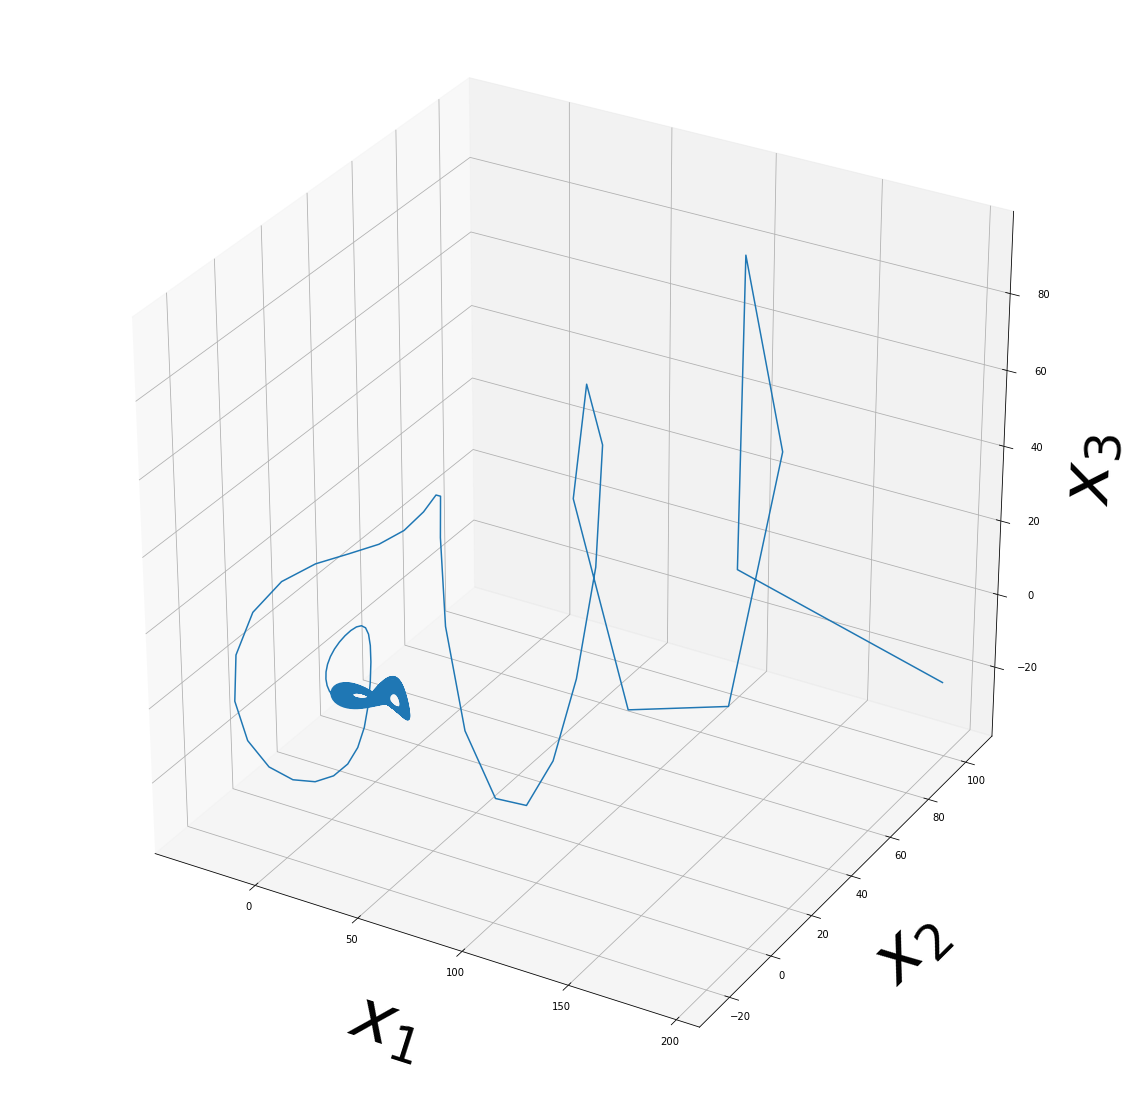

In [11]:
font_label = 70
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred2[:,0],y_pred2[:,1],y_pred2[:,2])
ax.set_xlabel('$x_1$',labelpad=40, fontsize=font_label);ax.set_ylabel('$x_2$',labelpad=40, fontsize=font_label);ax.set_zlabel('$x_3$',labelpad=40, fontsize=font_label)
ax.tick_params(axis='z', which='major', pad=15)